# Painter Classification
Using Deep Convolutional Autoencoders

file:///C:/Users/Administrador/Downloads/1711.08763%20DeepPainter.pdf

The article describes the new approach in solving the problem of painting classification and its advantages over previous state-of-the-art approach. This advantage consists in replacing manual  feature extraction for the model with automatic. The authors suggest using an autoencoder, a neural network built on convolution layers, which, by self-learning to restore images after convolution, finds the most important signs distinguishing the style/manner of one artist from another, which is the basis for the authentication of an artwork. After the autoencoder has learned to restore images, the head of the classifier is put in place of the decoder, which in turn is no longer trained from scratch, but on the weights of the autoencoder (transfer learning). This approach made it possible to improve the accuracy metric of the previous one by more than 6% and get rid of manual labor.

In [ ]:
#!pip install --upgrade tensorflow

In [ ]:
#!pip install opencv-python

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import random
import json
import cv2
import pickle

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

#import tensorflow.keras.models as M
#import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

#from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Flatten, Dense, Dropout, BatchNormalization, Lambda
# GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint # EarlyStopping

from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
# cross_validate

print(tf.__version__)
print(keras.__version__)

2.12.0
2.12.0


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jun 27 07:33:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [5]:
!pip freeze > requirements.txt

# DATA

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
wikiart_5000_df = pd.read_csv('/content/drive/MyDrive/art_recognition_tech/wikiart_5000_df.csv')
artists_120_df = pd.read_csv('/content/drive/MyDrive/art_recognition_tech/artists_120_df.csv')
test_data_120_df = pd.read_csv('/content/drive/MyDrive/art_recognition_tech/test_data_120_df.csv')

In [6]:
main_col = ['title', 'artistName', 'image_width', 'image_height', 'image_new_width', 'image_new_height', 'image_new_path']

wikiart_5000_df[main_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             5000 non-null   object
 1   artistName        5000 non-null   object
 2   image_width       5000 non-null   int64 
 3   image_height      5000 non-null   int64 
 4   image_new_width   5000 non-null   int64 
 5   image_new_height  5000 non-null   int64 
 6   image_new_path    5000 non-null   object
dtypes: int64(4), object(3)
memory usage: 273.6+ KB


In [7]:
artists_120_df[main_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             120 non-null    object
 1   artistName        120 non-null    object
 2   image_width       120 non-null    int64 
 3   image_height      120 non-null    int64 
 4   image_new_width   120 non-null    int64 
 5   image_new_height  120 non-null    int64 
 6   image_new_path    120 non-null    object
dtypes: int64(4), object(3)
memory usage: 6.7+ KB


In [ ]:
wikiart_5000_df[['image_width', 'image_height', 'image_new_width', 'image_new_height']].describe()

image_width  image_height  image_new_width  image_new_height
count  5000.000000   5000.000000           5000.0            5000.0
mean   1006.610000    991.457000            256.0             256.0
std     778.659815    784.662419              0.0               0.0
min     164.000000    111.000000            256.0             256.0
25%     554.750000    540.000000            256.0             256.0
50%     798.000000    765.000000            256.0             256.0
75%    1080.000000   1024.000000            256.0             256.0
max    7060.000000   6188.000000            256.0             256.0

In [ ]:
artists_120_df[['image_width', 'image_height', 'image_new_width', 'image_new_height']].describe()

image_width  image_height  image_new_width  image_new_height
count   120.000000    120.000000            120.0             120.0
mean   1106.558333   1153.300000            256.0             256.0
std     563.299863    686.105837              0.0               0.0
min     300.000000    446.000000            256.0             256.0
25%     776.000000    780.000000            256.0             256.0
50%     942.000000   1024.000000            256.0             256.0
75%    1263.250000   1280.000000            256.0             256.0
max    4005.000000   5292.000000            256.0             256.0

In [ ]:
wikiart_5000_df['artistName'].nunique()

237

In [ ]:
artists_120_df['artistName'].value_counts()

Rembrandt                40
Renoir Pierre-Auguste    40
van Gogh Vincent         40
Name: artistName, dtype: int64

In [7]:
def get_res_image_array(data):
    images_array = []
    for path in data:
        image = cv2.imread('/content/drive/MyDrive/art_recognition_tech/' + path)
        try:
          assert(image is not None)
          #image = image.astype('float32') / 255 - 0.5 # normalizing image data
          images_array.append(image.astype('float32'))
        except:
          print(path)
    images_array = np.array(images_array)
    print('images shape', images_array.shape, 'dtype', images_array.dtype)

    return(images_array)


In [ ]:
cae_images = get_res_image_array(wikiart_5000_df['image_new_path'])

In [11]:
print(type(cae_images), end='\n\n')
print(cae_images.shape)
print(cae_images[0].shape)
cae_images[0]

<class 'numpy.ndarray'>

(5000, 256, 256, 3)
(256, 256, 3)


array([[[185., 166., 145.],
        [184., 165., 144.],
        [182., 163., 142.],
        ...,
        [207., 201., 172.],
        [207., 202., 171.],
        [209., 204., 173.]],

       [[190., 171., 150.],
        [188., 169., 148.],
        [186., 167., 146.],
        ...,
        [208., 202., 173.],
        [207., 202., 171.],
        [206., 201., 170.]],

       [[193., 176., 157.],
        [192., 175., 156.],
        [190., 173., 154.],
        ...,
        [207., 203., 174.],
        [204., 200., 171.],
        [201., 197., 168.]],

       ...,

       [[  0.,   4.,   5.],
        [  2.,   6.,   7.],
        [  3.,   6.,  10.],
        ...,
        [  2.,   4.,   5.],
        [  0.,   2.,   3.],
        [  0.,   0.,   1.]],

       [[  1.,   5.,   6.],
        [  4.,   8.,   9.],
        [  5.,   8.,  12.],
        ...,
        [  8.,  10.,  11.],
        [  5.,   7.,   8.],
        [  0.,   1.,   2.]],

       [[  2.,   6.,   7.],
        [  5.,   9.,  10.],
        [  7.,  

In [13]:
with open('/content/drive/MyDrive/art_recognition_tech/wikiart_5000.pkl', 'wb') as output:
       pickle.dump(cae_images, output)

In [5]:
with open('/content/drive/MyDrive/art_recognition_tech/wikiart_5000.pkl', 'rb') as pkl_file:
    cae_images = pickle.load(pkl_file)

In [6]:
print(type(cae_images), end='\n\n')
print(cae_images.shape)
print(cae_images[0].shape)
#cae_images_pkl[0]

<class 'numpy.ndarray'>

(5000, 256, 256, 3)
(256, 256, 3)


In [7]:
y_train = wikiart_5000_df['artistName'].values
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_train.shape

(5000, 1)

In [8]:
from sklearn.preprocessing import OneHotEncoder

labels_train = OneHotEncoder(sparse = False).fit_transform(y_train)
labels_train.shape

(5000, 237)

In [9]:
labels_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [16]:
cnn_images = get_res_image_array(artists_120_df['image_new_path'])

images shape (120, 256, 256, 3) dtype float32


In [18]:
print(type(cnn_images), end='\n\n')
print(cnn_images.shape)
print(cnn_images[0].shape)
cnn_images[0]

<class 'numpy.ndarray'>

(120, 256, 256, 3)
(256, 256, 3)


array([[[ 89.,  80., 107.],
        [ 86.,  77., 104.],
        [ 82.,  73., 100.],
        ...,
        [ 85.,  82.,  98.],
        [ 78.,  73.,  88.],
        [121., 116., 131.]],

       [[ 81.,  72.,  99.],
        [ 76.,  67.,  94.],
        [ 71.,  62.,  89.],
        ...,
        [ 69.,  66.,  82.],
        [ 62.,  57.,  72.],
        [105., 100., 115.]],

       [[ 73.,  64.,  90.],
        [ 68.,  59.,  85.],
        [ 61.,  52.,  78.],
        ...,
        [ 62.,  59.,  75.],
        [ 56.,  51.,  66.],
        [101.,  96., 111.]],

       ...,

       [[112., 134., 152.],
        [118., 140., 158.],
        [119., 140., 161.],
        ...,
        [ 53.,  52.,  62.],
        [ 51.,  47.,  58.],
        [132., 127., 136.]],

       [[116., 136., 153.],
        [118., 138., 155.],
        [116., 136., 154.],
        ...,
        [ 52.,  51.,  61.],
        [ 46.,  42.,  53.],
        [125., 120., 129.]],

       [[117., 138., 153.],
        [115., 136., 151.],
        [110., 1

In [19]:
with open('/content/drive/MyDrive/art_recognition_tech/artists_120.pkl', 'wb') as output:
       pickle.dump(cnn_images, output)

In [10]:
with open('/content/drive/MyDrive/art_recognition_tech/artists_120.pkl', 'rb') as pkl_file:
    cnn_images = pickle.load(pkl_file)

In [11]:
print(type(cnn_images), end='\n\n')
print(cnn_images.shape)
print(cnn_images[0].shape)
#cnn_images_pkl[0]

<class 'numpy.ndarray'>

(120, 256, 256, 3)
(256, 256, 3)


In [12]:
artists_120_df['artistName'].map({'Rembrandt': 1, 'Renoir Pierre-Auguste': 2, 'van Gogh Vincent ': 3}).nunique()

3

In [13]:
y = artists_120_df['artistName'].map({'Rembrandt': 1, 'Renoir Pierre-Auguste': 2, 'van Gogh Vincent ': 3}).values
y.shape

(120,)

In [14]:
#labels = np.reshape(y, (y.shape[0], 1))
labels = keras.utils.to_categorical(y)
labels.shape

(120, 4)

In [15]:
if labels.shape[1]==4:
  labels = labels[:, 1:]

# check labels
print(np.max(labels[:, 0]))
print(np.max(labels[:, 1]))
print(np.max(labels[:, 2]))

1.0
1.0
1.0


In [13]:
test_data_120_df[main_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             120 non-null    object
 1   artistName        120 non-null    object
 2   image_width       120 non-null    int64 
 3   image_height      120 non-null    int64 
 4   image_new_width   120 non-null    int64 
 5   image_new_height  120 non-null    int64 
 6   image_new_path    120 non-null    object
dtypes: int64(4), object(3)
memory usage: 6.7+ KB


In [17]:
cnn_test_images = get_res_image_array(test_data_120_df['image_new_path'])

images shape (120, 256, 256, 3) dtype float32


In [18]:
print(type(cnn_test_images), end='\n\n')
print(cnn_test_images.shape)
print(cnn_test_images[0].shape)
cnn_test_images[0]

<class 'numpy.ndarray'>

(120, 256, 256, 3)
(256, 256, 3)


array([[[117., 135., 142.],
        [142., 160., 167.],
        [137., 155., 162.],
        ...,
        [139., 157., 164.],
        [144., 162., 169.],
        [118., 136., 143.]],

       [[149., 167., 174.],
        [174., 192., 199.],
        [169., 187., 194.],
        ...,
        [171., 189., 196.],
        [176., 194., 201.],
        [150., 168., 175.]],

       [[147., 165., 172.],
        [172., 190., 197.],
        [167., 185., 192.],
        ...,
        [169., 187., 194.],
        [174., 192., 199.],
        [148., 166., 173.]],

       ...,

       [[152., 172., 183.],
        [179., 199., 210.],
        [176., 196., 207.],
        ...,
        [173., 191., 202.],
        [177., 195., 206.],
        [151., 169., 180.]],

       [[159., 178., 186.],
        [186., 205., 213.],
        [181., 201., 212.],
        ...,
        [174., 193., 206.],
        [178., 197., 210.],
        [153., 172., 185.]],

       [[124., 143., 151.],
        [151., 170., 178.],
        [145., 1

In [19]:
with open('/content/drive/MyDrive/art_recognition_tech/test_data_120.pkl', 'wb') as output:
       pickle.dump(cnn_test_images, output)

In [12]:
with open('/content/drive/MyDrive/art_recognition_tech/test_data_120.pkl', 'rb') as pkl_file:
    cnn_test_images = pickle.load(pkl_file)

print(type(cnn_test_images), end='\n\n')
print(cnn_test_images.shape)
print(cnn_test_images[0].shape)

<class 'numpy.ndarray'>

(120, 256, 256, 3)
(256, 256, 3)


In [13]:
test_data_120_df['artistName'].map({'Rembrandt': 1, 'Renoir Pierre-Auguste': 2, 'van Gogh Vincent ': 3}).nunique()

y_test = test_data_120_df['artistName'].map({'Rembrandt': 1, 'Renoir Pierre-Auguste': 2, 'van Gogh Vincent ': 3}).values
y_test.shape

(120,)

In [14]:
labels_test = keras.utils.to_categorical(y_test)
labels_test.shape

(120, 4)

In [15]:
if labels_test.shape[1]==4:
  labels_test = labels_test[:, 1:]

# check labels
print(np.max(labels_test[:, 0]))
print(np.max(labels_test[:, 1]))
print(np.max(labels_test[:, 2]))

1.0
1.0
1.0


In [5]:
CLASS_NUM            = 3
IMG_SIZE             = 256
IMG_CHANNELS         = 3
batch_size           = 32
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [17]:
def plot_cae_history(history):
    plt.figure(figsize=(10,5))
    mae = history.history['mae']
    val_mae = history.history['val_mae']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(mae))

    plt.plot(epochs, mae, 'b', label='Training MAE')
    plt.plot(epochs, val_mae, 'r', label='Validation MAE')
    plt.title('Training and validation MAE')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


def plot_cnn_history(history):
    plt.figure(figsize=(10,5))
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and validation Accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


def plot_cnn_folds(accuracy_train, accuracy_val, loss_train, loss_val):
    plt.figure(figsize=(10,5))

    folds = range(len(accuracy_train))

    plt.plot(folds, accuracy_train, 'b', label='Training accuracy')
    plt.plot(folds, accuracy_val, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    plt.plot(folds, loss_train, 'b', label='Training loss')
    plt.plot(folds, loss_val, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# MODEL

- For unsupervised training of CAE, we use a randomly selected set of 5,000 paintings from the Webmuseum (webmuseum.meulie.net/wm).
- The images have 24-bit color depth with varying resolutions averaged approximately at 1000 × 1000 pixels, and compressed as JPEG formatted files.
- We have resampled the images and normalized them to 256×256 pixels.

The **goal** here is to train the CAE to **find features that are specifically useful for paintings**, which have a more specific color and composition range in comparison to real-world images.

## CAE model

Our **CAE** contains the following layers:
1. The input layer consists of the raw image (resampled to 256 × 256 pixels) in three channels (R, G, and B)
2. Convolutional layer of size 100 × 256 × 256 with filter size 5 × 5
3. Max-pooling layer of size 2 × 2
4. Convolutional layer of size 200 × 128 × 128 with filter size 5 × 5
5. Max-pooling layer of size 2 × 2
6. Unpooling layer of size 2 × 2
7. Deconvolutional layer of size 200 × 128 × 128 (?) with filter size 5 × 5
8. Unpooling layer of size 2 × 2
9. Deconvolutional layer of size 100 × 256 × 256 (?) with filter size 5 × 5

- The learning rate starts from 0.01 and is multiplied by 0.98 after each epoch.
- In order to further encourage the CAE to find meaningful features, we randomly remove 20% of the pixels for the images per epoch.

In [53]:
K.clear_session()

The need for **transposed** convolutions generally arises from the desire to use a transformation going in the opposite direction of a normal convolution, i.e., from something that has the shape of the output of some convolution to something that has the shape of its input while maintaining a connectivity pattern that is compatible with said convolution.

In [54]:
# CAE model
def create_cae_model():
    model = Sequential()

    # Encoder part
    model.add(Conv2D(100, (5, 5), input_shape=input_shape, activation='relu', padding='same',))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(200, (5, 5), activation='relu', padding='same',)) # padding killed the idea
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Decoder part
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(200, (5, 5), activation='relu', padding='same',)) # !!! makes NO sense ???
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(100, (5, 5), activation='relu', padding='same',)) # !!! makes NO sense ???

    # Output layer
    # The final output layer has 3 channels corresponding to the reconstructed RGB image.
    model.add(Conv2DTranspose(3, (5, 5), activation='sigmoid', padding='same'))

    return model


# Create the CAE model
model_cae = create_cae_model()

model_cae.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 100)     7600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 100)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 200)     500200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 200)      0         
 2D)                                                             
                                                                 
 up_sampling2d (UpSampling2D  (None, 128, 128, 200)    0         
 )                                                               
                                                        

In [33]:
# Compile the model
model_cae.compile(loss='mean_squared_error',
                  optimizer=SGD(learning_rate=0.01),
                  metrics=['mae'])

**Why ReLU:**
1. ReLU is a piecewise linear function that is computationally efficient to differentiate compared to sigmoid. This makes it easier for the network to learn and optimize.
2. ReLU has a sparsity-inducing property, meaning that it tends to activate or "turn on" only for positive inputs. This sparsity can be beneficial in convolutional layers as it helps the network focus on important features and reduces the likelihood of saturating the network with large gradient values.
3. Sigmoid activation functions can suffer from the vanishing gradient problem, where the gradient becomes very small as the input moves away from the center of the sigmoid function. This can make learning slower, especially in deeper networks. ReLU does not suffer from this problem as it provides a constant gradient for positive inputs.


**Output layer**

The output of the final convolutional layer is typically passed through an activation function, such as sigmoid, to ensure that the pixel values are within the valid range (0 to 1 for RGB images).

By having 3 filters in the final output layer, the CAE can produce three separate feature maps, each representing the intensity of one color channel (Red, Green, or Blue). These feature maps are combined to reconstruct the full RGB image, where each pixel's color values are determined by the corresponding values in the feature maps.


**Why not Adam:**

The Adam optimizer already adapts the learning rate based on the gradients. It incorporates momentum-like behavior by using exponentially decaying moving averages of past gradients. So using both the 'adam' optimizer and a Learning Rate Scheduler together can lead to conflicting adjustments of the learning rate.

**SGD** addresses this issue by updating the model parameters using a random subset of the training data, known as a mini-batch, at each iteration. This randomness in selecting the mini-batches is the source of the "stochastic" in stochastic gradient descent.


**Why MSE:**

The MSE loss measures the average squared difference between the predicted output and the target output on a pixel-wise basis. In image reconstruction, we are interested in accurately reconstructing each pixel in the image, and the MSE loss provides a straightforward measure of how well the model is capturing the pixel values.

*Other loss functions like structural similarity index (SSIM) or perceptual loss (e.g., using pretrained deep neural networks) can also be explored depending on the specific goals and characteristics of the problem.*

*The **SSIM** method is clearly more involved than the MSE method, but the gist is that SSIM attempts to model the perceived change in the structural information of the image, whereas MSE is actually estimating the perceived errors. Furthermore, the equation in Equation 2 is used to compare two windows (i.e. small sub-samples) rather than the entire image as in MSE. Doing this leads to a more robust approach that is able to account for changes in the structure of the image, rather than just the perceived change.*

In [17]:
# Learning rate decay function
def lr_decay(epoch, learning_rate):
    if epoch == 0:
        return 0.01
    else:
        return learning_rate * 0.98


# Define the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_decay)

Dividing by 255 is a common normalization technique used in image processing and computer vision tasks. In the context of image normalization, dividing the pixel values by 255 is often performed to scale the pixel values from the range of [0, 255] to the range of [0, 1].

In digital images, the pixel values represent the intensity or color of each pixel. In an 8-bit image, like an RGB image with a color depth of 24 bits (8 bits per channel), each color channel (red, green, and blue) can have values ranging from 0 to 255.

Dividing the pixel values by 255 scales them to the range of [0, 1]. This normalization process is often done to bring the pixel values into a normalized range that is more suitable for further processing or analysis, particularly when working with algorithms or models that expect inputs in the range of [0, 1].

For example, if you have an image with pixel values [0, 255] and you divide each pixel value by 255, the resulting normalized pixel values will be in the range [0, 1]. This normalization can help with tasks like image classification, object detection, or any other machine learning algorithm that benefits from input data in a specific range.

In [58]:
# Custom data generator with random pixel removal
def data_generator(images, batch_size=batch_size):
    num_samples = len(images)
    while True:
        indices = np.random.choice(num_samples, batch_size, replace=False)
        batch_images = []
        for index in indices:
            img = images[index]
            img = img.astype('float32') / 255 - 0.5 # normalizing image data
            # Randomly remove 20% of pixels
            mask = np.random.choice([0, 1], size=img.shape[:2], p=[0.2, 0.8])
            masked_img = img.copy()
            masked_img[mask == 0] = 0
            batch_images.append(masked_img)
        yield np.array(batch_images), np.array(batch_images)


In [19]:
cae_images_train, cae_images_val = train_test_split(cae_images, test_size = 0.2, random_state=42)
print('Train shape:', cae_images_train.shape)
print('Test shape:', cae_images_val.shape)

Train shape: (4000, 256, 256, 3)
Test shape: (1000, 256, 256, 3)


In [38]:
# Train the model with learning rate scheduler and data generator
checkpoint_cae = ModelCheckpoint('/content/drive/MyDrive/art_recognition_tech/best_model_cae.hdf5',
                                 monitor=['mae'],
                                 verbose=1,
                                 mode='min')

history_model_cae = model_cae.fit(data_generator(cae_images_train),
                                  steps_per_epoch=len(cae_images_train)//batch_size,
                                  epochs=10,
                                  #batch_size=32,  # default=32. Do not specify if your data is in the form of generators
                                  validation_data=(data_generator(cae_images_val)),
                                  validation_steps=len(cae_images_val)//batch_size,
                                  callbacks=[lr_scheduler, checkpoint_cae],
                                  verbose=1
                                  )

Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 0.1287 - mae: 0.2912
Epoch 1: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae.hdf5
125/125 [==============================] - 218s 1s/step - loss: 0.1287 - mae: 0.2912 - val_loss: 0.0595 - val_mae: 0.1988 - lr: 0.0100
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 0.0571 - mae: 0.1925
Epoch 2: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae.hdf5
125/125 [==============================] - 147s 1s/step - loss: 0.0571 - mae: 0.1925 - val_loss: 0.0575 - val_mae: 0.1925 - lr: 0.0098
Epoch 3/10
125/125 [==============================] - ETA: 0s - loss: 0.0551 - mae: 0.1863
Epoch 3: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae.hdf5
125/125 [==============================] - 147s 1s/step - loss: 0.0551 - mae: 0.1863 - val_loss: 0.0555 - val_mae: 0.1862 - lr: 0.0096
Epoch 4/10
125/125 [==============================] - E

In [39]:
model_cae.get_metrics_result()

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.051500384>,
 'mae': <tf.Tensor: shape=(), dtype=float32, numpy=0.17399763>}

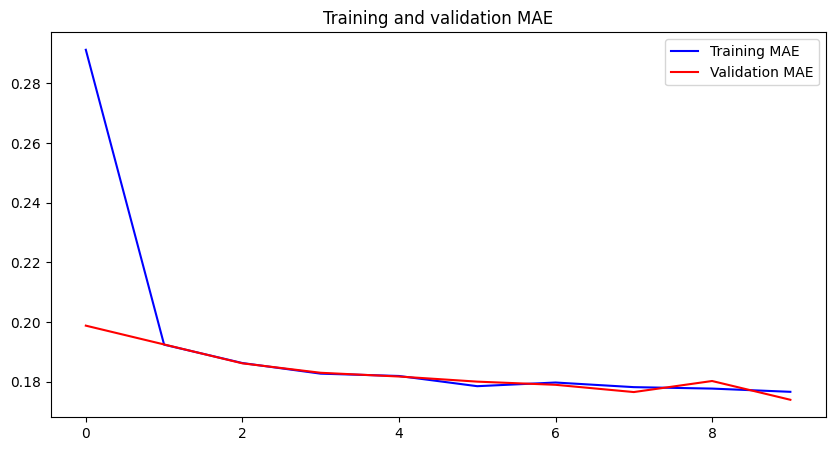

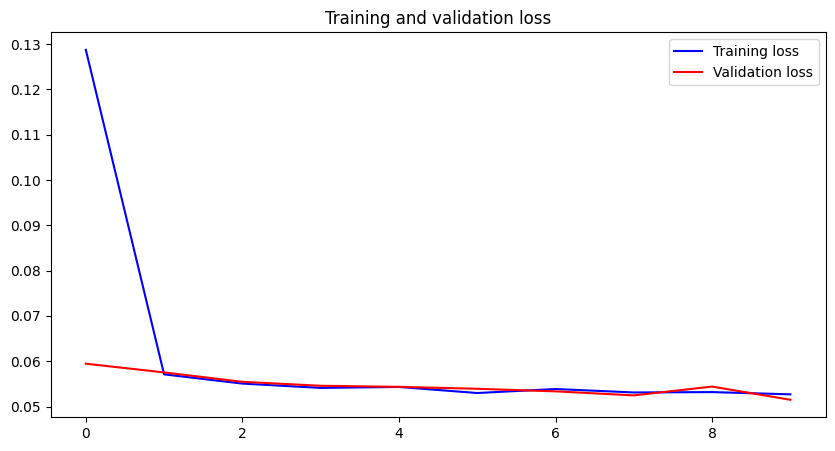

In [40]:
plot_cae_history(history_model_cae)

The learning process was going well: train and validation metrics converged fast and then was decreasing all together.

## CAE model with BatchNorm

In [21]:
K.clear_session()

In [22]:
# CAE model
def create_cae_model_norm():
    model = Sequential()

    # Encoder part
    model.add(Conv2D(100, (5, 5), input_shape=input_shape, activation='relu', padding='same',))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(200, (5, 5), activation='relu', padding='same',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Decoder part
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(200, (5, 5), activation='relu', padding='same',))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(100, (5, 5), activation='relu', padding='same',))
    model.add(BatchNormalization())

    # Output layer
    # The final output layer has 3 channels corresponding to the reconstructed RGB image.
    model.add(Conv2DTranspose(3, (5, 5), activation='sigmoid', padding='same'))

    return model


# Create the CAE model
model_cae_norm = create_cae_model_norm()

model_cae_norm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 100)     7600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 100)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 200)     500200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 200)      0         
 2D)                                                             
                                                                 
 up_sampling2d (UpSampling2D  (None, 128, 128, 200)    0         
 )                                                               
                                                        

In [23]:
# Compile the model
model_cae_norm.compile(loss='mean_squared_error',
                       optimizer=SGD(learning_rate=0.01),
                       metrics=['mae'])

In [18]:
# Learning rate decay function
def lr_decay(epoch, learning_rate):
    if epoch == 0:
        return 0.01
    else:
        return learning_rate * 0.98


# Define the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_decay)

In [19]:
# Custom data generator with random pixel removal
def data_generator(images, batch_size=batch_size):
    num_samples = len(images)
    while True:
        indices = np.random.choice(num_samples, batch_size, replace=False)
        batch_images = []
        for index in indices:
            img = images[index]
            img = img.astype('float32') / 255 - 0.5 # normalizing image data
            # Randomly remove 20% of pixels
            mask = np.random.choice([0, 1], size=img.shape[:2], p=[0.2, 0.8])
            masked_img = img.copy()
            masked_img[mask == 0] = 0
            batch_images.append(masked_img)
        yield np.array(batch_images), np.array(batch_images)


In [20]:
cae_images_train, cae_images_val = train_test_split(cae_images, test_size = 0.2, random_state=42)
print('Train shape:', cae_images_train.shape)
print('Test shape:', cae_images_val.shape)

Train shape: (4000, 256, 256, 3)
Test shape: (1000, 256, 256, 3)


In [25]:
# Train the model with learning rate scheduler and data generator
checkpoint_cae_norm = ModelCheckpoint('/content/drive/MyDrive/art_recognition_tech/best_model_cae_norm.hdf5',
                                 monitor=['mae'],
                                 verbose=1,
                                 mode='min')

history_model_cae_norm = model_cae_norm.fit(data_generator(cae_images_train),
                                  steps_per_epoch=len(cae_images_train)//batch_size,
                                  epochs=10,
                                  #batch_size=32,  # default=32. Do not specify if your data is in the form of generators
                                  validation_data=(data_generator(cae_images_val)),
                                  validation_steps=len(cae_images_val)//batch_size,
                                  callbacks=[lr_scheduler, checkpoint_cae_norm],
                                  verbose=1
                                  )

Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 0.2076 - mae: 0.3893
Epoch 1: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_norm.hdf5
125/125 [==============================] - 286s 2s/step - loss: 0.2076 - mae: 0.3893 - val_loss: 0.2842 - val_mae: 0.4904 - lr: 0.0100
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 0.1349 - mae: 0.2928
Epoch 2: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_norm.hdf5
125/125 [==============================] - 211s 2s/step - loss: 0.1349 - mae: 0.2928 - val_loss: 0.2087 - val_mae: 0.4066 - lr: 0.0098
Epoch 3/10
125/125 [==============================] - ETA: 0s - loss: 0.1131 - mae: 0.2629
Epoch 3: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_norm.hdf5
125/125 [==============================] - 211s 2s/step - loss: 0.1131 - mae: 0.2629 - val_loss: 0.1283 - val_mae: 0.2955 - lr: 0.0096
Epoch 4/10
125/125 [====================

KeyboardInterrupt: ignored

Start is bad and the learning process is slow so it was interrupt to not use resources.

## CNN model

Having trained a CAE, we can now remove the decoder components and **use the CAE for initializing a supervised CNN**.

- The supervised classification benchmark consists of (3×40 =) 120 digital reproductions of paintings by Rembrandt, Renoir, and van Gough, downloaded from the Webmuseum.
- The cross entropy loss is used.

The full **CNN** contains the following layers:
1. The input layer consists of the raw image (resampled to 256 × 256 pixels) in three channels (R, G, and B)
2. Convolutional layer with 100 5 × 5 filters per input channel
3. Max-pooling layer of size 2 × 2
4. Convolutional layer with 200 5 × 5 filters per map
5. Max-pooling layer of size 2 × 2
6. Fully connected layer of size 400
7. Fully connected layer of size 200
8. Output softmax layer of size 3

- We conducted 10-fold cross validation, where in each of 10 runs 90% of the data is used for training, and 10% for validation.
- After performing 10 such training and validation runs, the average accuracy obtained for our CNN over the validation set is 96.52%.

In [25]:
K.clear_session()

In [18]:
# Load the trained CAE model
best_model_cae = load_model('/content/drive/MyDrive/art_recognition_tech/best_model_cae.hdf5') # h5

# Remove the decoder layers of the CAE
encoder_model = Sequential(best_model_cae.layers[:-5]) # decoder_layers_to_remove

encoder_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 100)     7600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 100)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 200)     500200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 200)      0         
 2D)                                                             
                                                                 
Total params: 507,800
Trainable params: 507,800
Non-trainable params: 0
_________________________________________________________________


In [26]:
# CNN model
def CNN_model():
    model = Sequential()
    # Initialize the CNN with CAE encoder layers
    for layer in encoder_model.layers:
        model.add(layer)

    # Additional layers for classification
    model.add(Flatten())
    model.add(Dense(400, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(CLASS_NUM, activation='softmax'))

    # Initialize the CNN with CAE weights
    for i, layer in enumerate(encoder_model.layers):
        model.layers[i].set_weights(layer.get_weights())

    return model


# Create the CNN model
model_cnn = CNN_model()
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 100)     7600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 100)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 200)     500200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 200)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 819200)            0         
                                                                 
 dense (Dense)               (None, 400)               3

In [27]:
# Compile the model
model_cnn.compile(optimizer=Adam(0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

The goal of the **CategoricalCrossentropy** loss function is to measure the dissimilarity between the predicted probability distribution and the true probability distribution of the classes.
- It uses the negative logarithm of the predicted probability of the true class as the primary component of the loss.
- The loss for a single sample is given by: -log(p_true_class), where p_true_class is the predicted probability of the true class.
- The loss is averaged across all samples in a batch or dataset to obtain the final loss value.

In [21]:
def data_norm(images):
  norm_images = []
  for img in images:
    img = img.astype('float32') / 255 - 0.5 # normalizing image data
    norm_images.append(img)

  return np.array(norm_images)

In [31]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_indices, val_indices) in enumerate(kfold.split(cnn_images)):
  print(f'Test size in a fold {fold} is {len(val_indices)/(len(train_indices)+len(val_indices))*100}%')

Test size in a fold 0 is 10.0%
Test size in a fold 1 is 10.0%
Test size in a fold 2 is 10.0%
Test size in a fold 3 is 10.0%
Test size in a fold 4 is 10.0%
Test size in a fold 5 is 10.0%
Test size in a fold 6 is 10.0%
Test size in a fold 7 is 10.0%
Test size in a fold 8 is 10.0%
Test size in a fold 9 is 10.0%


Epoch 1/10
4/4 [==============================] - 3s 304ms/step - loss: 1.3326 - accuracy: 0.5000 - val_loss: 0.5404 - val_accuracy: 0.7500
Epoch 2/10
4/4 [==============================] - 1s 245ms/step - loss: 0.8177 - accuracy: 0.6759 - val_loss: 0.9954 - val_accuracy: 0.5833
Epoch 3/10
4/4 [==============================] - 1s 246ms/step - loss: 0.4319 - accuracy: 0.8426 - val_loss: 0.7702 - val_accuracy: 0.5833
Epoch 4/10
4/4 [==============================] - 1s 246ms/step - loss: 0.3235 - accuracy: 0.8796 - val_loss: 0.8936 - val_accuracy: 0.6667
Epoch 5/10
4/4 [==============================] - 1s 245ms/step - loss: 0.1990 - accuracy: 0.9537 - val_loss: 1.1872 - val_accuracy: 0.5833
Epoch 6/10
4/4 [==============================] - 1s 244ms/step - loss: 0.1103 - accuracy: 0.9815 - val_loss: 1.1331 - val_accuracy: 0.6667
Epoch 7/10
4/4 [==============================] - 1s 249ms/step - loss: 0.0382 - accuracy: 0.9907 - val_loss: 1.4373 - val_accuracy: 0.5833
Epoch 8/10
4/4 [====

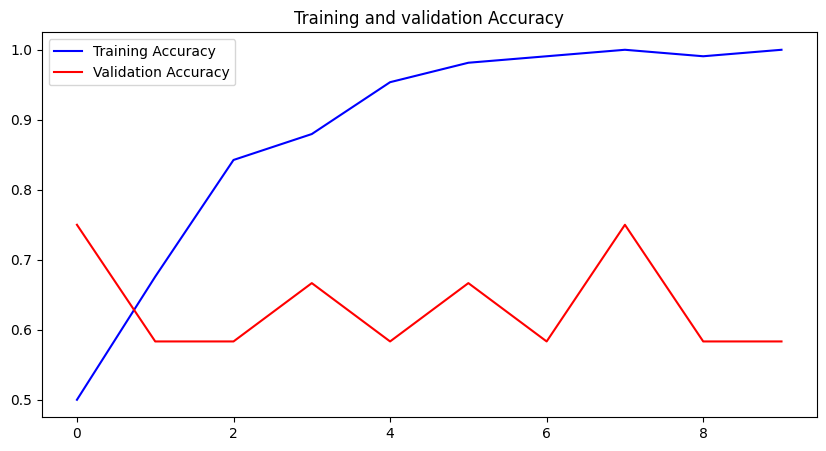

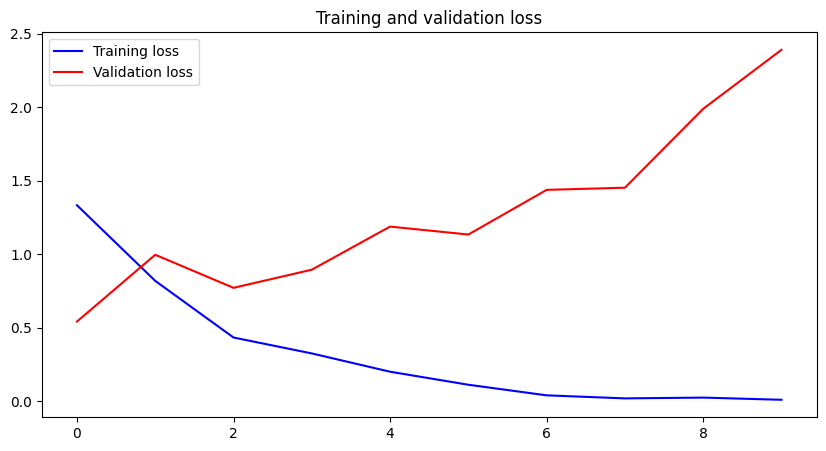

1/1 [==============================] - 0s 55ms/step - loss: 2.3911 - accuracy: 0.5833
Epoch 1/10
4/4 [==============================] - 1s 266ms/step - loss: 0.2143 - accuracy: 0.9630 - val_loss: 0.2683 - val_accuracy: 0.9167
Epoch 2/10
4/4 [==============================] - 1s 250ms/step - loss: 0.2034 - accuracy: 0.9352 - val_loss: 0.1366 - val_accuracy: 0.9167
Epoch 3/10
4/4 [==============================] - 1s 248ms/step - loss: 0.1677 - accuracy: 0.9537 - val_loss: 0.1285 - val_accuracy: 0.9167
Epoch 4/10
4/4 [==============================] - 1s 249ms/step - loss: 0.0270 - accuracy: 1.0000 - val_loss: 0.1389 - val_accuracy: 0.9167
Epoch 5/10
4/4 [==============================] - 1s 251ms/step - loss: 0.0193 - accuracy: 1.0000 - val_loss: 0.0679 - val_accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 1s 251ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.0478 - val_accuracy: 1.0000
Epoch 7/10
4/4 [==============================] - 1s 250ms/step - loss: 0.

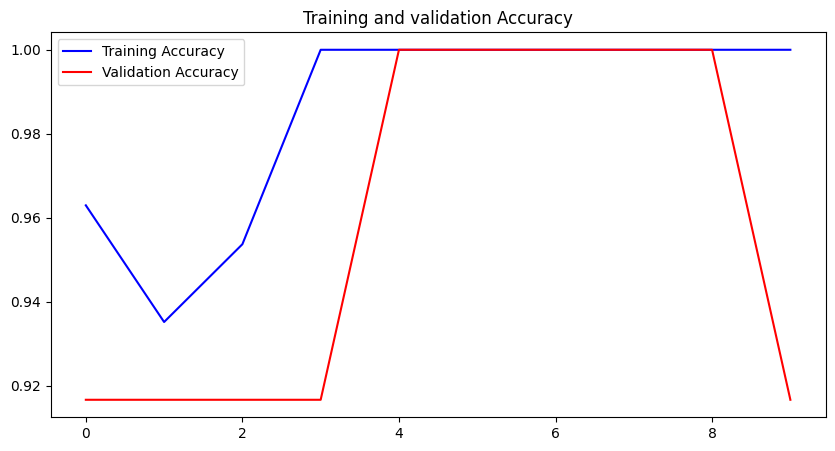

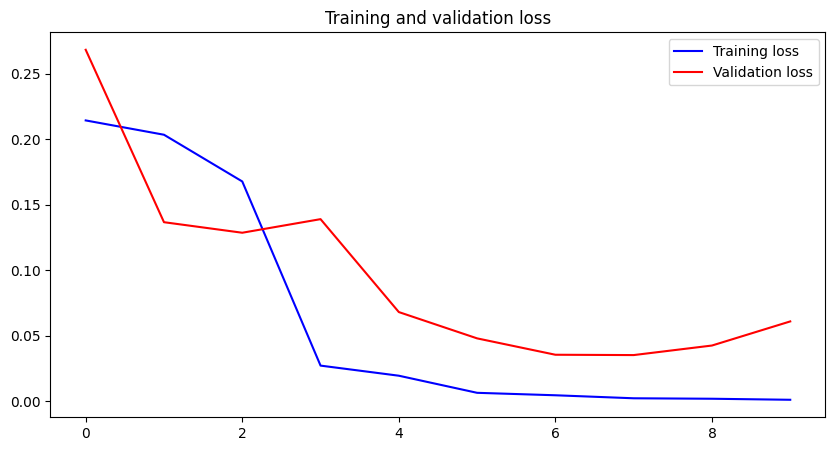

1/1 [==============================] - 0s 53ms/step - loss: 0.0608 - accuracy: 0.9167
Epoch 1/10
4/4 [==============================] - 1s 269ms/step - loss: 0.0078 - accuracy: 0.9907 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 2/10
4/4 [==============================] - 1s 255ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 5.8506e-04 - val_accuracy: 1.0000
Epoch 3/10
4/4 [==============================] - 1s 256ms/step - loss: 6.2423e-04 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 1s 253ms/step - loss: 8.7717e-04 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 5/10
4/4 [==============================] - 1s 255ms/step - loss: 7.1340e-04 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 1s 255ms/step - loss: 4.9125e-04 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 7/10
4/4 [==============================] - 1s 2

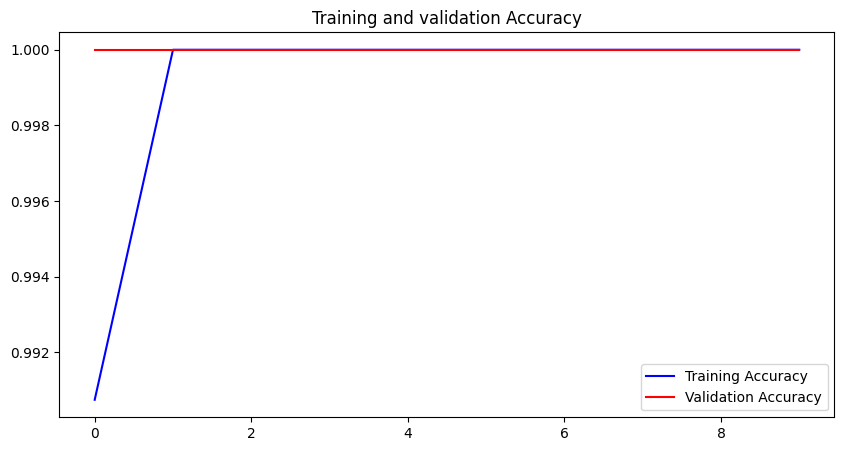

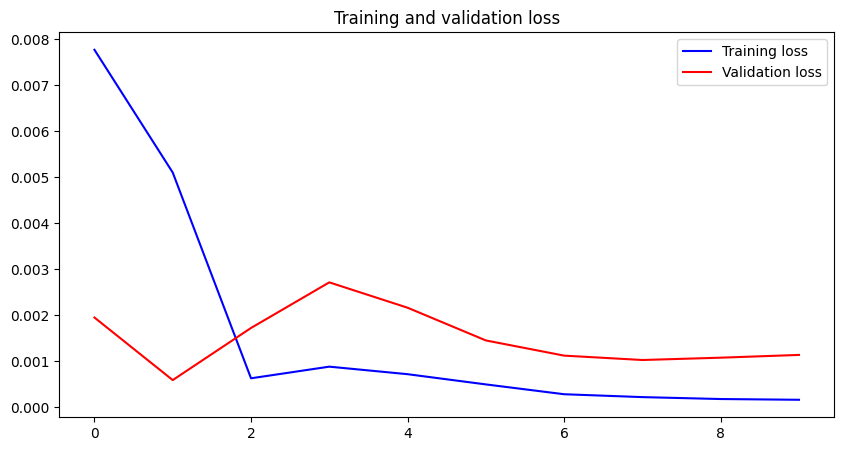

1/1 [==============================] - 0s 51ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 1/10
4/4 [==============================] - 1s 268ms/step - loss: 2.6366e-04 - accuracy: 1.0000 - val_loss: 7.3041e-05 - val_accuracy: 1.0000
Epoch 2/10
4/4 [==============================] - 1s 257ms/step - loss: 2.0031e-04 - accuracy: 1.0000 - val_loss: 6.3892e-05 - val_accuracy: 1.0000
Epoch 3/10
4/4 [==============================] - 1s 255ms/step - loss: 1.5352e-04 - accuracy: 1.0000 - val_loss: 5.8211e-05 - val_accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 1s 252ms/step - loss: 1.3162e-04 - accuracy: 1.0000 - val_loss: 5.5429e-05 - val_accuracy: 1.0000
Epoch 5/10
4/4 [==============================] - 1s 254ms/step - loss: 1.1660e-04 - accuracy: 1.0000 - val_loss: 5.6125e-05 - val_accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 1s 253ms/step - loss: 1.0396e-04 - accuracy: 1.0000 - val_loss: 5.8529e-05 - val_accuracy: 1.0000
Epoch 7/10
4/4 [==========

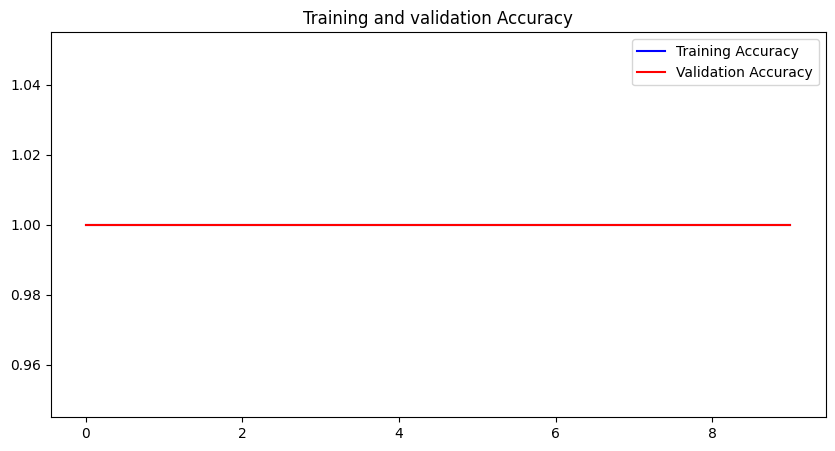

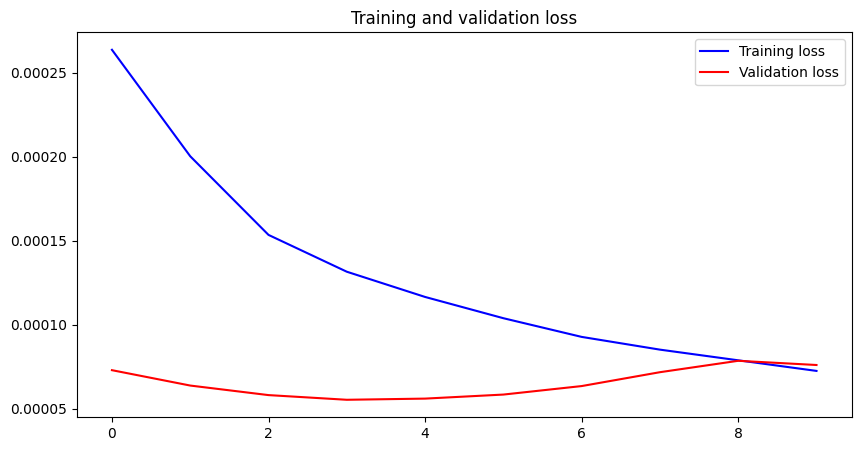

1/1 [==============================] - 0s 53ms/step - loss: 7.6119e-05 - accuracy: 1.0000
Epoch 1/10
4/4 [==============================] - 1s 262ms/step - loss: 6.8076e-05 - accuracy: 1.0000 - val_loss: 6.8927e-05 - val_accuracy: 1.0000
Epoch 2/10
4/4 [==============================] - 1s 251ms/step - loss: 6.2401e-05 - accuracy: 1.0000 - val_loss: 6.6057e-05 - val_accuracy: 1.0000
Epoch 3/10
4/4 [==============================] - 1s 251ms/step - loss: 5.8736e-05 - accuracy: 1.0000 - val_loss: 6.3951e-05 - val_accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 1s 249ms/step - loss: 5.5201e-05 - accuracy: 1.0000 - val_loss: 6.1547e-05 - val_accuracy: 1.0000
Epoch 5/10
4/4 [==============================] - 1s 251ms/step - loss: 5.1615e-05 - accuracy: 1.0000 - val_loss: 6.2044e-05 - val_accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 1s 250ms/step - loss: 4.8362e-05 - accuracy: 1.0000 - val_loss: 6.3921e-05 - val_accuracy: 1.0000
Epoch 7/10
4/4 [======

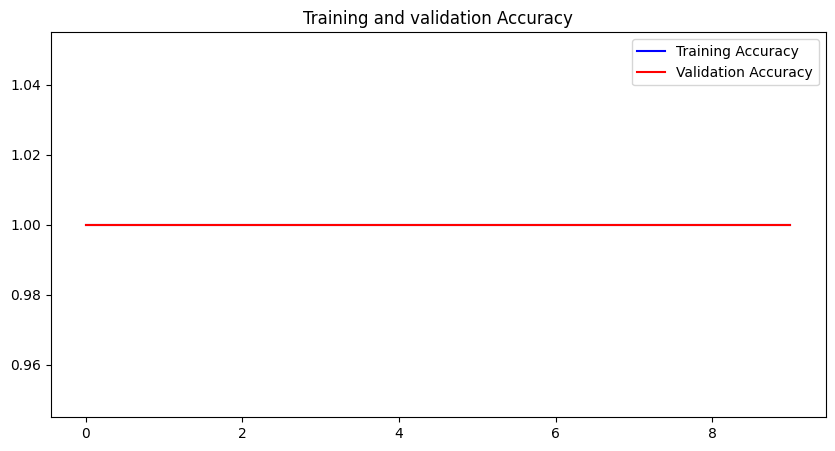

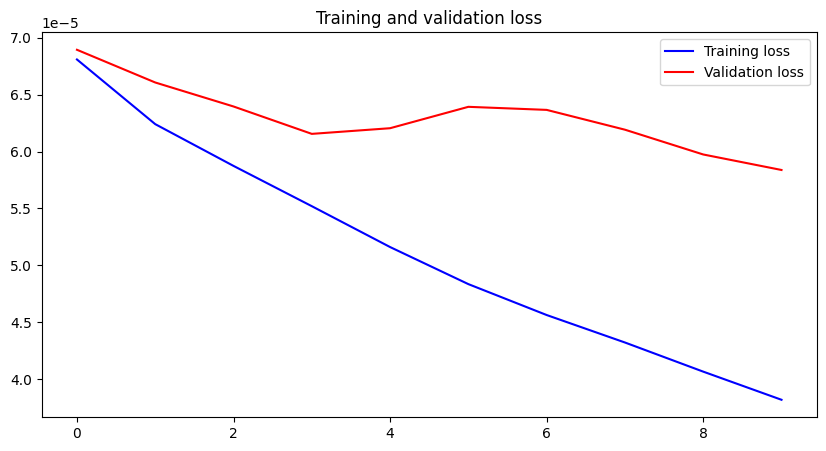

1/1 [==============================] - 0s 53ms/step - loss: 5.8378e-05 - accuracy: 1.0000
Epoch 1/10
4/4 [==============================] - 1s 264ms/step - loss: 3.9279e-05 - accuracy: 1.0000 - val_loss: 2.9543e-05 - val_accuracy: 1.0000
Epoch 2/10
4/4 [==============================] - 1s 249ms/step - loss: 3.7046e-05 - accuracy: 1.0000 - val_loss: 2.7984e-05 - val_accuracy: 1.0000
Epoch 3/10
4/4 [==============================] - 1s 250ms/step - loss: 3.5285e-05 - accuracy: 1.0000 - val_loss: 2.7000e-05 - val_accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 1s 250ms/step - loss: 3.3624e-05 - accuracy: 1.0000 - val_loss: 2.5540e-05 - val_accuracy: 1.0000
Epoch 5/10
4/4 [==============================] - 1s 247ms/step - loss: 3.1827e-05 - accuracy: 1.0000 - val_loss: 2.4527e-05 - val_accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 1s 249ms/step - loss: 3.0449e-05 - accuracy: 1.0000 - val_loss: 2.3960e-05 - val_accuracy: 1.0000
Epoch 7/10
4/4 [======

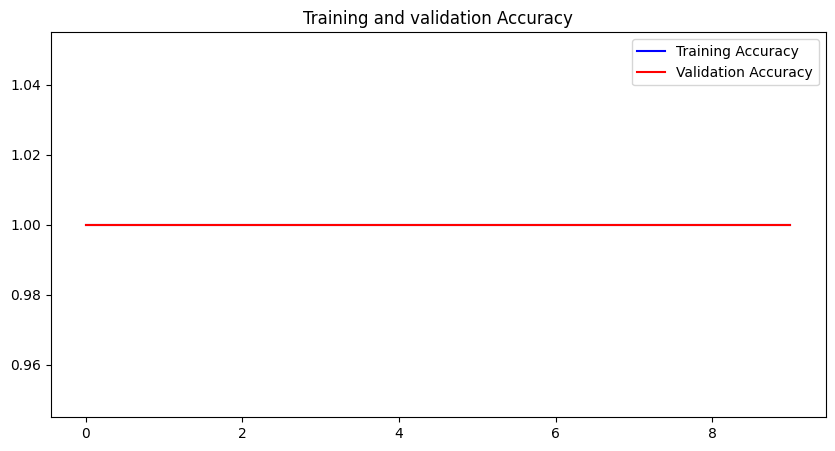

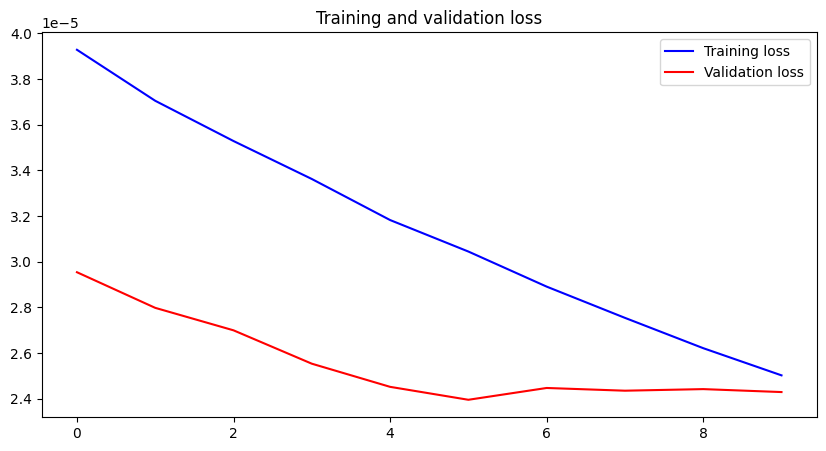

1/1 [==============================] - 0s 52ms/step - loss: 2.4298e-05 - accuracy: 1.0000
Epoch 1/10
4/4 [==============================] - 1s 261ms/step - loss: 2.2346e-05 - accuracy: 1.0000 - val_loss: 4.1144e-05 - val_accuracy: 1.0000
Epoch 2/10
4/4 [==============================] - 1s 249ms/step - loss: 2.0724e-05 - accuracy: 1.0000 - val_loss: 4.9388e-05 - val_accuracy: 1.0000
Epoch 3/10
4/4 [==============================] - 1s 247ms/step - loss: 1.9427e-05 - accuracy: 1.0000 - val_loss: 6.1803e-05 - val_accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 1s 248ms/step - loss: 1.8187e-05 - accuracy: 1.0000 - val_loss: 7.1982e-05 - val_accuracy: 1.0000
Epoch 5/10
4/4 [==============================] - 1s 249ms/step - loss: 1.7323e-05 - accuracy: 1.0000 - val_loss: 8.2806e-05 - val_accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 1s 249ms/step - loss: 1.6573e-05 - accuracy: 1.0000 - val_loss: 8.8953e-05 - val_accuracy: 1.0000
Epoch 7/10
4/4 [======

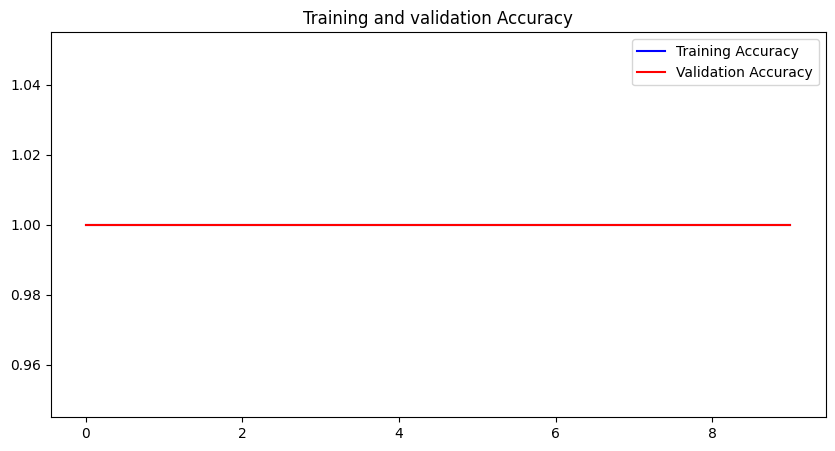

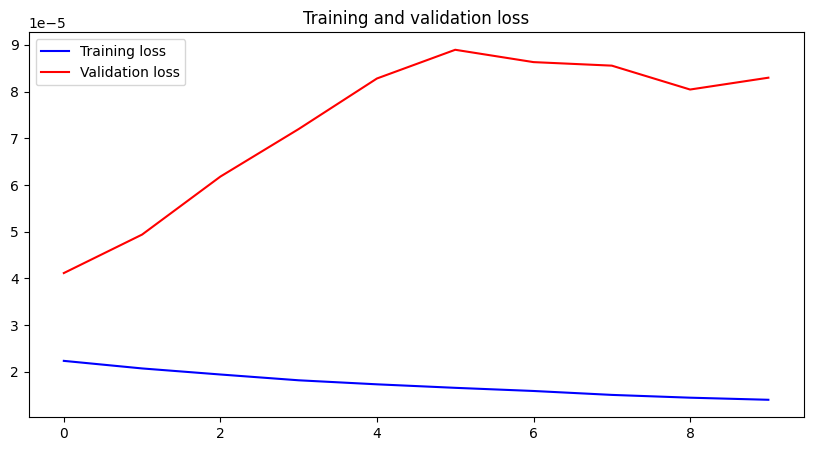

1/1 [==============================] - 0s 52ms/step - loss: 8.2975e-05 - accuracy: 1.0000
Epoch 1/10
4/4 [==============================] - 1s 258ms/step - loss: 2.0655e-05 - accuracy: 1.0000 - val_loss: 1.2715e-05 - val_accuracy: 1.0000
Epoch 2/10
4/4 [==============================] - 1s 251ms/step - loss: 1.7424e-05 - accuracy: 1.0000 - val_loss: 1.4185e-05 - val_accuracy: 1.0000
Epoch 3/10
4/4 [==============================] - 1s 249ms/step - loss: 1.6124e-05 - accuracy: 1.0000 - val_loss: 1.5497e-05 - val_accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 1s 250ms/step - loss: 1.5586e-05 - accuracy: 1.0000 - val_loss: 1.5586e-05 - val_accuracy: 1.0000
Epoch 5/10
4/4 [==============================] - 1s 251ms/step - loss: 1.4904e-05 - accuracy: 1.0000 - val_loss: 1.5159e-05 - val_accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 1s 249ms/step - loss: 1.4394e-05 - accuracy: 1.0000 - val_loss: 1.4414e-05 - val_accuracy: 1.0000
Epoch 7/10
4/4 [======

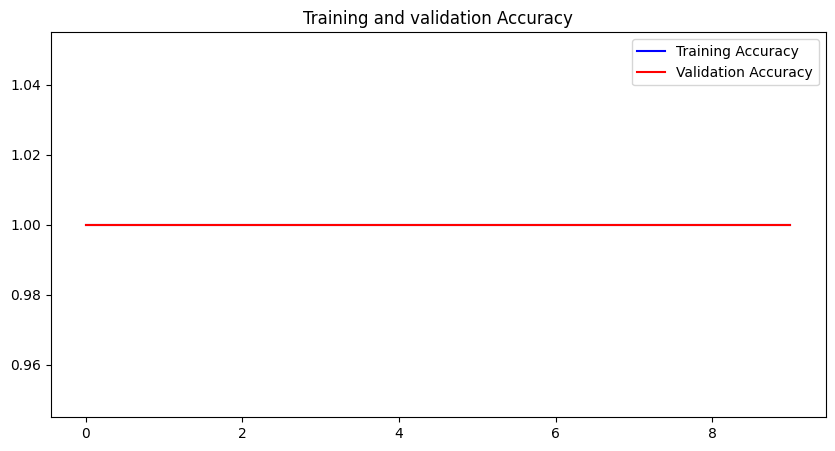

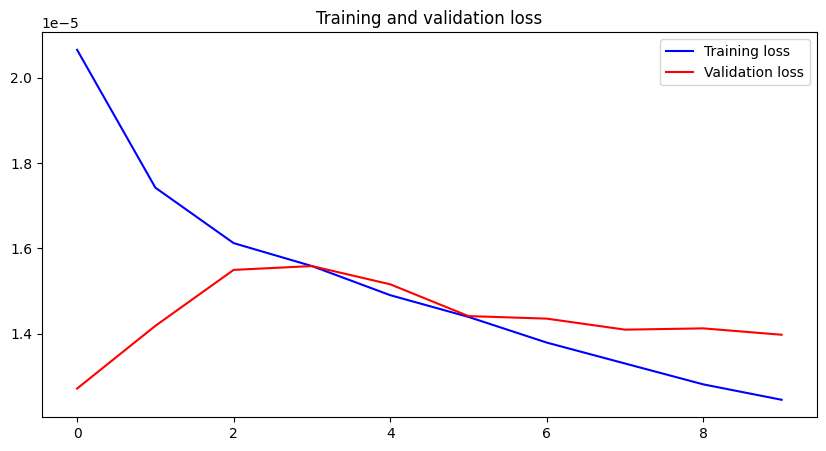

1/1 [==============================] - 0s 51ms/step - loss: 1.3977e-05 - accuracy: 1.0000
Epoch 1/10
4/4 [==============================] - 1s 262ms/step - loss: 1.2903e-05 - accuracy: 1.0000 - val_loss: 7.1624e-06 - val_accuracy: 1.0000
Epoch 2/10
4/4 [==============================] - 1s 251ms/step - loss: 1.2356e-05 - accuracy: 1.0000 - val_loss: 7.6492e-06 - val_accuracy: 1.0000
Epoch 3/10
4/4 [==============================] - 1s 250ms/step - loss: 1.1897e-05 - accuracy: 1.0000 - val_loss: 7.8876e-06 - val_accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 1s 251ms/step - loss: 1.1520e-05 - accuracy: 1.0000 - val_loss: 7.7684e-06 - val_accuracy: 1.0000
Epoch 5/10
4/4 [==============================] - 1s 252ms/step - loss: 1.1051e-05 - accuracy: 1.0000 - val_loss: 7.2618e-06 - val_accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 1s 251ms/step - loss: 1.0803e-05 - accuracy: 1.0000 - val_loss: 6.9936e-06 - val_accuracy: 1.0000
Epoch 7/10
4/4 [======

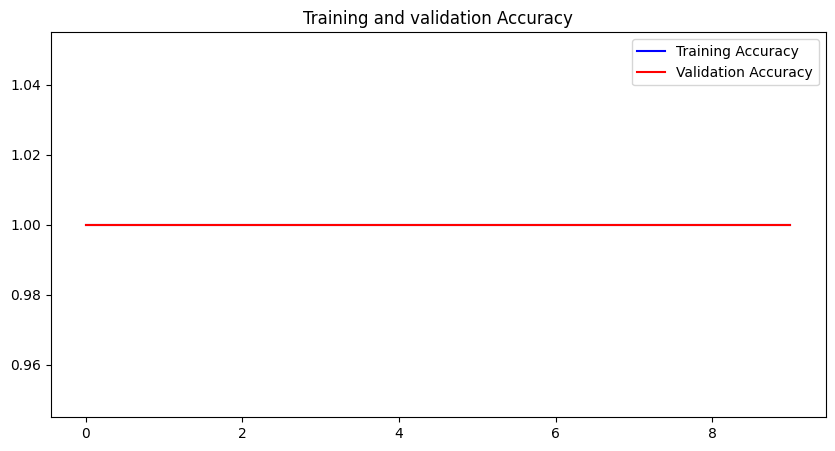

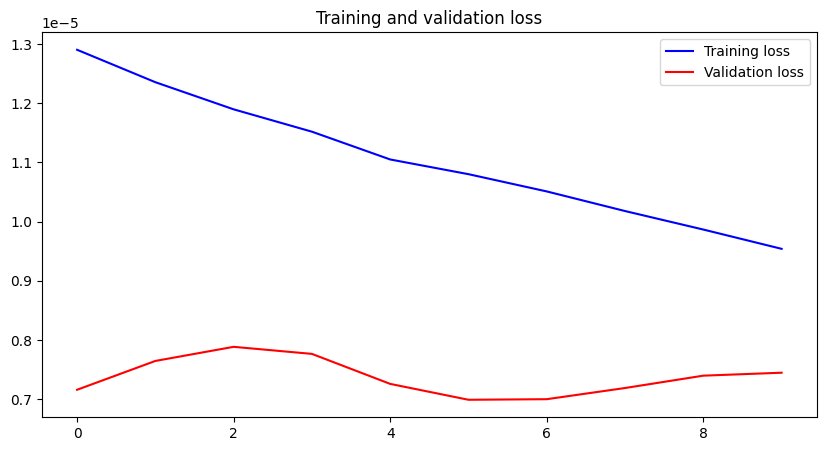

1/1 [==============================] - 0s 52ms/step - loss: 7.4505e-06 - accuracy: 1.0000
Epoch 1/10
4/4 [==============================] - 1s 256ms/step - loss: 9.5432e-06 - accuracy: 1.0000 - val_loss: 4.6293e-06 - val_accuracy: 1.0000
Epoch 2/10
4/4 [==============================] - 1s 247ms/step - loss: 9.2971e-06 - accuracy: 1.0000 - val_loss: 4.5895e-06 - val_accuracy: 1.0000
Epoch 3/10
4/4 [==============================] - 1s 247ms/step - loss: 9.0863e-06 - accuracy: 1.0000 - val_loss: 4.4604e-06 - val_accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 1s 247ms/step - loss: 8.8699e-06 - accuracy: 1.0000 - val_loss: 4.6293e-06 - val_accuracy: 1.0000
Epoch 5/10
4/4 [==============================] - 1s 251ms/step - loss: 8.6260e-06 - accuracy: 1.0000 - val_loss: 4.5697e-06 - val_accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 1s 249ms/step - loss: 8.3931e-06 - accuracy: 1.0000 - val_loss: 4.6293e-06 - val_accuracy: 1.0000
Epoch 7/10
4/4 [======

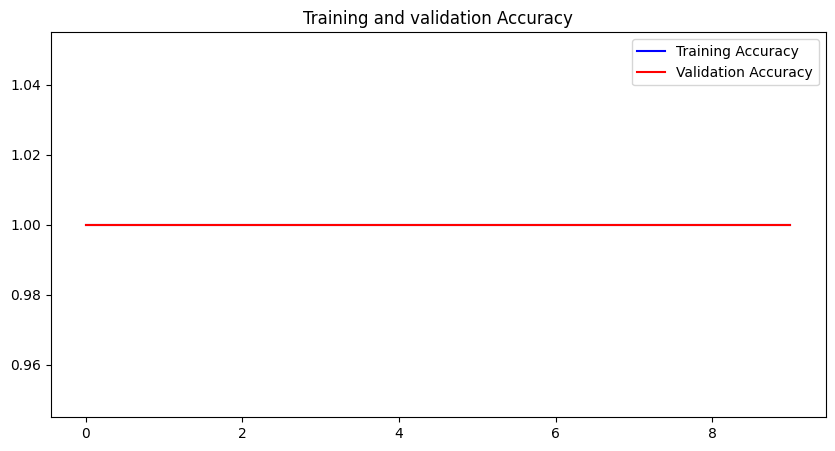

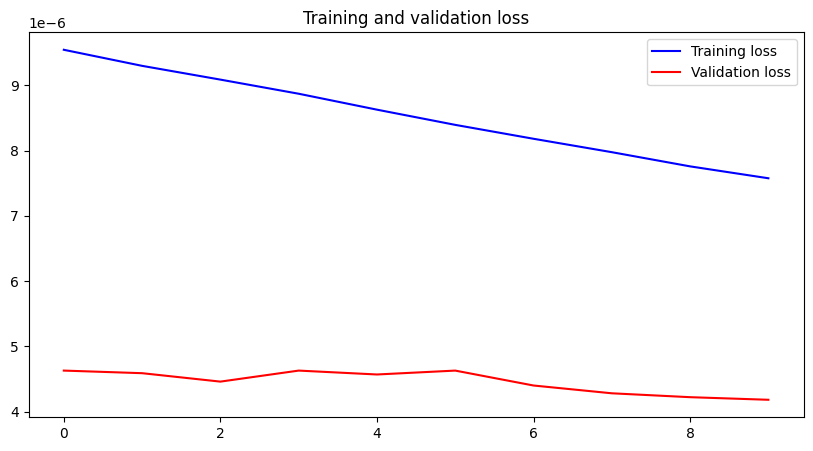

1/1 [==============================] - 0s 53ms/step - loss: 4.1822e-06 - accuracy: 1.0000


In [28]:
weights_list = []

accuracy_train = []
loss_train = []

accuracy_val = []
loss_val = []

# Iterate over the folds
for train_indices, val_indices in kfold.split(cnn_images): # labels
    history_model_cnn = model_cnn.fit(data_norm(cnn_images[train_indices]), labels[train_indices],
                  validation_data=(data_norm(cnn_images[val_indices]), labels[val_indices]),
                  epochs=10,
                  batch_size=batch_size,
                  verbose=1
                  )

    plot_cnn_history(history_model_cnn)

    train_loss, train_accuracy = model_cnn.evaluate(data_norm(cnn_images[train_indices]), labels[train_indices])
    accuracy_train.append(train_accuracy)
    loss_train.append(train_loss)

    val_loss, val_accuracy = model_cnn.evaluate(data_norm(cnn_images[val_indices]), labels[val_indices])
    accuracy_val.append(val_accuracy)
    loss_val.append(val_loss)

    weights_list.append(model_cnn.get_weights())


Train and validation accuracy converged extremely fast. And validation loss from fold to fold behaves differently. It should tell us about overfitting.

In [29]:
print("Average Accuracy:", np.mean(accuracy_val))
print("Maximum Accuracy:", np.max(accuracy_val))

Average Accuracy: 0.95
Maximum Accuracy: 1.0


In [30]:
print("Average Loss:", np.mean(loss_val))
print("Minimum Loss:", np.min(loss_val))

Average Loss: 0.2453238615668397
Minimum Loss: 4.182236807537265e-06


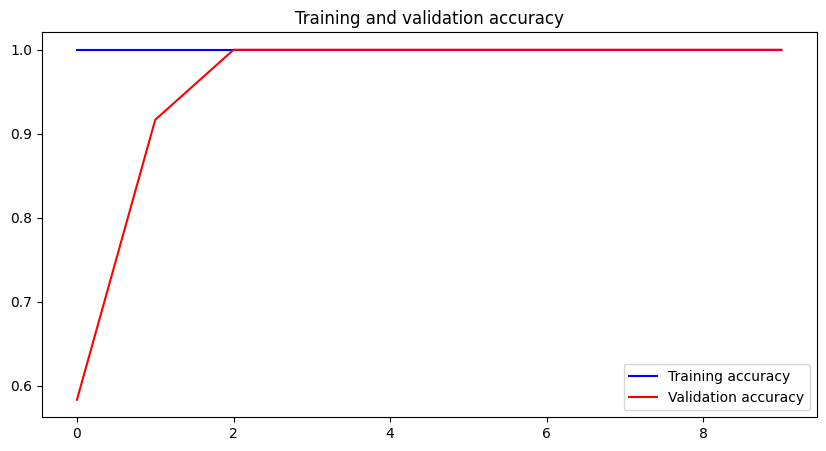

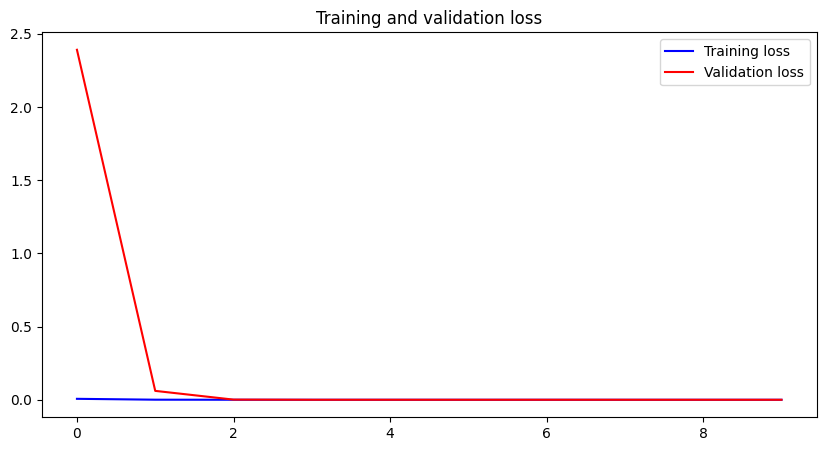

In [31]:
plot_cnn_folds(accuracy_train, accuracy_val, loss_train, loss_val)

In [32]:
from sklearn.model_selection import train_test_split

# without stratificaion by labels and random_seed
cnn_images_test, cnn_images_rest, labels_test_test, labels_test_rest  = train_test_split(cnn_test_images, labels_test, train_size=0.5)

print('cnn_images_test shape:', cnn_images_test.shape)
print('labels_test_test shape:', labels_test_test.shape, end='\n\n')

cnn_images_test shape: (60, 256, 256, 3)
labels_test_test shape: (60, 3)



In [33]:
# Average the weights
average_weights = np.mean(weights_list, axis=0)

# OR

# Define the proportions for combining the weights
#weights_proportions = [0.2, 0.3, 0.4, 0.1]

# Combine the weights based on the defined proportions
#combined_weights = []
#for i, weights in enumerate(weights_list):
#    scaled_weights = [w * weights_proportions[i] for w in weights]
#    combined_weights.append(scaled_weights)

# Set the model weights to the combined weights
#model_cnn.set_weights(np.sum(combined_weights, axis=0))

model_cnn.set_weights(average_weights)

#predictions = model_cnn.predict(data_norm(cnn_images_test))

test_loss, test_accuracy = model_cnn.evaluate(data_norm(cnn_images_test), labels_test_test)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

# Average Accuracy: 0.9666666686534882
# Average Loss: 0.10274658729540534

2/2 [==============================] - 3s 3s/step - loss: 0.9334 - accuracy: 0.7333
Test Accuracy: 0.7333333492279053
Test Loss: 0.9334095120429993


Checking the model on a test samples shows worse accuracy and huge loss.

Let's try to not only initialize the CNN model with CAE weights but freeze them.

## CNN model (CAE freezed)

In [ ]:
K.clear_session()

In [21]:
# Load the trained CAE model
best_model_cae = load_model('/content/drive/MyDrive/art_recognition_tech/best_model_cae.hdf5') # h5

# Remove the decoder layers of the CAE
encoder_model = Sequential(best_model_cae.layers[:-5]) # decoder_layers_to_remove

encoder_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 100)     7600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 100)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 200)     500200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 200)      0         
 2D)                                                             
                                                                 
Total params: 507,800
Trainable params: 507,800
Non-trainable params: 0
_________________________________________________________________


In [23]:
# CNN model
def CNN_model_frd():
    model = Sequential()
    # Initialize the CNN with CAE encoder layers
    for layer in encoder_model.layers:
        model.add(layer)

    # Additional layers for classification
    model.add(Flatten())
    model.add(Dense(400, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(CLASS_NUM, activation='softmax'))

    # Initialize the CNN with CAE weights
    for i, layer in enumerate(encoder_model.layers):
        model.layers[i].set_weights(layer.get_weights())
        model.layers[i].trainable = False

    return model


# Create the CNN model
model_cnn_frd = CNN_model_frd()
model_cnn_frd.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 100)     7600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 100)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 200)     500200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 200)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 819200)            0         
                                                                 
 dense (Dense)               (None, 400)              

In [24]:
# Compile the model
model_cnn_frd.compile(optimizer=Adam(0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

In [25]:
def data_norm(images):
  norm_images = []
  for img in images:
    img = img.astype('float32') / 255 - 0.5 # normalizing image data
    norm_images.append(img)

  return np.array(norm_images)

In [26]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_indices, val_indices) in enumerate(kfold.split(cnn_images)):
  print(f'Test size in a fold {fold} is {len(val_indices)/(len(train_indices)+len(val_indices))*100}%')

Test size in a fold 0 is 10.0%
Test size in a fold 1 is 10.0%
Test size in a fold 2 is 10.0%
Test size in a fold 3 is 10.0%
Test size in a fold 4 is 10.0%
Test size in a fold 5 is 10.0%
Test size in a fold 6 is 10.0%
Test size in a fold 7 is 10.0%
Test size in a fold 8 is 10.0%
Test size in a fold 9 is 10.0%


In [27]:
weights_list = []

accuracy_train = []
loss_train = []

accuracy_val = []
loss_val = []

# Iterate over the folds
for train_indices, val_indices in kfold.split(cnn_images): # labels
    model_cnn_frd.fit(data_norm(cnn_images[train_indices]), labels[train_indices],
                      validation_data=(data_norm(cnn_images[val_indices]), labels[val_indices]),
                      epochs=10,
                      batch_size=batch_size,
                      verbose=1
                      )

    train_loss, train_accuracy = model_cnn_frd.evaluate(data_norm(cnn_images[train_indices]), labels[train_indices])
    accuracy_train.append(train_accuracy)
    loss_train.append(train_loss)

    val_loss, val_accuracy = model_cnn_frd.evaluate(data_norm(cnn_images[val_indices]), labels[val_indices])
    accuracy_val.append(val_accuracy)
    loss_val.append(val_loss)

    weights_list.append(model_cnn_frd.get_weights())


Epoch 1/10
4/4 [==============================] - 14s 603ms/step - loss: 5.0207 - accuracy: 0.3426 - val_loss: 2.7180 - val_accuracy: 0.5833
Epoch 2/10
4/4 [==============================] - 0s 120ms/step - loss: 3.1221 - accuracy: 0.3426 - val_loss: 2.9319 - val_accuracy: 0.2500
Epoch 3/10
4/4 [==============================] - 0s 123ms/step - loss: 1.7862 - accuracy: 0.5463 - val_loss: 1.3224 - val_accuracy: 0.5833
Epoch 4/10
4/4 [==============================] - 0s 122ms/step - loss: 1.1003 - accuracy: 0.5833 - val_loss: 2.5412 - val_accuracy: 0.4167
Epoch 5/10
4/4 [==============================] - 0s 124ms/step - loss: 1.0701 - accuracy: 0.5556 - val_loss: 0.5936 - val_accuracy: 0.6667
Epoch 6/10
4/4 [==============================] - 0s 120ms/step - loss: 0.9465 - accuracy: 0.7407 - val_loss: 0.6745 - val_accuracy: 0.6667
Epoch 7/10
4/4 [==============================] - 0s 121ms/step - loss: 0.4919 - accuracy: 0.8241 - val_loss: 1.7461 - val_accuracy: 0.3333
Epoch 8/10
4/4 [===

In [ ]:
# previous
# Average Accuracy: 0.9666666686534882
# Average Loss: 0.10274658729540534

In [28]:
print("Average Accuracy:", np.mean(accuracy_val))
print("Maximum Accuracy:", np.max(accuracy_val))

Average Accuracy: 0.95
Maximum Accuracy: 1.0


In [29]:
print("Average Loss:", np.mean(loss_val))
print("Minimum Loss:", np.min(loss_val))

Average Loss: 0.15300588882528246
Minimum Loss: 0.002903694985434413


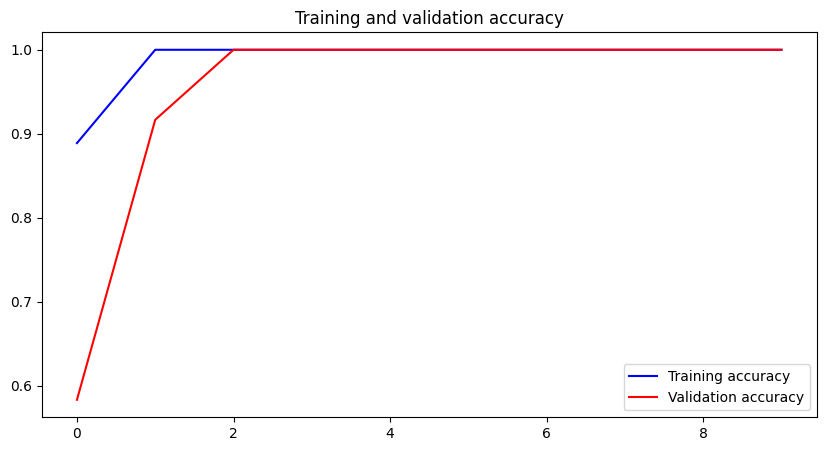

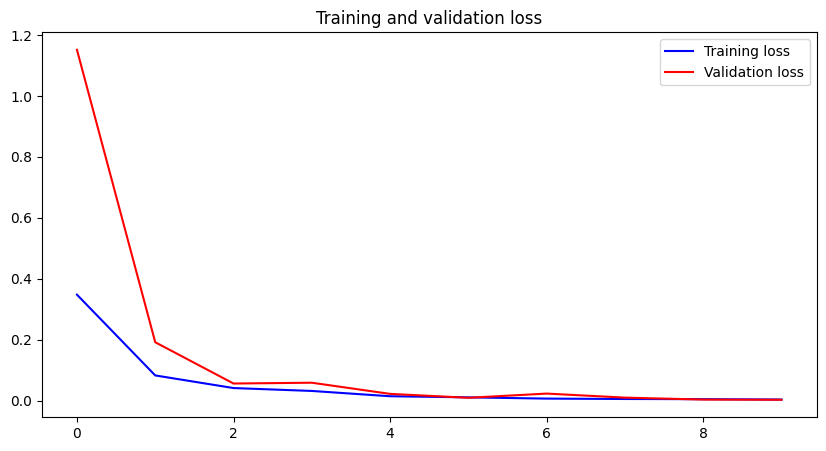

In [30]:
plot_cnn_folds(accuracy_train, accuracy_val, loss_train, loss_val)

In [31]:
cnn_images_test, cnn_images_rest, labels_test_test, labels_test_rest  = train_test_split(cnn_test_images, labels_test, train_size=0.5)

print('cnn_images_test shape:', cnn_images_test.shape)
print('labels_test_test shape:', labels_test_test.shape, end='\n\n')

cnn_images_test shape: (60, 256, 256, 3)
labels_test_test shape: (60, 3)



In [32]:
# Average the weights
average_weights = np.mean(weights_list, axis=0)

model_cnn_frd.set_weights(average_weights)

test_loss, test_accuracy = model_cnn_frd.evaluate(data_norm(cnn_images_test), labels_test_test)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

# previous
# Average Accuracy: 0.9666666686534882
# Average Loss: 0.10274658729540534
# Test Accuracy: 0.8500000238418579
# Test Loss: 0.4985653758049011

2/2 [==============================] - 3s 3s/step - loss: 0.7526 - accuracy: 0.7500
Test Accuracy: 0.75
Test Loss: 0.7526448965072632


In [33]:
cnn_images_test, cnn_images_rest, labels_test_test, labels_test_rest  = train_test_split(cnn_test_images, labels_test, train_size=0.5)

test_loss, test_accuracy = model_cnn_frd.evaluate(data_norm(cnn_images_test), labels_test_test)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

2/2 [==============================] - 0s 87ms/step - loss: 0.7217 - accuracy: 0.7500
Test Accuracy: 0.75
Test Loss: 0.7216994762420654


Results got worse.

# CAE models modifications

## Dropout instead of custom generator

The use of batch normalization and dropout layers in a convolutional autoencoder (CAE) model can have benefits depending on the specific task and the characteristics of the data. Here are some considerations:

1. Batch Normalization: Batch normalization is a technique that normalizes the inputs of each layer to have zero mean and unit variance. It can help stabilize and accelerate the training process by reducing the internal covariate shift, which is the change in the distribution of network activations during training. Batch normalization can improve gradient flow, reduce the sensitivity to weight initialization, and allow for higher learning rates.
2. Dropout: Dropout is a regularization technique that randomly sets a fraction of input units to zero during training. It helps to prevent overfitting by reducing the interdependencies among the neurons. Dropout introduces a form of ensemble learning, as it creates different subsets of the network during each training iteration, forcing the network to learn more robust features.

While both batch normalization and dropout can be beneficial in some cases, their usage in CAE models may vary:

1. Batch normalization: In the encoder part of the CAE, batch normalization can help normalize the input distributions and stabilize the training process. However, in the decoder part, where the goal is to reconstruct the original image, batch normalization may not be as necessary since the outputs should reflect the original pixel intensities rather than normalized values. You can consider using batch normalization in the encoder part while excluding it from the decoder part.
2. Dropout: Dropout can be useful in regularizing the CAE model, especially if overfitting is a concern. However, it's important to be cautious when applying dropout in the decoder part. Randomly setting pixels to zero during the decoding process may lead to loss of information and degradation in reconstruction quality. You may choose to apply dropout only in the encoder part or use a lower dropout rate in the decoder part to avoid excessive information loss.

Many types of normalization layers have been proposed for use in ConvNet architectures, sometimes with the intentions of implementing inhibition schemes observed in the biological brain. However, these layers have since fallen out of favor because in practice their contribution has been shown to be minimal, if any. So we decline the idea to use Batch normalization layers in our model.


In [48]:
K.clear_session()

In [49]:
# CAE model
def create_cae_model_mod():
    model = Sequential()

    # Encoder part
    model.add(Conv2D(100, (5, 5), input_shape=input_shape, activation='relu', padding='same',))
    #model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(200, (5, 5), activation='relu', padding='same',))
    #model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # Decoder part
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(200, (5, 5), activation='relu', padding='same',))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(100, (5, 5), activation='relu', padding='same',))

    # Output layer
    # The final output layer has 3 channels corresponding to the reconstructed RGB image.
    model.add(Conv2DTranspose(3, (5, 5), activation='sigmoid', padding='same'))

    return model


# Create the CAE model
model_cae_mod = create_cae_model_mod()

model_cae_mod.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 100)     7600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 100)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 100)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 200)     500200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 200)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 200)       0

In [50]:
batch_size = 10

def data_norm_generator(images, batch_size=batch_size):
    num_samples = len(images)
    while True:
        indices = np.random.choice(num_samples, batch_size, replace=False)
        norm_images = []
        for index in indices:
            img = images[index]
            norm_img = img.astype('float32') / 255 - 0.5 # normalizing image data
            norm_images.append(norm_img)
        yield np.array(norm_images), np.array(norm_images)

In [51]:
# Compile the model
model_cae_mod.compile(loss='mean_squared_error',
                      optimizer=SGD(learning_rate=0.01),
                      metrics=['mae'])

# Train the model with learning rate scheduler and data generator (yield np.array(batch_images), np.array(batch_images))
checkpoint_cae_mod = ModelCheckpoint('/content/drive/MyDrive/art_recognition_tech/best_model_cae_mod.hdf5',
                                     monitor=['mae'],
                                     verbose=1,
                                     mode='min')

model_cae_mod.fit(data_norm_generator(cae_images_train),
                  steps_per_epoch=len(cae_images_train)//batch_size,
                  epochs=10,
                  #batch_size=10,  # default=32
                  validation_data=(data_norm_generator(cae_images_val)),
                  validation_steps=len(cae_images_val)//batch_size,
                  callbacks=[lr_scheduler, checkpoint_cae_mod],
                  verbose=1
                  )

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.0943 - mae: 0.2514
Epoch 1: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_mod.hdf5
400/400 [==============================] - 337s 795ms/step - loss: 0.0943 - mae: 0.2514 - val_loss: 0.0655 - val_mae: 0.2153 - lr: 0.0100
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.0625 - mae: 0.2072
Epoch 2: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_mod.hdf5
400/400 [==============================] - 318s 796ms/step - loss: 0.0625 - mae: 0.2072 - val_loss: 0.0633 - val_mae: 0.2099 - lr: 0.0098
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.0619 - mae: 0.2038
Epoch 3: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_mod.hdf5
400/400 [==============================] - 318s 796ms/step - loss: 0.0619 - mae: 0.2038 - val_loss: 0.0643 - val_mae: 0.2111 - lr: 0.0096
Epoch 4/10
400/400 [==============

In [52]:
model_cae_mod.get_metrics_result()

# previous
# Train loss: 0.0527 - mae: 0.1767
#{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.051500384>,
# 'mae': <tf.Tensor: shape=(), dtype=float32, numpy=0.17399763>}

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.06020397>,
 'mae': <tf.Tensor: shape=(), dtype=float32, numpy=0.1981048>}

So Dropout layer couldn't effectively replace the random pixel removal neither on validation nor on training. Well, actually, it wasn't an equal replacemnt since Dropout is about removing features created by model but not pixels.

## Adam instead of lr_scheduler

In [55]:
# Create the CAE model
model_cae_adam = create_cae_model()

model_cae_adam.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 256, 256, 100)     7600      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 100)    0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 200)     500200    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 200)      0         
 2D)                                                             
                                                                 
 up_sampling2d_2 (UpSampling  (None, 128, 128, 200)    0         
 2D)                                                             
                                                      

In [56]:
# loss_function = keras.losses.MeanSquaredError()
# metrics_function = keras.metrics.MeanAbsoluteError()

# Compile the model
model_cae_adam.compile(loss='mean_squared_error', # loss_function
                       optimizer=Adam(learning_rate=0.001),
                       metrics=['mae'] # metrics_function
                       )

# Train the model with learning rate scheduler and data generator
checkpoint_cae_adam = ModelCheckpoint('/content/drive/MyDrive/art_recognition_tech/best_model_cae_adam.hdf5',
                                      monitor=['mae'],
                                      verbose=1,
                                      mode='min'
                                      )

In [60]:
batch_size = 10

# Custom data generator with random pixel removal
def data_generator(images, batch_size=batch_size):
    num_samples = len(images)
    while True:
        indices = np.random.choice(num_samples, batch_size, replace=False)
        batch_images = []
        for index in indices:
            img = images[index]
            img = img.astype('float32') / 255 - 0.5 # normalizing image data
            # Randomly remove 20% of pixels
            mask = np.random.choice([0, 1], size=img.shape[:2], p=[0.2, 0.8])
            masked_img = img.copy()
            masked_img[mask == 0] = 0
            batch_images.append(masked_img)
        yield np.array(batch_images), np.array(batch_images)

In [61]:
history_model_cae_adam = model_cae_adam.fit(data_generator(cae_images_train),
                                            steps_per_epoch=len(cae_images_train)//batch_size,
                                            epochs=10,
                                            #batch_size=32,  # default=32. Do not specify if your data is in the form of generators
                                            validation_data=(data_generator(cae_images_val)),
                                            validation_steps=len(cae_images_val)//batch_size,
                                            callbacks=[checkpoint_cae_adam],
                                            verbose=1
                                            )

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.0669 - mae: 0.2023
Epoch 1: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_adam.hdf5
400/400 [==============================] - 261s 651ms/step - loss: 0.0669 - mae: 0.2023 - val_loss: 0.0666 - val_mae: 0.2015
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.0661 - mae: 0.2009
Epoch 2: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_adam.hdf5
400/400 [==============================] - 263s 658ms/step - loss: 0.0661 - mae: 0.2009 - val_loss: 0.0663 - val_mae: 0.2015
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.0658 - mae: 0.2006
Epoch 3: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_adam.hdf5
400/400 [==============================] - 262s 656ms/step - loss: 0.0658 - mae: 0.2006 - val_loss: 0.0679 - val_mae: 0.2044
Epoch 4/10
400/400 [==============================] - ETA: 0s - loss: 

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.06641352>, 'mae': <tf.Tensor: shape=(), dtype=float32, numpy=0.20131977>}


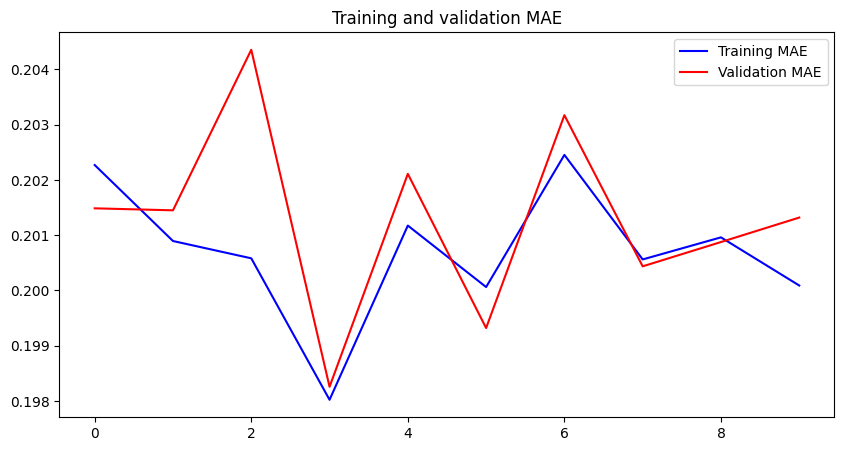

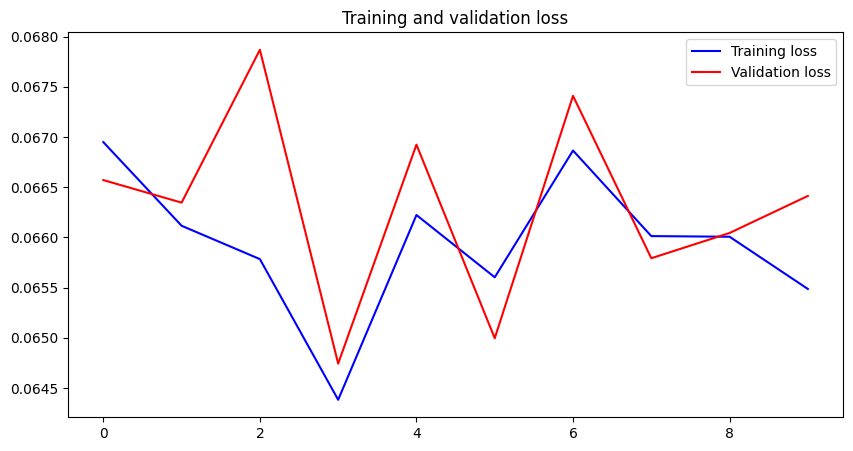

In [62]:
print(model_cae_adam.get_metrics_result())

plot_cae_history(history_model_cae_adam)

The learning process was going abruptly and hasn't reached previous results. It makes sense to decrease the larning rate. May be RMSprop optimizer.

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model_cae_rmsp.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=0.001), metrics=['mae'])

## Strided Conv instead of Pooling

In [63]:
K.clear_session()

In [64]:
# CAE model
def create_cae_strid_model():
    model = Sequential()

    # Encoder part
    model.add(Conv2D(100, (5, 5), input_shape=input_shape, activation='relu', padding='same',))
    model.add(Conv2D(100, (5, 5), activation='relu', padding='same', strides=(2, 2)))
    model.add(Conv2D(200, (5, 5), activation='relu', padding='same',))
    model.add(Conv2D(200, (5, 5), activation='relu', padding='same', strides=(2, 2)))

    # Decoder part
    model.add(Conv2DTranspose(200, (5, 5), activation='relu', padding='same', strides=(2, 2)))
    model.add(Conv2DTranspose(200, (5, 5), activation='relu', padding='same',))
    model.add(Conv2DTranspose(100, (5, 5), activation='relu', padding='same', strides=(2, 2)))
    model.add(Conv2DTranspose(100, (5, 5), activation='relu', padding='same',))

    # Output layer
    # The final output layer has 3 channels corresponding to the reconstructed RGB image.
    model.add(Conv2DTranspose(3, (5, 5), activation='sigmoid', padding='same'))

    return model


# Create the CAE model
model_cae_strid = create_cae_strid_model()

model_cae_strid.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 100)     7600      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 100)     250100    
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 200)     500200    
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 200)       1000200   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 128, 128, 200)    1000200   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 128, 200)    1000200   
 ranspose)                                              

In [65]:
# Compile the model
model_cae_strid.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.01), metrics=['mae'])

In [66]:
# Train the model with learning rate scheduler and data generator
checkpoint_cae_strid = ModelCheckpoint('/content/drive/MyDrive/art_recognition_tech/best_model_cae_strid.hdf5',
                                       monitor=['mae'],
                                       verbose=1,
                                       mode='min'
                                       )

history_model_cae_strid = model_cae_strid.fit(data_generator(cae_images_train),
                                              steps_per_epoch=len(cae_images_train)//batch_size,
                                              epochs=10,
                                              validation_data=(data_generator(cae_images_val)),
                                              validation_steps=len(cae_images_val)//batch_size,
                                              callbacks=[lr_scheduler, checkpoint_cae_strid],
                                              verbose=1
                                              )

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.1792 - mae: 0.3495
Epoch 1: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_strid.hdf5
400/400 [==============================] - 361s 864ms/step - loss: 0.1792 - mae: 0.3495 - val_loss: 0.0720 - val_mae: 0.2167 - lr: 0.0100
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.0679 - mae: 0.2083
Epoch 2: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_strid.hdf5
400/400 [==============================] - 346s 864ms/step - loss: 0.0679 - mae: 0.2083 - val_loss: 0.0677 - val_mae: 0.2060 - lr: 0.0098
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.0675 - mae: 0.2060
Epoch 3: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_strid.hdf5
400/400 [==============================] - 346s 864ms/step - loss: 0.0675 - mae: 0.2060 - val_loss: 0.0690 - val_mae: 0.2074 - lr: 0.0096
Epoch 4/10
400/400 [========

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.06590216>, 'mae': <tf.Tensor: shape=(), dtype=float32, numpy=0.20110261>}


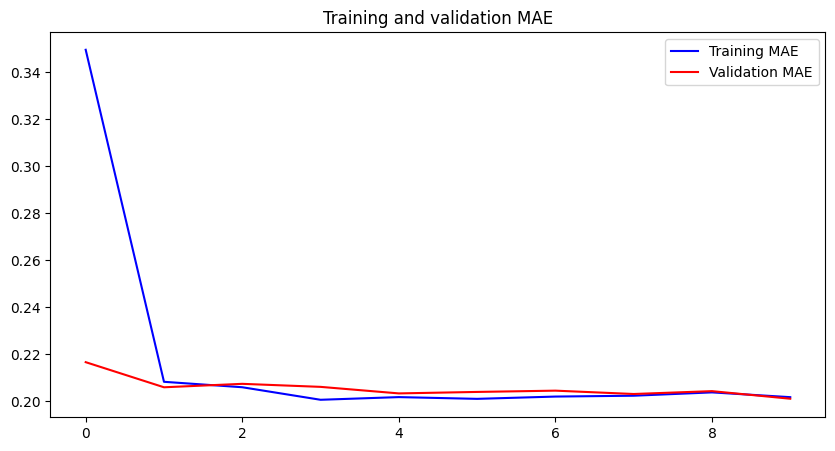

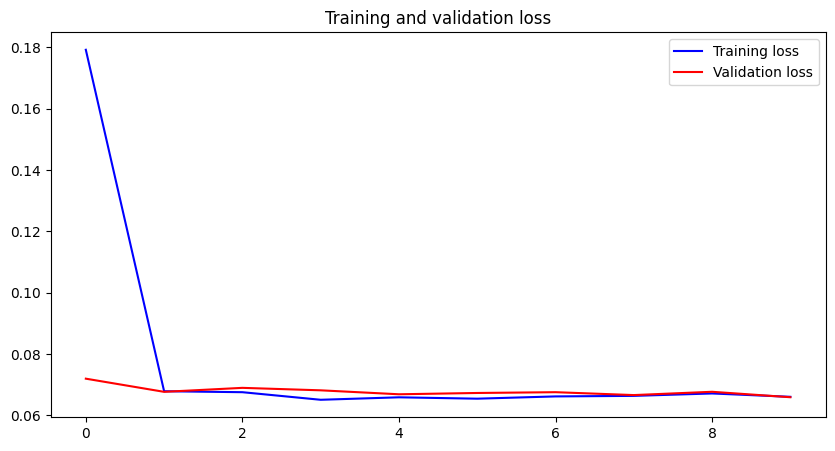

In [67]:
print(model_cae_strid.get_metrics_result())

plot_cae_history(history_model_cae_strid)

The learning process was going well: train and validation metrics converged fast and then was decreasing all together but the results are not as good as in the original model. That's sad because I placed my hopes on this technique.

## Strided Conv with normalisation only

In [68]:
K.clear_session()

In [70]:
# Create the CAE model
model_cae_strid_norm = create_cae_strid_model()

model_cae_strid_norm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 100)     7600      
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 100)     250100    
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 200)     500200    
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 200)       1000200   
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 128, 128, 200)    1000200   
 ranspose)                                                       
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 128, 128, 200)    1000200   
 ranspose)                                            

In [71]:
# Compile the model
model_cae_strid_norm.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.01), metrics=['mae'])

In [72]:
# Train the model with learning rate scheduler and data generator
checkpoint_cae_strid_norm = ModelCheckpoint('/content/drive/MyDrive/art_recognition_tech/best_model_cae_strid_norm.hdf5',
                                       monitor=['mae'],
                                       verbose=1,
                                       mode='min'
                                       )

history_model_cae_strid_norm = model_cae_strid_norm.fit(data_norm_generator(cae_images_train),
                                                        steps_per_epoch=len(cae_images_train)//batch_size,
                                                        epochs=10,
                                                        validation_data=(data_norm_generator(cae_images_val)),
                                                        validation_steps=len(cae_images_val)//batch_size,
                                                        callbacks=[lr_scheduler, checkpoint_cae_strid_norm],
                                                        verbose=1
                                                        )

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.1912 - mae: 0.3649
Epoch 1: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_strid_norm.hdf5
400/400 [==============================] - 345s 859ms/step - loss: 0.1912 - mae: 0.3649 - val_loss: 0.0882 - val_mae: 0.2597 - lr: 0.0100
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.0845 - mae: 0.2540
Epoch 2: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_strid_norm.hdf5
400/400 [==============================] - 345s 862ms/step - loss: 0.0845 - mae: 0.2540 - val_loss: 0.0845 - val_mae: 0.2538 - lr: 0.0098
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.0837 - mae: 0.2532
Epoch 3: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_strid_norm.hdf5
400/400 [==============================] - 345s 862ms/step - loss: 0.0837 - mae: 0.2532 - val_loss: 0.0834 - val_mae: 0.2522 - lr: 0.0096
Epoch 4/10
40

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.0834103>, 'mae': <tf.Tensor: shape=(), dtype=float32, numpy=0.2528298>}


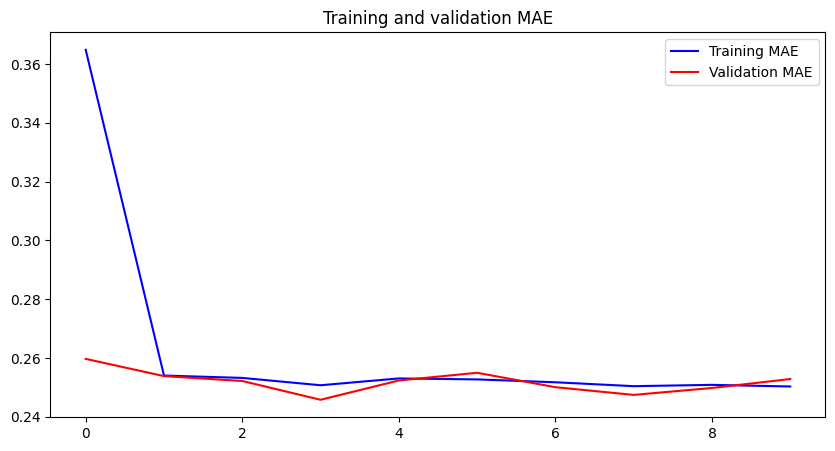

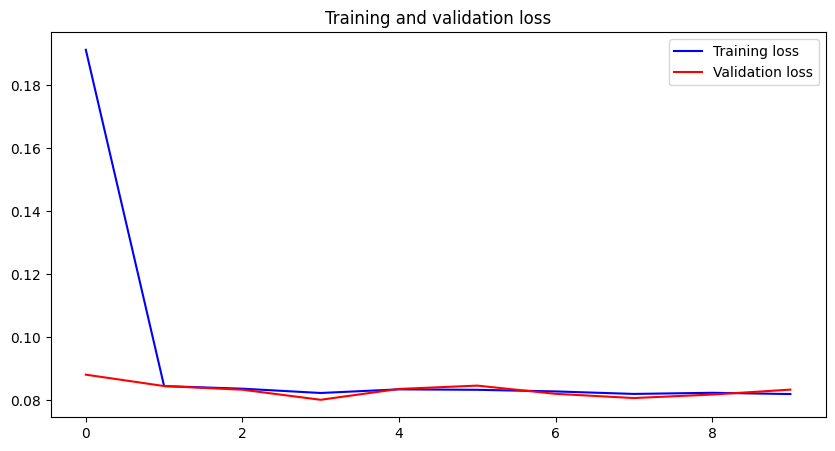

In [73]:
print(model_cae_strid_norm.get_metrics_result())

plot_cae_history(history_model_cae_strid_norm)

The learning process was going well: train and validation metrics converged fast and then was decreasing all together but the results got worse.

## ELU instead of RELU

In [74]:
K.clear_session()

In [75]:
# CAE model
def create_cae_elu_model():
    model = Sequential()

    # Encoder part
    model.add(Conv2D(100, (5, 5), input_shape=input_shape, activation='elu', padding='same',))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(200, (5, 5), activation='elu', padding='same',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Decoder part
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(200, (5, 5), activation='elu', padding='same',))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(100, (5, 5), activation='elu', padding='same',))

    # Output layer
    # The final output layer has 3 channels corresponding to the reconstructed RGB image.
    model.add(Conv2DTranspose(3, (5, 5), activation='sigmoid', padding='same'))

    return model


# Create the CAE model
model_cae_elu = create_cae_elu_model()

model_cae_elu.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 100)     7600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 100)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 200)     500200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 200)      0         
 2D)                                                             
                                                                 
 up_sampling2d (UpSampling2D  (None, 128, 128, 200)    0         
 )                                                               
                                                        

In [76]:
# Compile the model
model_cae_elu.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.01), metrics=['mae'])

# Train the model with learning rate scheduler and data generator
checkpoint_cae_elu = ModelCheckpoint('/content/drive/MyDrive/art_recognition_tech/best_model_cae_elu.hdf5',
                                       monitor=['mae'],
                                       verbose=1,
                                       mode='min'
                                       )

history_model_cae_elu = model_cae_elu.fit(data_generator(cae_images_train),
                                          steps_per_epoch=len(cae_images_train)//batch_size,
                                          epochs=10,
                                          validation_data=(data_generator(cae_images_val)),
                                          validation_steps=len(cae_images_val)//batch_size,
                                          callbacks=[lr_scheduler, checkpoint_cae_elu],
                                          verbose=1
                                          )

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.0653 - mae: 0.1987
Epoch 1: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_elu.hdf5
400/400 [==============================] - 290s 720ms/step - loss: 0.0653 - mae: 0.1987 - val_loss: 0.0535 - val_mae: 0.1787 - lr: 0.0100
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.0539 - mae: 0.1790
Epoch 2: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_elu.hdf5
400/400 [==============================] - 290s 726ms/step - loss: 0.0539 - mae: 0.1790 - val_loss: 0.0542 - val_mae: 0.1790 - lr: 0.0098
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.0530 - mae: 0.1772
Epoch 3: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_elu.hdf5
400/400 [==============================] - 290s 725ms/step - loss: 0.0530 - mae: 0.1772 - val_loss: 0.0526 - val_mae: 0.1756 - lr: 0.0096
Epoch 4/10
400/400 [==============

loss: 0.05340880900621414
mae: 0.17611956596374512


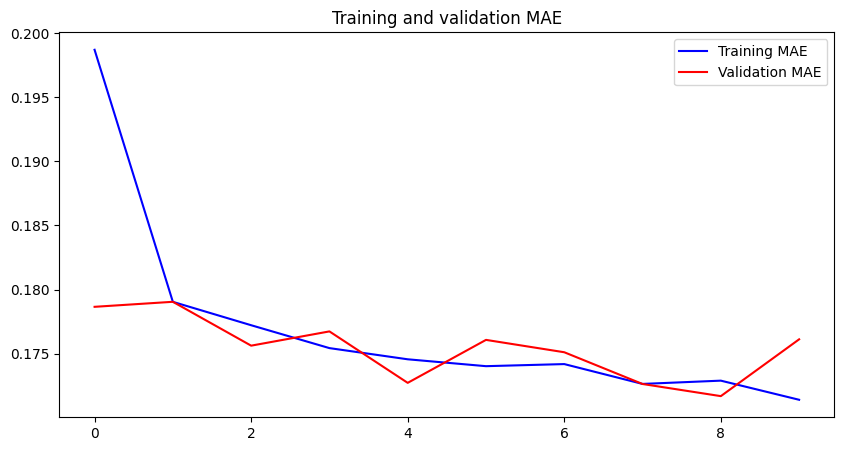

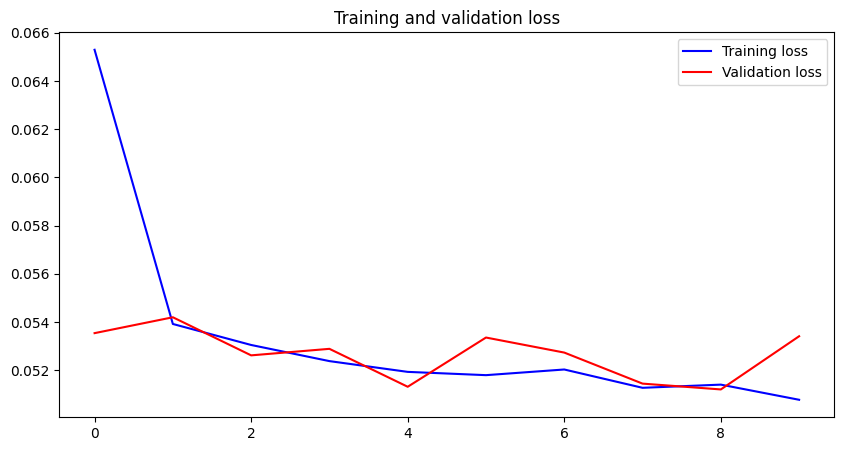

In [80]:
for k, v in model_cae_elu.get_metrics_result().items():
  print(f'{k}: {v}')
# Train: loss: 0.0508 - mae: 0.1714

plot_cae_history(history_model_cae_elu)

# previous
# Train loss: 0.0527 - mae: 0.1767
#{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.051500384>,
# 'mae': <tf.Tensor: shape=(), dtype=float32, numpy=0.17399763>}

The learning process had better start, but was going abruptly and hasn't improved the best results on validation but on training has.

## Skip connections

In [24]:
from keras.layers import Input, concatenate
from keras.models import Model

In [82]:
K.clear_session()

In [83]:
# CAE model
inputs = Input(input_shape)

# Encoder part
c1 = Conv2D(100, (5, 5), activation='relu', padding='same') (inputs)
p1 = MaxPooling2D(pool_size=(2,2)) (c1)

c2 = Conv2D(200, (5, 5), activation='relu', padding='same') (p1)
p2 = MaxPooling2D(pool_size=(2, 2)) (c2)

# Decoder part
us1 = UpSampling2D(size=(2, 2)) (p2)
usc1 = concatenate([us1, c2])
u1 = Conv2DTranspose(200, (5, 5), activation='relu', padding='same') (usc1)

us2 = UpSampling2D(size=(2, 2)) (u1)
usc2 = concatenate([us2, c1])
u2 = Conv2DTranspose(100, (5, 5), activation='relu', padding='same') (usc2)

# Output layer
outputs = Conv2DTranspose(3, (5, 5), activation='sigmoid', padding='same') (u2)


model_cae_skip = Model(inputs=[inputs], outputs=[outputs])
model_cae_skip.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 10  7600        ['input_1[0][0]']                
                                0)                                                                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 10  0           ['conv2d[0][0]']                 
                                0)                                                            

In [84]:
# Compile the model
model_cae_skip.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.01), metrics=['mae'])

# Train the model with learning rate scheduler and data generator
checkpoint_cae_skip = ModelCheckpoint('/content/drive/MyDrive/art_recognition_tech/best_model_cae_skip.hdf5',
                                       monitor=['mae'],
                                       verbose=1,
                                       mode='min'
                                       )

history_model_cae_skip = model_cae_skip.fit(data_generator(cae_images_train),
                                            steps_per_epoch=len(cae_images_train)//batch_size,
                                            epochs=10,
                                            validation_data=(data_generator(cae_images_val)),
                                            validation_steps=len(cae_images_val)//batch_size,
                                            callbacks=[lr_scheduler, checkpoint_cae_skip],
                                            verbose=1
                                            )

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.0752 - mae: 0.2158
Epoch 1: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_skip.hdf5
400/400 [==============================] - 331s 761ms/step - loss: 0.0752 - mae: 0.2158 - val_loss: 0.0549 - val_mae: 0.1841 - lr: 0.0100
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.0544 - mae: 0.1814
Epoch 2: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_skip.hdf5
400/400 [==============================] - 324s 811ms/step - loss: 0.0544 - mae: 0.1814 - val_loss: 0.0538 - val_mae: 0.1791 - lr: 0.0098
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.0530 - mae: 0.1771
Epoch 3: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_skip.hdf5
400/400 [==============================] - 305s 763ms/step - loss: 0.0530 - mae: 0.1771 - val_loss: 0.0524 - val_mae: 0.1754 - lr: 0.0096
Epoch 4/10
400/400 [===========

loss: 0.05146303027868271
mae: 0.17260050773620605


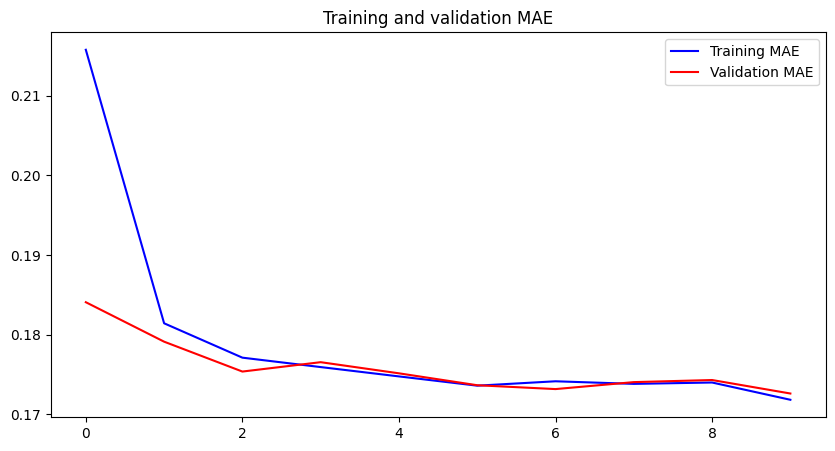

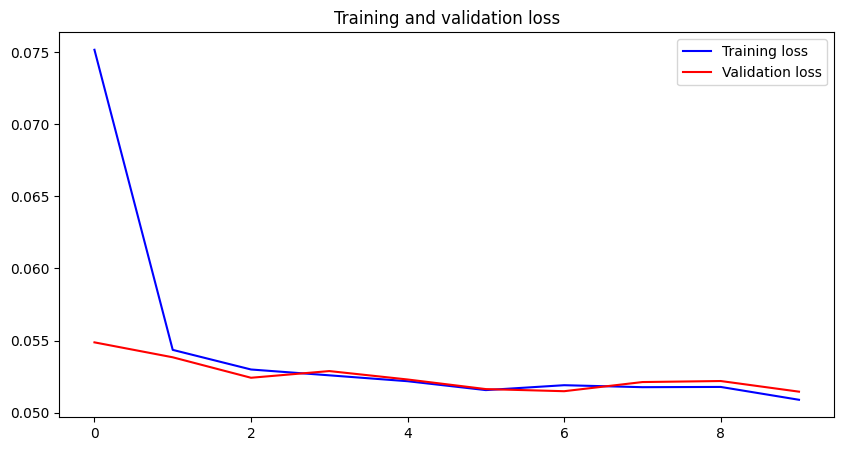

In [85]:
for k, v in model_cae_skip.get_metrics_result().items():
  print(f'{k}: {v}')

# Train loss: 0.0509 - mae: 0.1718

plot_cae_history(history_model_cae_skip)

# previous
# Train loss: 0.0527 - mae: 0.1767
#{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.051500384>,
# 'mae': <tf.Tensor: shape=(), dtype=float32, numpy=0.17399763>}

Finally we've got tiny changes for the better.

## U-Net idea

In [ ]:
K.clear_session()

Standard initializer is **GlorotUniform**.

Draws samples from a uniform distribution within [-limit, limit], where ***limit = sqrt(6 / (fan_in + fan_out))*** (***fan_in*** is the number of input **units in the weight tensor** and ***fan_out*** is the number of output units).

**HeNormal**

It draws samples from a truncated normal distribution ***centered on 0 with stddev = sqrt(2 / fan_in)***.

**GlorotNormal**

Draws samples from a truncated normal distribution ***centered on 0 with stddev = sqrt(2 / (fan_in + fan_out))***.

In [86]:
# CAE model
inputs = Input(input_shape)

# Encoder part
c1 = Conv2D(100, (5, 5), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
d1 = Dropout(0.1) (c1)
c1 = Conv2D(100, (5, 5), activation='elu', kernel_initializer='he_normal', padding='same') (d1)
p1 = MaxPooling2D(pool_size=(2,2)) (c1)

c2 = Conv2D(200, (5, 5), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
d2 = Dropout(0.2) (c2)
c2 = Conv2D(200, (5, 5), activation='elu', kernel_initializer='he_normal', padding='same') (d2)
p2 = MaxPooling2D(pool_size=(2, 2)) (c2)

# Decoder part
u1 = Conv2DTranspose(200, (5, 5), strides=(2, 2), padding='same') (p2)
u1 = concatenate([u1, c2])
c3 = Conv2D(200, (5, 5), activation='elu', kernel_initializer='he_normal', padding='same') (u1)
d3 = Dropout(0.2) (c3)
c3 = Conv2D(200, (5, 5), activation='elu', kernel_initializer='he_normal', padding='same') (d3)

u2 = Conv2DTranspose(100, (5, 5), strides=(2, 2), padding='same') (c3)
u2 = concatenate([u2, c1])
c4 = Conv2D(100, (5, 5), activation='elu', kernel_initializer='he_normal', padding='same') (u2)
d4 = Dropout(0.1) (c4)
c4 = Conv2D(100, (5, 5), activation='elu', kernel_initializer='he_normal', padding='same') (d4)

# Output layer
outputs = Conv2DTranspose(3, (5, 5), activation='sigmoid', padding='same') (c4)


model_cae_unet = Model(inputs=[inputs], outputs=[outputs])
model_cae_unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 256, 256, 10  7600        ['input_2[0][0]']                
                                0)                                                                
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 10  0           ['conv2d_2[0][0]']               
                                0)                                                          

In [87]:
# Compile the model
model_cae_unet.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.01), metrics=['mae'])

# Train the model with learning rate scheduler and data generator
checkpoint_cae_unet = ModelCheckpoint('/content/drive/MyDrive/art_recognition_tech/best_model_cae_unet.hdf5',
                                       monitor=['mae'],
                                       verbose=1,
                                       mode='min'
                                       )

history_model_cae_unet = model_cae_unet.fit(data_generator(cae_images_train),
                                            steps_per_epoch=len(cae_images_train)//batch_size,
                                            epochs=10,
                                            validation_data=(data_generator(cae_images_val)),
                                            validation_steps=len(cae_images_val)//batch_size,
                                            callbacks=[lr_scheduler, checkpoint_cae_unet],
                                            verbose=1
                                            )

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.0580 - mae: 0.1883
Epoch 1: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_unet.hdf5
400/400 [==============================] - 684s 2s/step - loss: 0.0580 - mae: 0.1883 - val_loss: 0.0543 - val_mae: 0.1789 - lr: 0.0100
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.0525 - mae: 0.1763
Epoch 2: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_unet.hdf5
400/400 [==============================] - 663s 2s/step - loss: 0.0525 - mae: 0.1763 - val_loss: 0.0509 - val_mae: 0.1707 - lr: 0.0098
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.0506 - mae: 0.1721
Epoch 3: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_unet.hdf5
400/400 [==============================] - 663s 2s/step - loss: 0.0506 - mae: 0.1721 - val_loss: 0.0500 - val_mae: 0.1674 - lr: 0.0096
Epoch 4/10
400/400 [====================

loss: 0.044595107436180115
mae: 0.15296217799186707


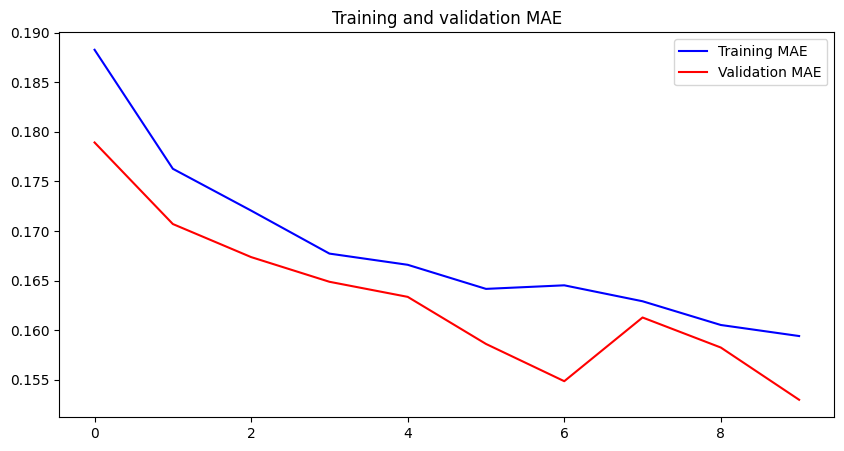

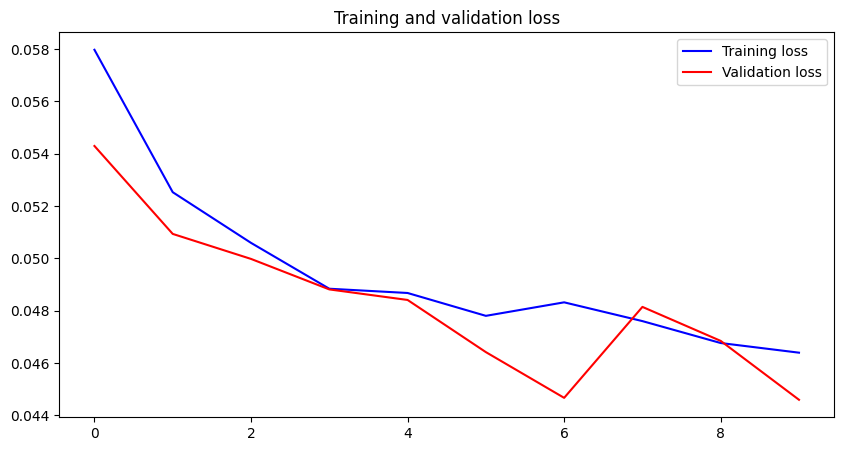

In [88]:
for k, v in model_cae_unet.get_metrics_result().items():
  print(f'{k}: {v}')

# Train loss: 0.0464 - mae: 0.1594

plot_cae_history(history_model_cae_unet)

# previous
# Train loss: 0.0527 - mae: 0.1767
#{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.051500384>,
# 'mae': <tf.Tensor: shape=(), dtype=float32, numpy=0.17399763>}

ELU gave us abrupt learning process but now we have visibal changes for the better metrics.

# CNN models modifications

## Upon u-net idea

In [25]:
K.clear_session()

In [26]:
# Load the trained CAE model
best_model_cae = load_model('/content/drive/MyDrive/art_recognition_tech/best_model_cae_unet.hdf5') # h5

# Remove the decoder layers of the CAE
encoder_model = Sequential(best_model_cae.layers[:9]) # decoder_layers_to_remove

# for fine-tuning purpose, we truncate the original softmax layer and replace it with our own
#encoder_model.layers.pop()
#encoder_model.outputs = [encoder_model.layers[-11].output]
#encoder_model.layers[-11].outbound_nodes = []

'''
Since in #1 we have popped the last layer, which is the original output layer,
we need to update the destination of the output layer.
#2 is to reset the last layer of encoder part as the output layer.
#3 is to say the last layer of encoder part should not have anymore connections to the popped layer,
since it is now the output layer.
'''

encoder_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 256, 256, 100)     7600      
                                                                 
 dropout (Dropout)           (None, 256, 256, 100)     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 100)     250100    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 100)    0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 200)     500200    
                                                                 
 dropout_1 (Dropout)         (None, 128, 128, 200)     0         
                                                        

In [27]:
# CNN model
def CNN_model_unet():
    model = Sequential()
    model.add(Input(input_shape))

    # Initialize the CNN with CAE encoder layers
    for layer in encoder_model.layers:
        model.add(layer)

    # Additional layers for classification
    model.add(Flatten())
    model.add(Dense(400, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(CLASS_NUM, activation='softmax'))

    # Initialize the CNN with CAE weights
    for i, layer in enumerate(encoder_model.layers):
        model.layers[i].set_weights(layer.get_weights())
        #model.layers[i].trainable = False

    return model


# Create the CNN model
model_cnn_unet = CNN_model_unet()
model_cnn_unet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 256, 256, 100)     7600      
                                                                 
 dropout (Dropout)           (None, 256, 256, 100)     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 100)     250100    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 100)    0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 200)     500200    
                                                                 
 dropout_1 (Dropout)         (None, 128, 128, 200)     0         
                                                      

In [28]:
# Compile the model
model_cnn_unet.compile(optimizer=Adam(0.0001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

In [29]:
batch_size = 10

def data_norm(images):
  norm_images = []
  for img in images:
    img = img.astype('float32') / 255 - 0.5 # normalizing image data
    norm_images.append(img)

  return np.array(norm_images)

Epoch 1/10
11/11 [==============================] - 43s 2s/step - loss: 23.2432 - accuracy: 0.5000 - val_loss: 15.8536 - val_accuracy: 0.4167
Epoch 2/10
11/11 [==============================] - 6s 536ms/step - loss: 11.0344 - accuracy: 0.6111 - val_loss: 12.5378 - val_accuracy: 0.6667
Epoch 3/10
11/11 [==============================] - 6s 536ms/step - loss: 2.8529 - accuracy: 0.7685 - val_loss: 6.2329 - val_accuracy: 0.6667
Epoch 4/10
11/11 [==============================] - 6s 532ms/step - loss: 5.3705 - accuracy: 0.7500 - val_loss: 9.6330 - val_accuracy: 0.5000
Epoch 5/10
11/11 [==============================] - 6s 532ms/step - loss: 4.0338 - accuracy: 0.8148 - val_loss: 1.6682 - val_accuracy: 0.5833
Epoch 6/10
11/11 [==============================] - 6s 534ms/step - loss: 1.5458 - accuracy: 0.8519 - val_loss: 3.4600 - val_accuracy: 0.7500
Epoch 7/10
11/11 [==============================] - 6s 536ms/step - loss: 1.0514 - accuracy: 0.8796 - val_loss: 1.0485 - val_accuracy: 0.8333
Epoc

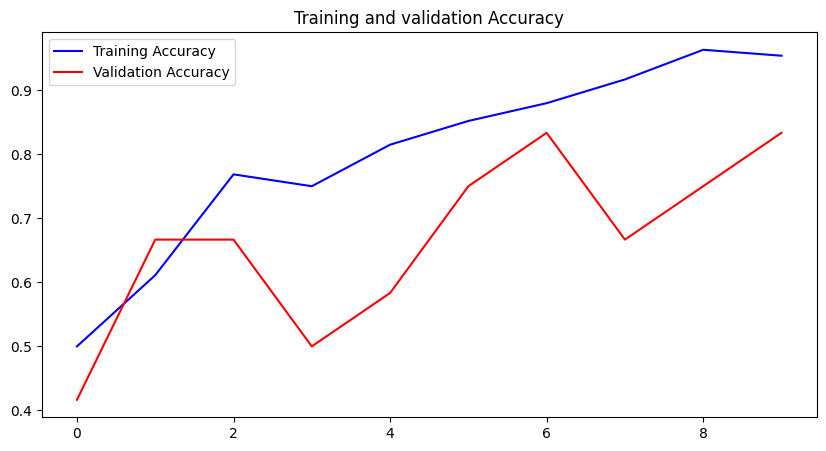

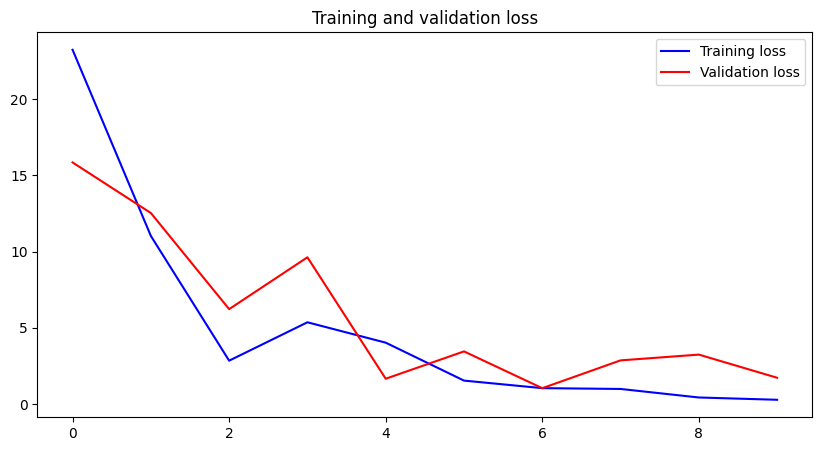

1/1 [==============================] - 0s 138ms/step - loss: 1.7323 - accuracy: 0.8333
Epoch 1/10
11/11 [==============================] - 6s 548ms/step - loss: 0.2896 - accuracy: 0.9722 - val_loss: 1.5485 - val_accuracy: 0.7500
Epoch 2/10
11/11 [==============================] - 6s 544ms/step - loss: 0.1797 - accuracy: 0.9722 - val_loss: 0.4169 - val_accuracy: 0.9167
Epoch 3/10
11/11 [==============================] - 6s 544ms/step - loss: 0.1827 - accuracy: 0.9722 - val_loss: 0.4290 - val_accuracy: 0.9167
Epoch 4/10
11/11 [==============================] - 6s 545ms/step - loss: 0.0617 - accuracy: 0.9907 - val_loss: 2.3660e-05 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 6s 546ms/step - loss: 0.0431 - accuracy: 0.9907 - val_loss: 1.7585 - val_accuracy: 0.9167
Epoch 6/10
11/11 [==============================] - 6s 545ms/step - loss: 0.0223 - accuracy: 0.9907 - val_loss: 1.9696 - val_accuracy: 0.9167
Epoch 7/10
11/11 [==============================] - 6s 54

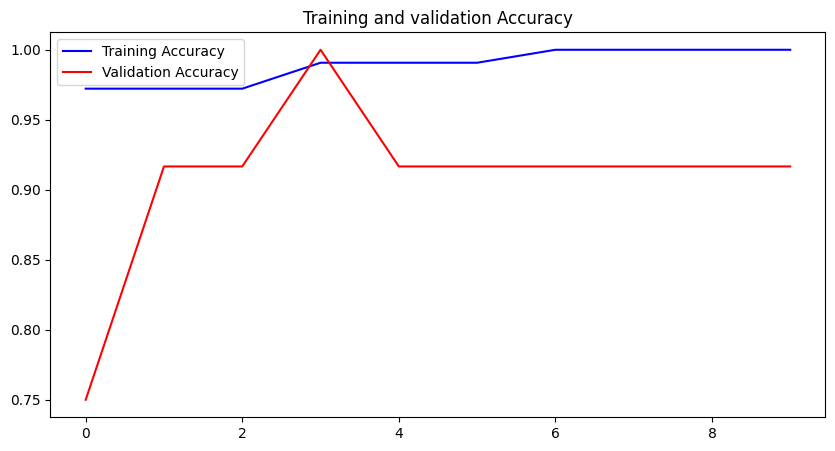

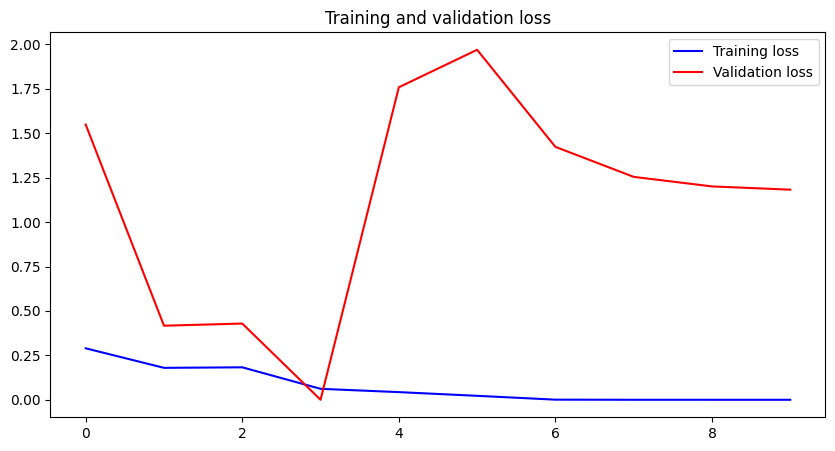

1/1 [==============================] - 0s 137ms/step - loss: 1.1824 - accuracy: 0.9167
Epoch 1/10
11/11 [==============================] - 6s 550ms/step - loss: 8.6255e-05 - accuracy: 1.0000 - val_loss: 2.0862e-07 - val_accuracy: 1.0000
Epoch 2/10
11/11 [==============================] - 6s 549ms/step - loss: 7.4126e-05 - accuracy: 1.0000 - val_loss: 2.2848e-07 - val_accuracy: 1.0000
Epoch 3/10
11/11 [==============================] - 6s 549ms/step - loss: 4.1916e-05 - accuracy: 1.0000 - val_loss: 2.3842e-07 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 6s 550ms/step - loss: 3.9709e-05 - accuracy: 1.0000 - val_loss: 2.3842e-07 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 6s 550ms/step - loss: 2.1461e-05 - accuracy: 1.0000 - val_loss: 2.4835e-07 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 6s 551ms/step - loss: 1.7558e-05 - accuracy: 1.0000 - val_loss: 2.4835e-07 - val_accuracy: 1.0000
Epoch 7/10
11

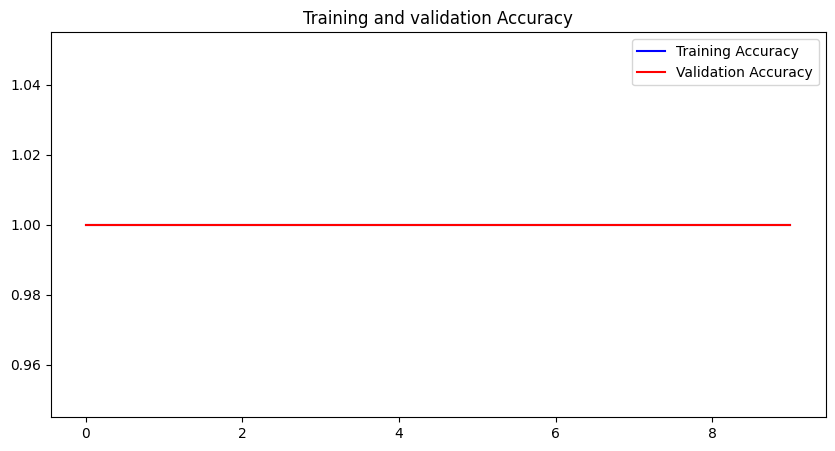

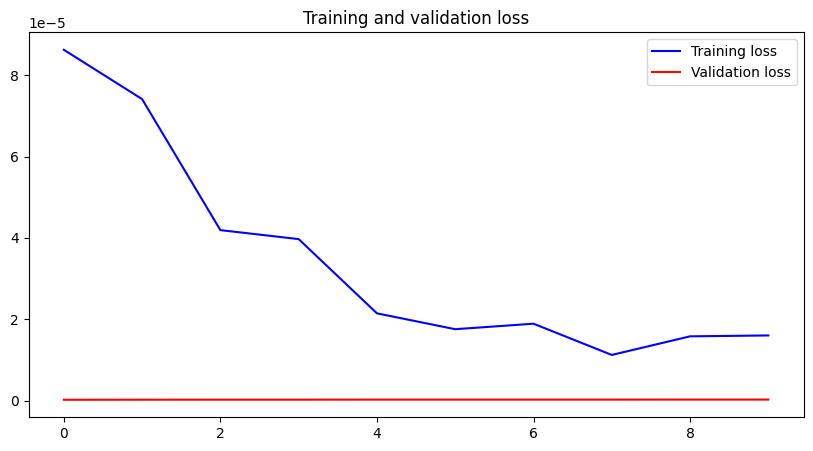

1/1 [==============================] - 0s 141ms/step - loss: 2.5829e-07 - accuracy: 1.0000
Epoch 1/10
11/11 [==============================] - 6s 556ms/step - loss: 1.2313e-05 - accuracy: 1.0000 - val_loss: 0.2315 - val_accuracy: 0.9167
Epoch 2/10
11/11 [==============================] - 6s 554ms/step - loss: 1.0994e-05 - accuracy: 1.0000 - val_loss: 0.2304 - val_accuracy: 0.9167
Epoch 3/10
11/11 [==============================] - 6s 553ms/step - loss: 1.1114e-05 - accuracy: 1.0000 - val_loss: 0.2296 - val_accuracy: 0.9167
Epoch 4/10
11/11 [==============================] - 6s 555ms/step - loss: 1.0602e-05 - accuracy: 1.0000 - val_loss: 0.2288 - val_accuracy: 0.9167
Epoch 5/10
11/11 [==============================] - 6s 556ms/step - loss: 1.2227e-05 - accuracy: 1.0000 - val_loss: 0.2278 - val_accuracy: 0.9167
Epoch 6/10
11/11 [==============================] - 6s 561ms/step - loss: 1.1114e-05 - accuracy: 1.0000 - val_loss: 0.2271 - val_accuracy: 0.9167
Epoch 7/10
11/11 [===============

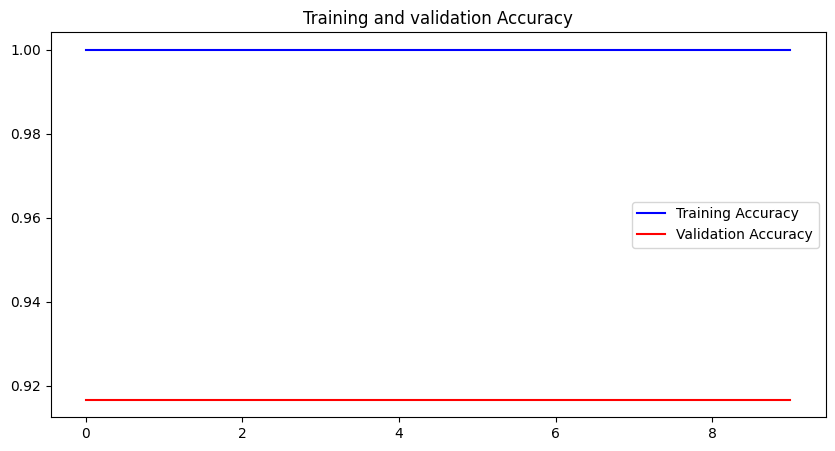

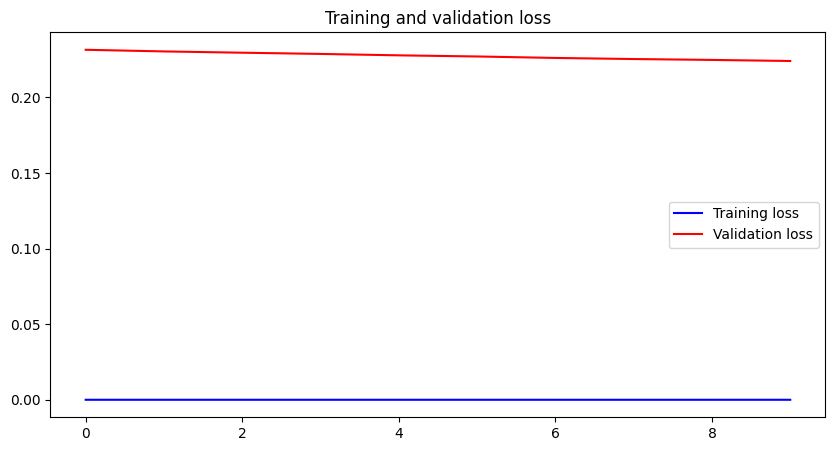

1/1 [==============================] - 0s 137ms/step - loss: 0.2241 - accuracy: 0.9167
Epoch 1/10
11/11 [==============================] - 6s 555ms/step - loss: 8.9112e-06 - accuracy: 1.0000 - val_loss: 0.4572 - val_accuracy: 0.9167
Epoch 2/10
11/11 [==============================] - 6s 558ms/step - loss: 9.0501e-06 - accuracy: 1.0000 - val_loss: 0.4564 - val_accuracy: 0.9167
Epoch 3/10
11/11 [==============================] - 6s 561ms/step - loss: 8.5084e-06 - accuracy: 1.0000 - val_loss: 0.4562 - val_accuracy: 0.9167
Epoch 4/10
11/11 [==============================] - 6s 571ms/step - loss: 7.1024e-06 - accuracy: 1.0000 - val_loss: 0.4560 - val_accuracy: 0.9167
Epoch 5/10
11/11 [==============================] - 6s 578ms/step - loss: 6.1367e-06 - accuracy: 1.0000 - val_loss: 0.4555 - val_accuracy: 0.9167
Epoch 6/10
11/11 [==============================] - 6s 581ms/step - loss: 6.0529e-06 - accuracy: 1.0000 - val_loss: 0.4550 - val_accuracy: 0.9167
Epoch 7/10
11/11 [===================

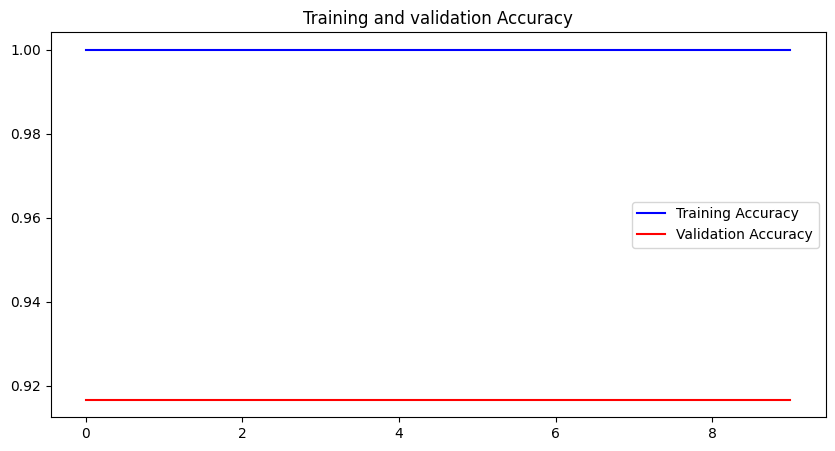

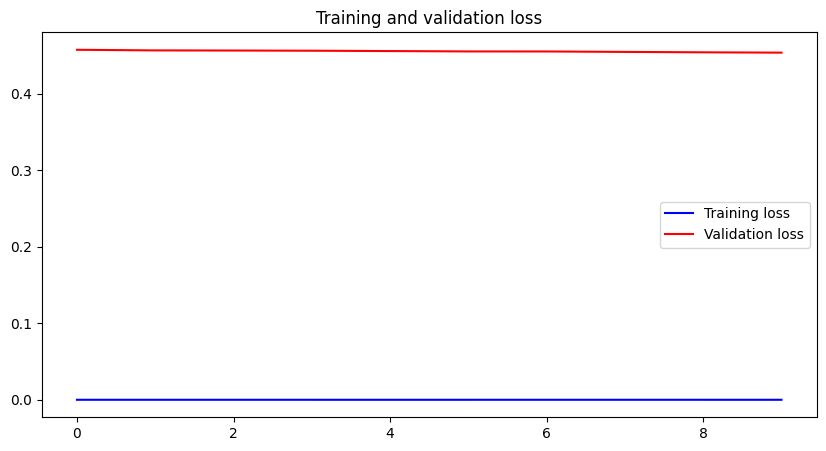

1/1 [==============================] - 0s 145ms/step - loss: 0.4536 - accuracy: 0.9167
Epoch 1/10
11/11 [==============================] - 6s 556ms/step - loss: 8.1156e-06 - accuracy: 1.0000 - val_loss: 1.3762 - val_accuracy: 0.8333
Epoch 2/10
11/11 [==============================] - 6s 555ms/step - loss: 6.3067e-06 - accuracy: 1.0000 - val_loss: 1.3754 - val_accuracy: 0.8333
Epoch 3/10
11/11 [==============================] - 6s 555ms/step - loss: 6.4193e-06 - accuracy: 1.0000 - val_loss: 1.3747 - val_accuracy: 0.8333
Epoch 4/10
11/11 [==============================] - 6s 558ms/step - loss: 5.7229e-06 - accuracy: 1.0000 - val_loss: 1.3736 - val_accuracy: 0.8333
Epoch 5/10
11/11 [==============================] - 6s 560ms/step - loss: 6.8938e-06 - accuracy: 1.0000 - val_loss: 1.3727 - val_accuracy: 0.8333
Epoch 6/10
11/11 [==============================] - 6s 563ms/step - loss: 6.4723e-06 - accuracy: 1.0000 - val_loss: 1.3722 - val_accuracy: 0.8333
Epoch 7/10
11/11 [===================

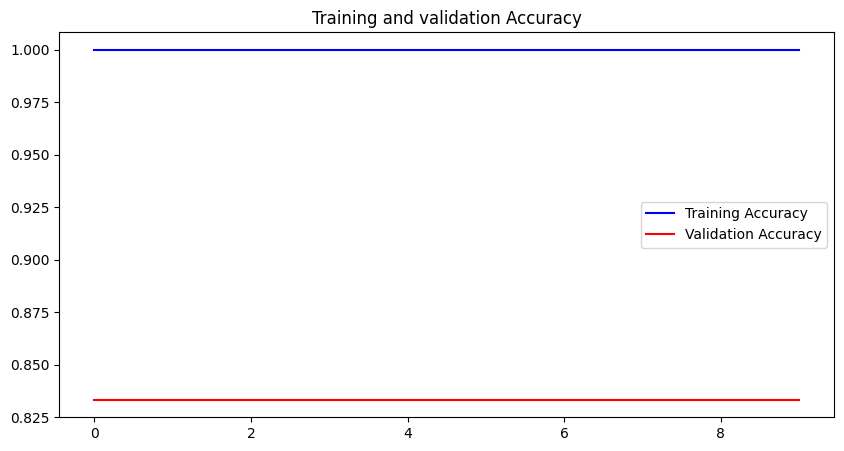

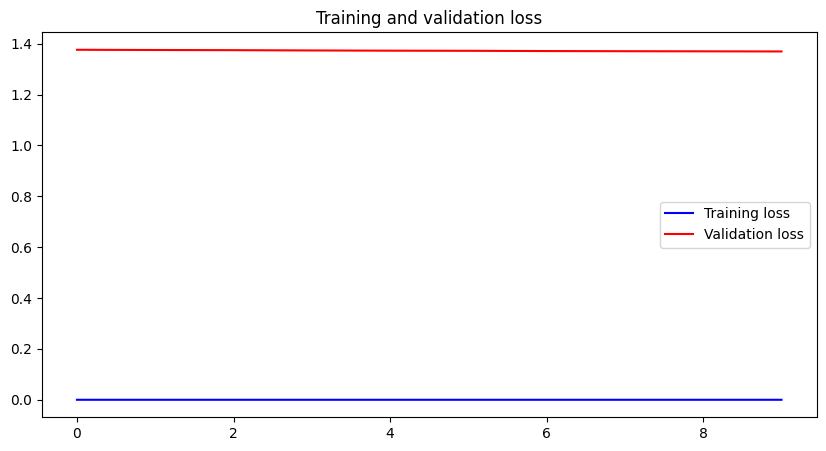

1/1 [==============================] - 0s 140ms/step - loss: 1.3696 - accuracy: 0.8333
Epoch 1/10
11/11 [==============================] - 6s 564ms/step - loss: 3.2825e-06 - accuracy: 1.0000 - val_loss: 8.8049e-05 - val_accuracy: 1.0000
Epoch 2/10
11/11 [==============================] - 6s 562ms/step - loss: 4.8188e-06 - accuracy: 1.0000 - val_loss: 8.8883e-05 - val_accuracy: 1.0000
Epoch 3/10
11/11 [==============================] - 6s 560ms/step - loss: 4.1942e-06 - accuracy: 1.0000 - val_loss: 8.9786e-05 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 6s 560ms/step - loss: 3.9017e-06 - accuracy: 1.0000 - val_loss: 9.0570e-05 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 6s 558ms/step - loss: 3.2119e-06 - accuracy: 1.0000 - val_loss: 9.1274e-05 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 6s 559ms/step - loss: 3.9955e-06 - accuracy: 1.0000 - val_loss: 9.2217e-05 - val_accuracy: 1.0000
Epoch 7/10
11

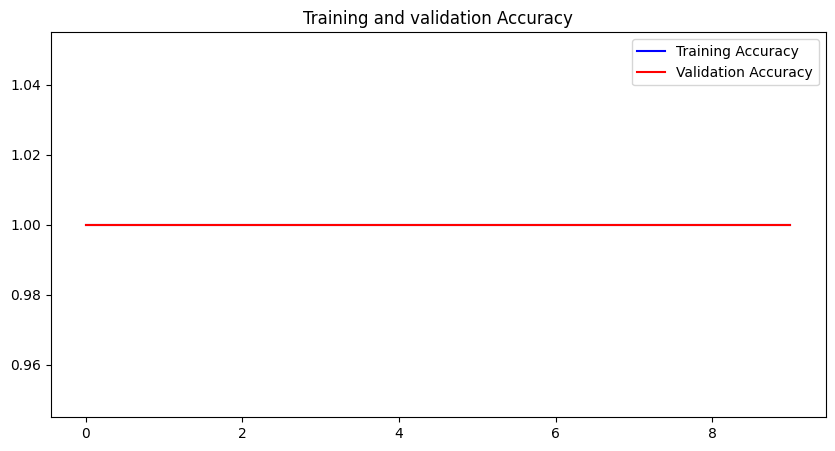

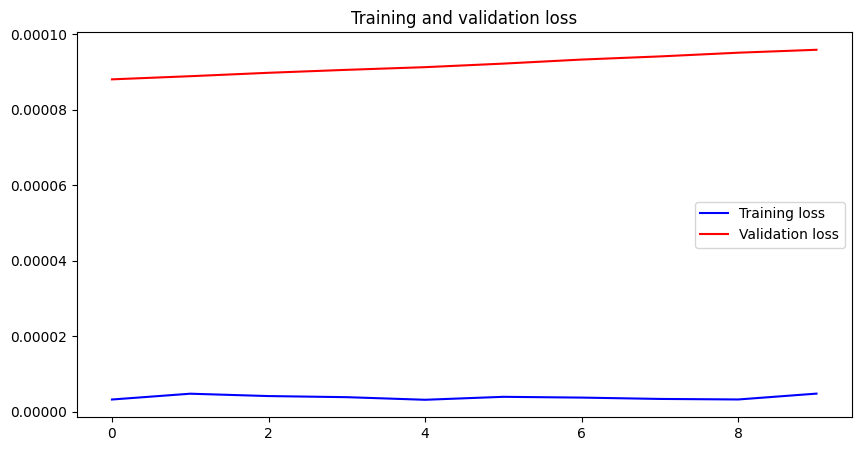

1/1 [==============================] - 0s 139ms/step - loss: 9.5889e-05 - accuracy: 1.0000
Epoch 1/10
11/11 [==============================] - 6s 563ms/step - loss: 6.3199e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
11/11 [==============================] - 6s 562ms/step - loss: 4.4525e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
11/11 [==============================] - 6s 562ms/step - loss: 4.9999e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 6s 563ms/step - loss: 3.5728e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 6s 563ms/step - loss: 5.3619e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 6s 562ms/step - loss: 4.0806e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/1

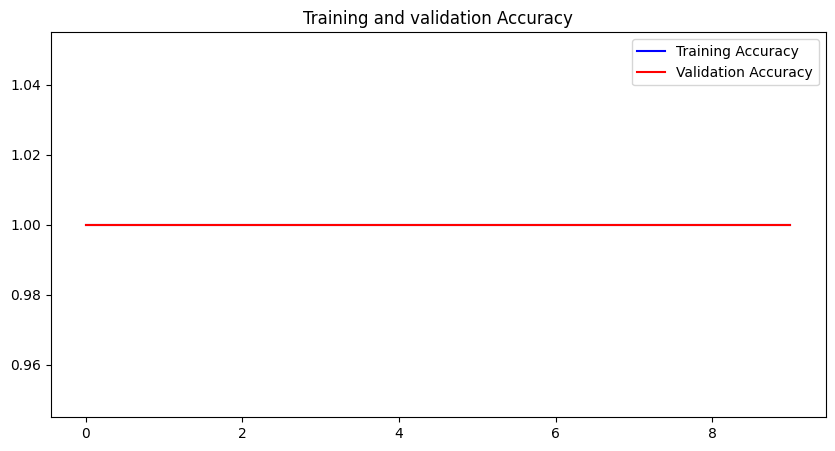

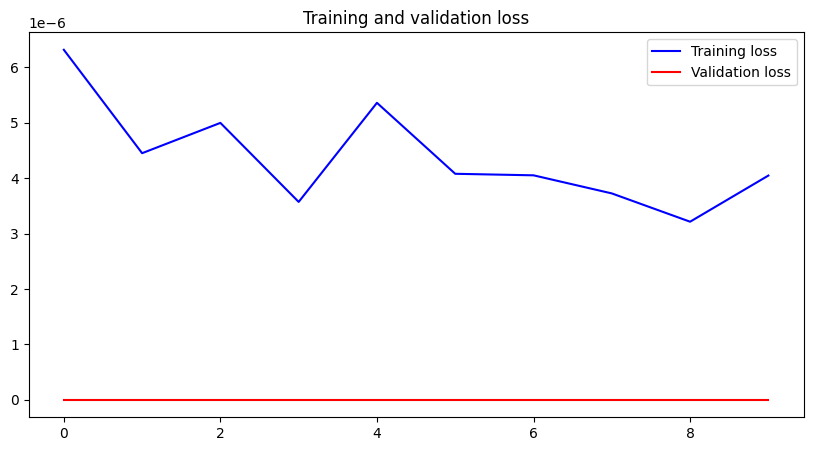

1/1 [==============================] - 0s 138ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1/10
11/11 [==============================] - 6s 562ms/step - loss: 3.5872e-06 - accuracy: 1.0000 - val_loss: 0.0295 - val_accuracy: 1.0000
Epoch 2/10
11/11 [==============================] - 6s 560ms/step - loss: 3.6016e-06 - accuracy: 1.0000 - val_loss: 0.0294 - val_accuracy: 1.0000
Epoch 3/10
11/11 [==============================] - 6s 559ms/step - loss: 3.3378e-06 - accuracy: 1.0000 - val_loss: 0.0294 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 6s 561ms/step - loss: 3.2980e-06 - accuracy: 1.0000 - val_loss: 0.0294 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 6s 562ms/step - loss: 3.5066e-06 - accuracy: 1.0000 - val_loss: 0.0293 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 6s 562ms/step - loss: 3.3499e-06 - accuracy: 1.0000 - val_loss: 0.0292 - val_accuracy: 1.0000
Epoch 7/10
11/11 [===============

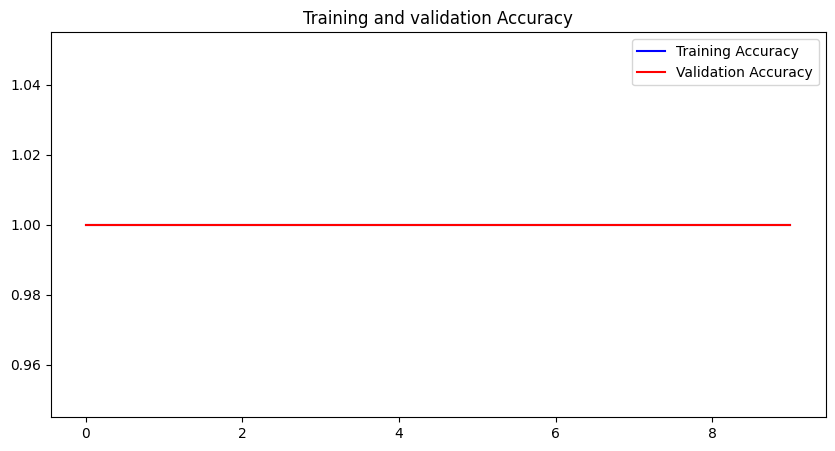

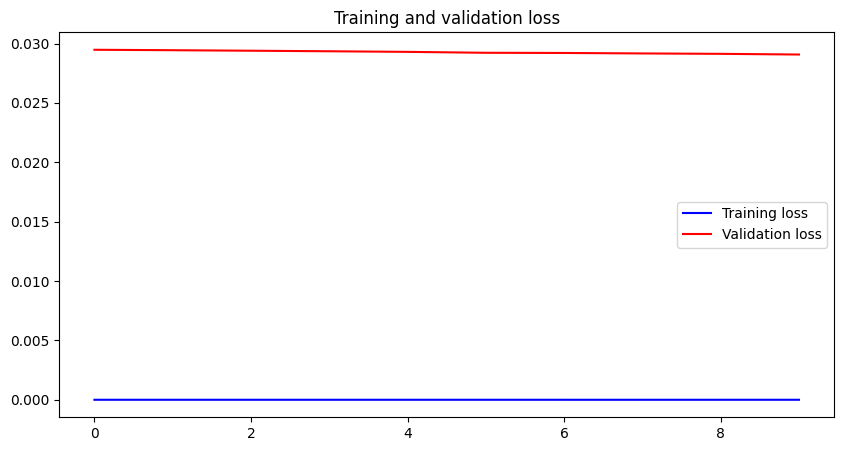

1/1 [==============================] - 0s 138ms/step - loss: 0.0291 - accuracy: 1.0000
Epoch 1/10
11/11 [==============================] - 6s 561ms/step - loss: 3.3753e-06 - accuracy: 1.0000 - val_loss: 0.1241 - val_accuracy: 0.9167
Epoch 2/10
11/11 [==============================] - 6s 560ms/step - loss: 2.9404e-06 - accuracy: 1.0000 - val_loss: 0.1236 - val_accuracy: 0.9167
Epoch 3/10
11/11 [==============================] - 6s 560ms/step - loss: 2.7892e-06 - accuracy: 1.0000 - val_loss: 0.1233 - val_accuracy: 0.9167
Epoch 4/10
11/11 [==============================] - 6s 562ms/step - loss: 3.4525e-06 - accuracy: 1.0000 - val_loss: 0.1230 - val_accuracy: 0.9167
Epoch 5/10
11/11 [==============================] - 6s 562ms/step - loss: 3.2859e-06 - accuracy: 1.0000 - val_loss: 0.1229 - val_accuracy: 0.9167
Epoch 6/10
11/11 [==============================] - 6s 562ms/step - loss: 3.3720e-06 - accuracy: 1.0000 - val_loss: 0.1224 - val_accuracy: 0.9167
Epoch 7/10
11/11 [===================

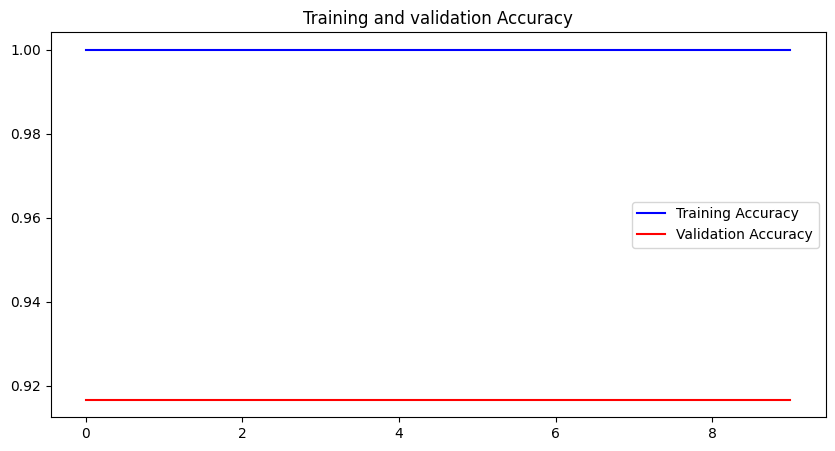

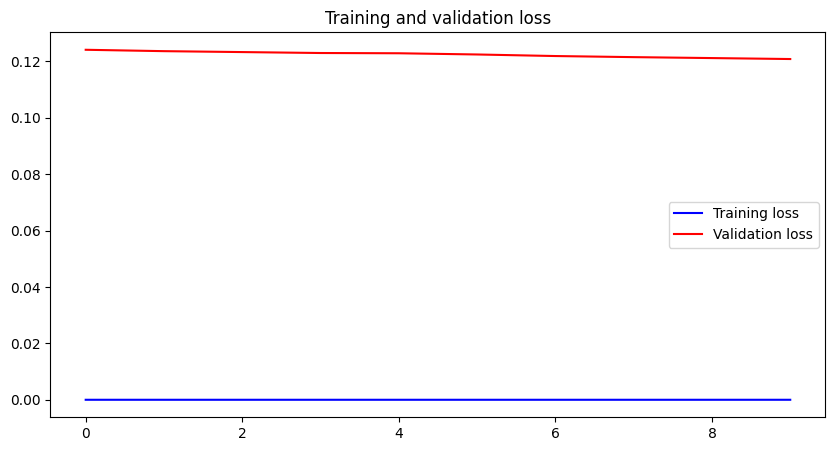

1/1 [==============================] - 0s 140ms/step - loss: 0.1208 - accuracy: 0.9167


In [32]:
weights_list = []

accuracy_train = []
loss_train = []

accuracy_val = []
loss_val = []

# Iterate over the folds
for train_indices, val_indices in kfold.split(cnn_images): # labels
    history_model_cnn_unet = model_cnn_unet.fit(data_norm(cnn_images[train_indices]), labels[train_indices],
                       validation_data=(data_norm(cnn_images[val_indices]), labels[val_indices]),
                       epochs=10,
                       batch_size=batch_size,
                       verbose=1
                       )

    plot_cnn_history(history_model_cnn_unet)

    train_loss, train_accuracy = model_cnn_unet.evaluate(data_norm(cnn_images[train_indices]), labels[train_indices])
    accuracy_train.append(train_accuracy)
    loss_train.append(train_loss)

    val_loss, val_accuracy = model_cnn_unet.evaluate(data_norm(cnn_images[val_indices]), labels[val_indices])
    accuracy_val.append(val_accuracy)
    loss_val.append(val_loss)

    weights_list.append(model_cnn_unet.get_weights())


In [33]:
# previous
# Average Accuracy: 0.9666666686534882
# Average Loss: 0.10274658729540534

print("Average Accuracy:", np.mean(accuracy_val))
print("Maximum Accuracy:", np.max(accuracy_val))
print("Average Loss:", np.mean(loss_val))
print("Minimum Loss:", np.min(loss_val))

Average Accuracy: 0.9333333373069763
Maximum Accuracy: 1.0
Average Loss: 0.5112040673307007
Minimum Loss: 0.0


On some folds we still see overfitting but on the others underfitting. The average result is worse the original.

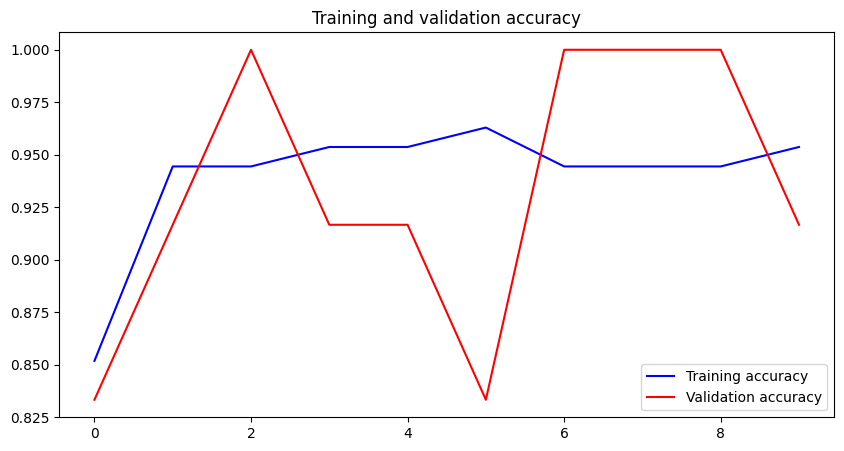

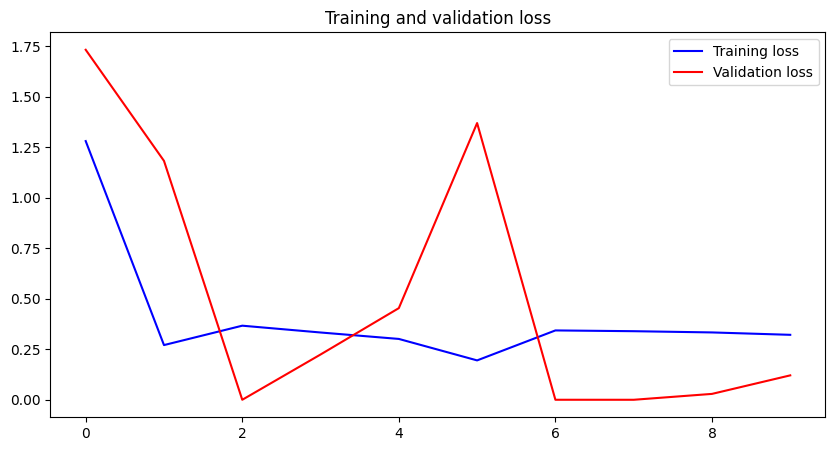

In [34]:
plot_cnn_folds(accuracy_train, accuracy_val, loss_train, loss_val)

In [35]:
cnn_images_test, cnn_images_rest, labels_test_test, labels_test_rest  = train_test_split(cnn_test_images, labels_test, train_size=0.5)

print('cnn_images_test shape:', cnn_images_test.shape)
print('labels_test_test shape:', labels_test_test.shape, end='\n\n')

cnn_images_test shape: (60, 256, 256, 3)
labels_test_test shape: (60, 3)



In [36]:
# Average the weights
average_weights = np.mean(weights_list, axis=0)

model_cnn_unet.set_weights(average_weights)

test_loss, test_accuracy = model_cnn_unet.evaluate(data_norm(cnn_images_test), labels_test_test)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

# previous
# Average Accuracy: 0.9666666686534882
# Average Loss: 0.10274658729540534
# Test Accuracy: 0.8500000238418579
# Test Loss: 0.4985653758049011

2/2 [==============================] - 16s 16s/step - loss: 3.0954 - accuracy: 0.7167
Test Accuracy: 0.7166666388511658
Test Loss: 3.0954172611236572


In [37]:
cnn_images_test, cnn_images_rest, labels_test_test, labels_test_rest  = train_test_split(cnn_test_images, labels_test, train_size=0.5)

test_loss, test_accuracy = model_cnn_unet.evaluate(data_norm(cnn_images_test), labels_test_test)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

2/2 [==============================] - 1s 256ms/step - loss: 3.0077 - accuracy: 0.7500
Test Accuracy: 0.75
Test Loss: 3.0077106952667236


But results got worse.

## Fully Conv idea upon unet

In [38]:
from tensorflow.keras.layers import GlobalAveragePooling2D

In [39]:
K.clear_session()

In [40]:
# Load the trained CAE model
best_model_cae = load_model('/content/drive/MyDrive/art_recognition_tech/best_model_cae_unet.hdf5') # h5

# Remove the decoder layers of the CAE
encoder_model = Sequential(best_model_cae.layers[:9]) # decoder_layers_to_remove

# for fine-tuning purpose, we truncate the original softmax layer and replace it with our own
#encoder_model.layers.pop()
#encoder_model.outputs = [encoder_model.layers[-11].output]
#encoder_model.layers[-11].outbound_nodes = []

'''
Since in #1 we have popped the last layer, which is the original output layer,
we need to update the destination of the output layer.
#2 is to reset the last layer of encoder part as the output layer.
#3 is to say the last layer of encoder part should not have anymore connections to the popped layer,
since it is now the output layer.
'''

encoder_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 256, 256, 100)     7600      
                                                                 
 dropout (Dropout)           (None, 256, 256, 100)     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 100)     250100    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 100)    0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 200)     500200    
                                                                 
 dropout_1 (Dropout)         (None, 128, 128, 200)     0         
                                                        

In [41]:
# CNN model
inputs = Input(input_shape)

# Encoder part
c1 = Conv2D(100, (5, 5), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
d1 = Dropout(0.1) (c1)
c1 = Conv2D(100, (5, 5), activation='elu', kernel_initializer='he_normal', padding='same') (d1)
p1 = MaxPooling2D(pool_size=(2,2)) (c1)

c2 = Conv2D(200, (5, 5), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
d2 = Dropout(0.2) (c2)
c2 = Conv2D(200, (5, 5), activation='elu', kernel_initializer='he_normal', padding='same') (d2)
p2 = MaxPooling2D(pool_size=(2, 2)) (c2)

# CNN part
c3 = Conv2D(400, (1, 1), activation='relu') (p2)
c4 = Conv2D(200, (1, 1), activation='relu') (c3)
p3 = GlobalAveragePooling2D()(c4)  # Add this layer to convert spatial dimensions to a single dimension
# c5 = Conv2D(CLASS_NUM, (64, 64), activation='relu') (c4) # instead of GlobalAveragePooling2D
# f1 = Flatten() (c5)

outputs = Dense(CLASS_NUM, activation='softmax') (p3)
# outputs = Conv2D(CLASS_NUM, (1, 1), activation='softmax') (f1) # without GlobalAveragePooling2D

model_cnn_full = Model(inputs=[inputs], outputs=[outputs])

model_cnn_full.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 100)     7600      
                                                                 
 dropout (Dropout)           (None, 256, 256, 100)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 100)     250100    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 100)    0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 200)     500200    
                                                             

In [42]:
for i, layer in enumerate(encoder_model.layers):
  print(i, '->', layer.name)

0 -> conv2d_2
1 -> dropout
2 -> conv2d_3
3 -> max_pooling2d_2
4 -> conv2d_4
5 -> dropout_1
6 -> conv2d_5
7 -> max_pooling2d_3


In [43]:
for i, layer in enumerate(model_cnn_full.layers):
  print(i, '->', layer.name)

0 -> input_1
1 -> conv2d
2 -> dropout
3 -> conv2d_1
4 -> max_pooling2d
5 -> conv2d_2
6 -> dropout_1
7 -> conv2d_3
8 -> max_pooling2d_1
9 -> conv2d_4
10 -> conv2d_5
11 -> global_average_pooling2d
12 -> dense


In [44]:
# Initialize the CNN with CAE weights
for i, layer in enumerate(encoder_model.layers):
  model_cnn_full.layers[i+1].set_weights(layer.get_weights())

In [46]:
# Compile the model
model_cnn_full.compile(optimizer=Adam(0.0001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

Epoch 1/10
11/11 [==============================] - 8s 551ms/step - loss: 0.9401 - accuracy: 0.4722 - val_loss: 0.7202 - val_accuracy: 0.5833
Epoch 2/10
11/11 [==============================] - 6s 519ms/step - loss: 0.7608 - accuracy: 0.6481 - val_loss: 0.5619 - val_accuracy: 0.7500
Epoch 3/10
11/11 [==============================] - 6s 521ms/step - loss: 0.7247 - accuracy: 0.6481 - val_loss: 0.5618 - val_accuracy: 0.8333
Epoch 4/10
11/11 [==============================] - 6s 528ms/step - loss: 0.6743 - accuracy: 0.6759 - val_loss: 0.7077 - val_accuracy: 0.5000
Epoch 5/10
11/11 [==============================] - 6s 531ms/step - loss: 0.6214 - accuracy: 0.7130 - val_loss: 0.5414 - val_accuracy: 0.8333
Epoch 6/10
11/11 [==============================] - 6s 527ms/step - loss: 0.5895 - accuracy: 0.7222 - val_loss: 0.7107 - val_accuracy: 0.6667
Epoch 7/10
11/11 [==============================] - 6s 520ms/step - loss: 0.5664 - accuracy: 0.7870 - val_loss: 0.7205 - val_accuracy: 0.5833
Epoch 

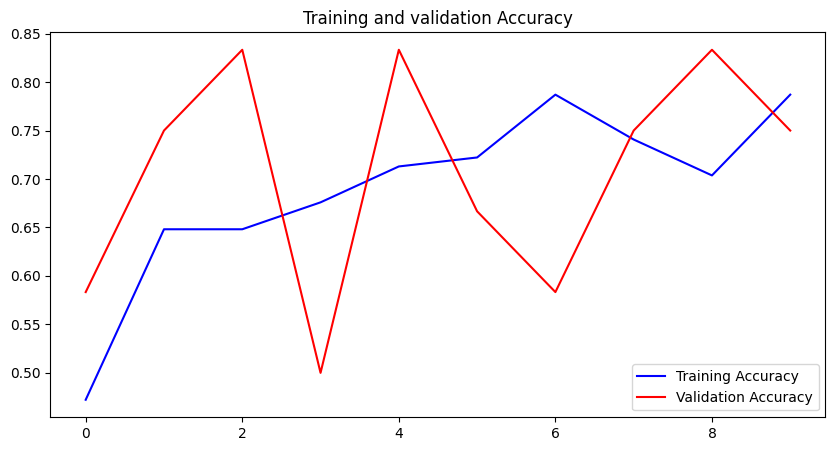

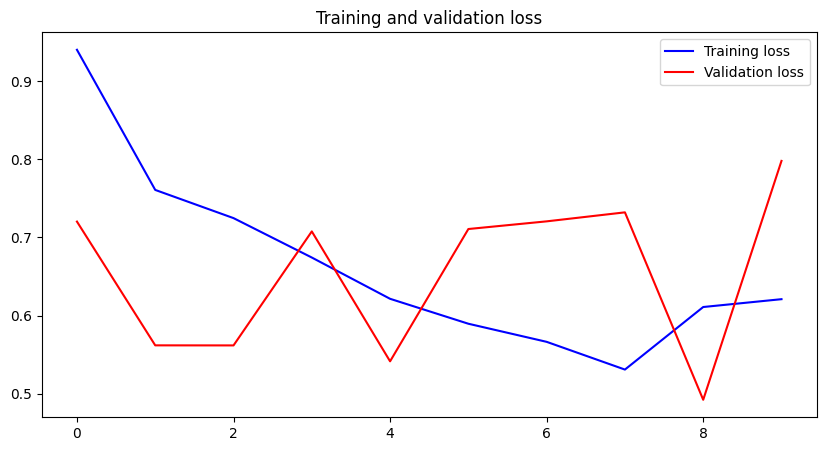

1/1 [==============================] - 0s 137ms/step - loss: 0.7979 - accuracy: 0.7500
Epoch 1/10
11/11 [==============================] - 6s 513ms/step - loss: 0.6011 - accuracy: 0.7685 - val_loss: 0.3768 - val_accuracy: 0.8333
Epoch 2/10
11/11 [==============================] - 6s 510ms/step - loss: 0.5118 - accuracy: 0.7593 - val_loss: 0.4455 - val_accuracy: 0.8333
Epoch 3/10
11/11 [==============================] - 6s 510ms/step - loss: 0.5068 - accuracy: 0.8056 - val_loss: 0.4131 - val_accuracy: 0.8333
Epoch 4/10
11/11 [==============================] - 6s 513ms/step - loss: 0.4908 - accuracy: 0.8148 - val_loss: 0.5041 - val_accuracy: 0.8333
Epoch 5/10
11/11 [==============================] - 6s 513ms/step - loss: 0.5403 - accuracy: 0.7593 - val_loss: 0.3805 - val_accuracy: 0.8333
Epoch 6/10
11/11 [==============================] - 6s 516ms/step - loss: 0.5238 - accuracy: 0.8056 - val_loss: 0.3954 - val_accuracy: 0.8333
Epoch 7/10
11/11 [==============================] - 6s 517ms/

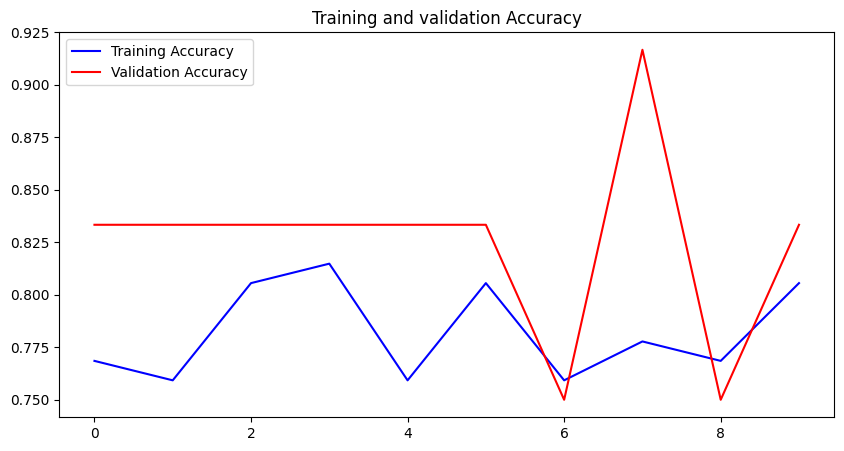

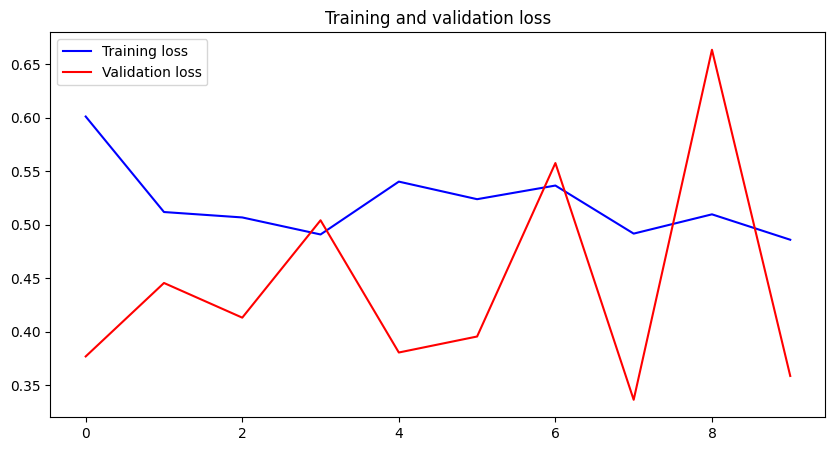

1/1 [==============================] - 0s 140ms/step - loss: 0.3585 - accuracy: 0.8333
Epoch 1/10
11/11 [==============================] - 6s 518ms/step - loss: 0.4600 - accuracy: 0.7963 - val_loss: 1.0994 - val_accuracy: 0.5833
Epoch 2/10
11/11 [==============================] - 6s 516ms/step - loss: 0.4040 - accuracy: 0.8148 - val_loss: 1.3577 - val_accuracy: 0.6667
Epoch 3/10
11/11 [==============================] - 6s 515ms/step - loss: 0.4173 - accuracy: 0.8519 - val_loss: 1.2349 - val_accuracy: 0.5833
Epoch 4/10
11/11 [==============================] - 6s 514ms/step - loss: 0.4170 - accuracy: 0.8519 - val_loss: 0.9972 - val_accuracy: 0.7500
Epoch 5/10
11/11 [==============================] - 6s 516ms/step - loss: 0.4129 - accuracy: 0.8333 - val_loss: 0.9240 - val_accuracy: 0.6667
Epoch 6/10
11/11 [==============================] - 6s 514ms/step - loss: 0.4719 - accuracy: 0.8241 - val_loss: 1.3217 - val_accuracy: 0.4167
Epoch 7/10
11/11 [==============================] - 6s 515ms/

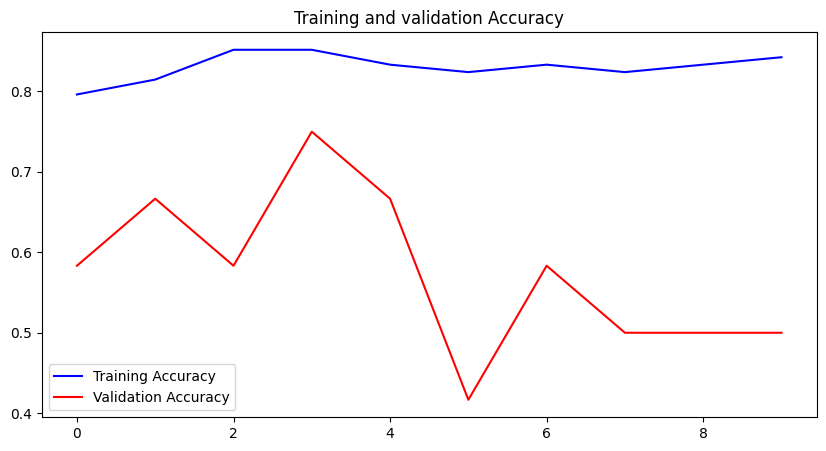

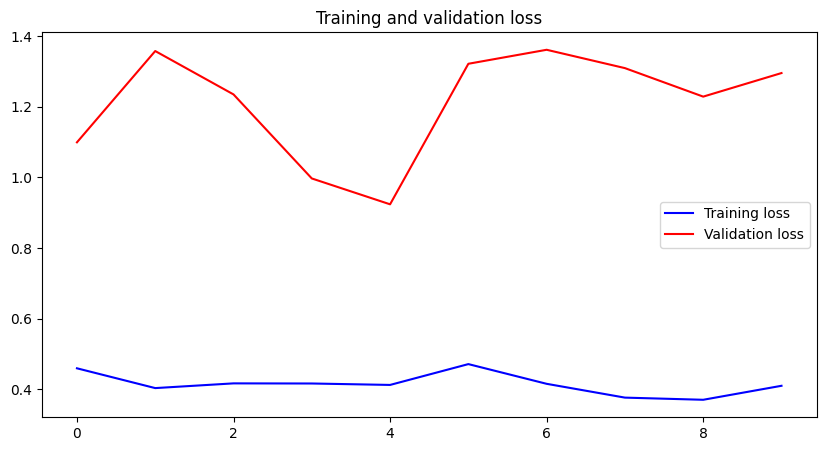

1/1 [==============================] - 0s 143ms/step - loss: 1.2954 - accuracy: 0.5000
Epoch 1/10
11/11 [==============================] - 6s 517ms/step - loss: 0.4885 - accuracy: 0.8241 - val_loss: 0.3771 - val_accuracy: 0.8333
Epoch 2/10
11/11 [==============================] - 6s 514ms/step - loss: 0.4653 - accuracy: 0.8056 - val_loss: 0.4126 - val_accuracy: 0.8333
Epoch 3/10
11/11 [==============================] - 6s 515ms/step - loss: 0.4237 - accuracy: 0.8056 - val_loss: 0.5515 - val_accuracy: 0.8333
Epoch 4/10
11/11 [==============================] - 6s 515ms/step - loss: 0.4691 - accuracy: 0.7963 - val_loss: 0.4572 - val_accuracy: 0.7500
Epoch 5/10
11/11 [==============================] - 6s 517ms/step - loss: 0.3961 - accuracy: 0.8426 - val_loss: 0.4107 - val_accuracy: 0.8333
Epoch 6/10
11/11 [==============================] - 6s 517ms/step - loss: 0.4295 - accuracy: 0.8426 - val_loss: 0.4458 - val_accuracy: 0.9167
Epoch 7/10
11/11 [==============================] - 6s 517ms/

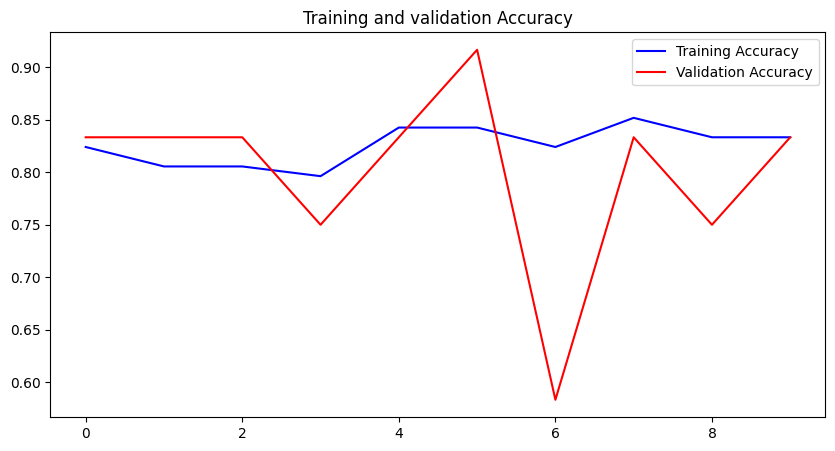

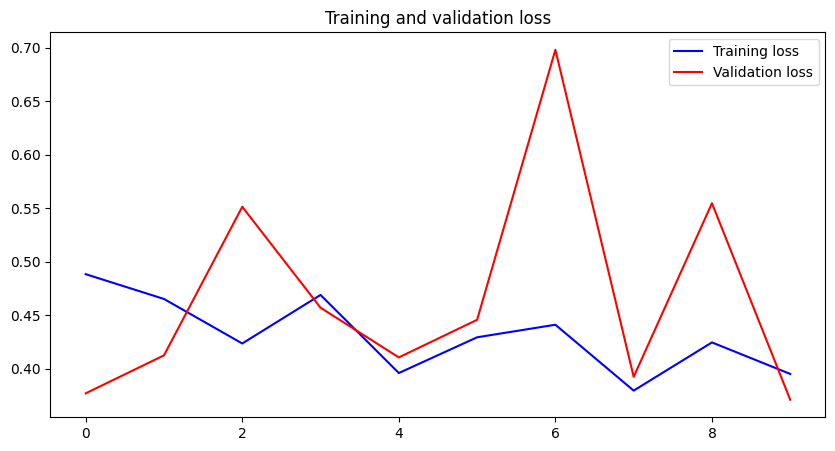

1/1 [==============================] - 0s 141ms/step - loss: 0.3711 - accuracy: 0.8333
Epoch 1/10
11/11 [==============================] - 6s 517ms/step - loss: 0.3671 - accuracy: 0.8519 - val_loss: 0.4032 - val_accuracy: 0.8333
Epoch 2/10
11/11 [==============================] - 6s 514ms/step - loss: 0.3939 - accuracy: 0.8704 - val_loss: 0.3618 - val_accuracy: 0.8333
Epoch 3/10
11/11 [==============================] - 6s 514ms/step - loss: 0.3442 - accuracy: 0.8889 - val_loss: 0.4314 - val_accuracy: 0.8333
Epoch 4/10
11/11 [==============================] - 6s 514ms/step - loss: 0.4076 - accuracy: 0.8426 - val_loss: 0.4359 - val_accuracy: 0.8333
Epoch 5/10
11/11 [==============================] - 6s 514ms/step - loss: 0.3233 - accuracy: 0.8981 - val_loss: 0.4590 - val_accuracy: 0.8333
Epoch 6/10
11/11 [==============================] - 6s 514ms/step - loss: 0.3592 - accuracy: 0.8426 - val_loss: 0.4567 - val_accuracy: 0.8333
Epoch 7/10
11/11 [==============================] - 6s 515ms/

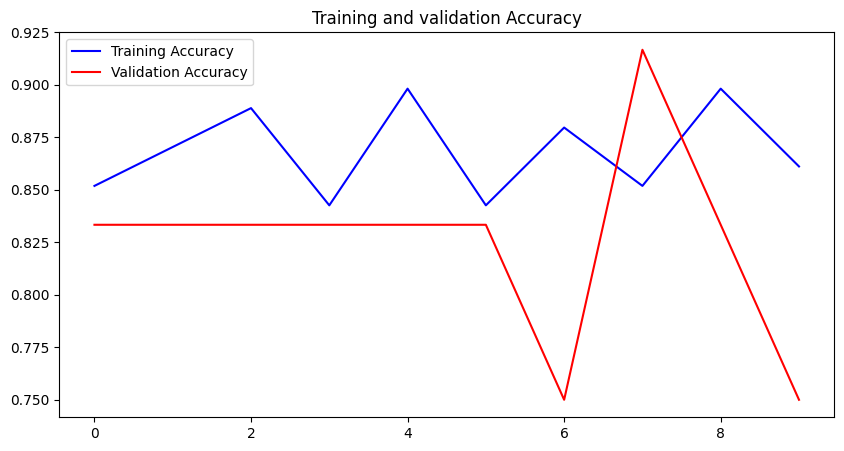

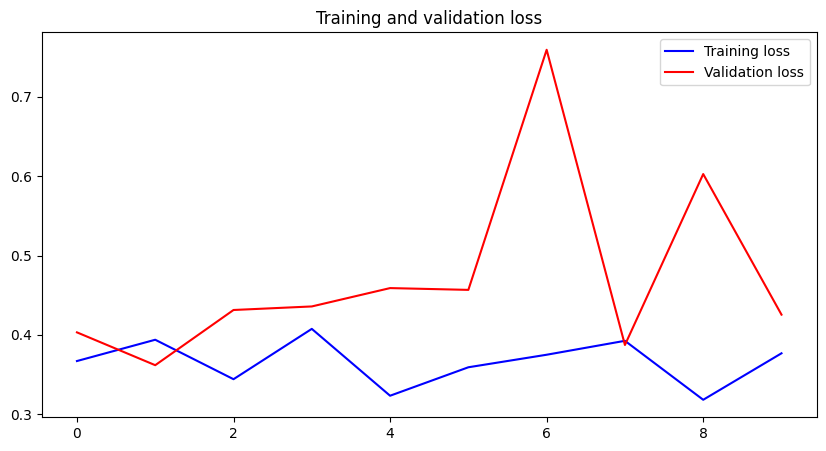

1/1 [==============================] - 0s 145ms/step - loss: 0.4255 - accuracy: 0.7500
Epoch 1/10
11/11 [==============================] - 6s 512ms/step - loss: 0.4813 - accuracy: 0.8241 - val_loss: 0.2524 - val_accuracy: 0.9167
Epoch 2/10
11/11 [==============================] - 6s 514ms/step - loss: 0.3784 - accuracy: 0.8148 - val_loss: 0.3053 - val_accuracy: 0.9167
Epoch 3/10
11/11 [==============================] - 6s 521ms/step - loss: 0.3723 - accuracy: 0.8519 - val_loss: 0.3841 - val_accuracy: 0.9167
Epoch 4/10
11/11 [==============================] - 6s 525ms/step - loss: 0.2836 - accuracy: 0.8796 - val_loss: 0.3202 - val_accuracy: 0.8333
Epoch 5/10
11/11 [==============================] - 6s 531ms/step - loss: 0.3926 - accuracy: 0.8333 - val_loss: 0.3599 - val_accuracy: 0.9167
Epoch 6/10
11/11 [==============================] - 6s 532ms/step - loss: 0.3581 - accuracy: 0.8426 - val_loss: 0.4172 - val_accuracy: 0.9167
Epoch 7/10
11/11 [==============================] - 6s 524ms/

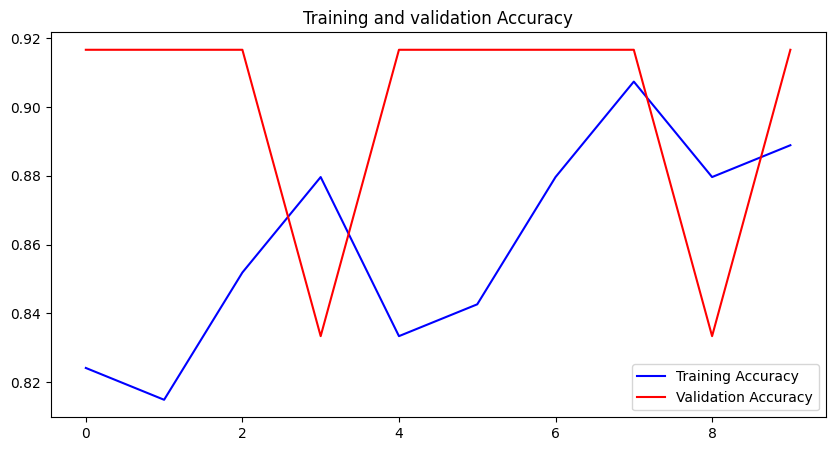

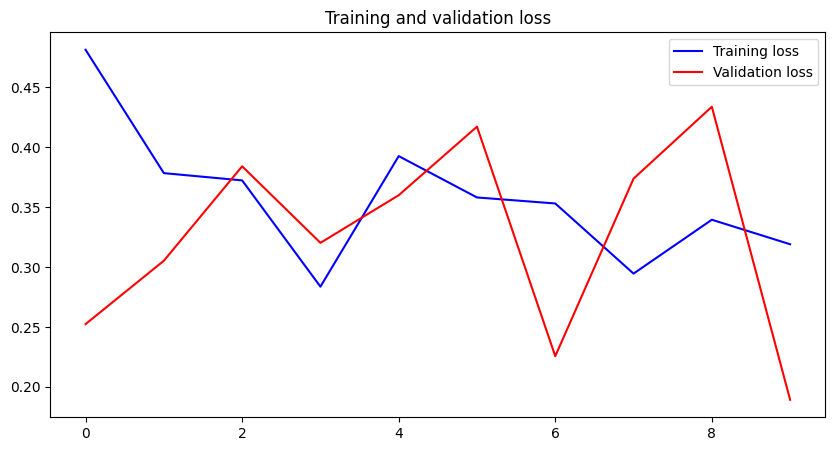

1/1 [==============================] - 0s 137ms/step - loss: 0.1892 - accuracy: 0.9167
Epoch 1/10
11/11 [==============================] - 6s 514ms/step - loss: 0.3094 - accuracy: 0.8796 - val_loss: 0.7948 - val_accuracy: 0.7500
Epoch 2/10
11/11 [==============================] - 6s 509ms/step - loss: 0.2645 - accuracy: 0.8889 - val_loss: 0.8909 - val_accuracy: 0.6667
Epoch 3/10
11/11 [==============================] - 6s 508ms/step - loss: 0.2923 - accuracy: 0.9074 - val_loss: 0.8600 - val_accuracy: 0.8333
Epoch 4/10
11/11 [==============================] - 6s 511ms/step - loss: 0.2501 - accuracy: 0.9167 - val_loss: 0.8532 - val_accuracy: 0.7500
Epoch 5/10
11/11 [==============================] - 6s 512ms/step - loss: 0.2522 - accuracy: 0.9074 - val_loss: 0.9463 - val_accuracy: 0.7500
Epoch 6/10
11/11 [==============================] - 6s 513ms/step - loss: 0.2214 - accuracy: 0.9259 - val_loss: 0.8036 - val_accuracy: 0.7500
Epoch 7/10
11/11 [==============================] - 6s 516ms/

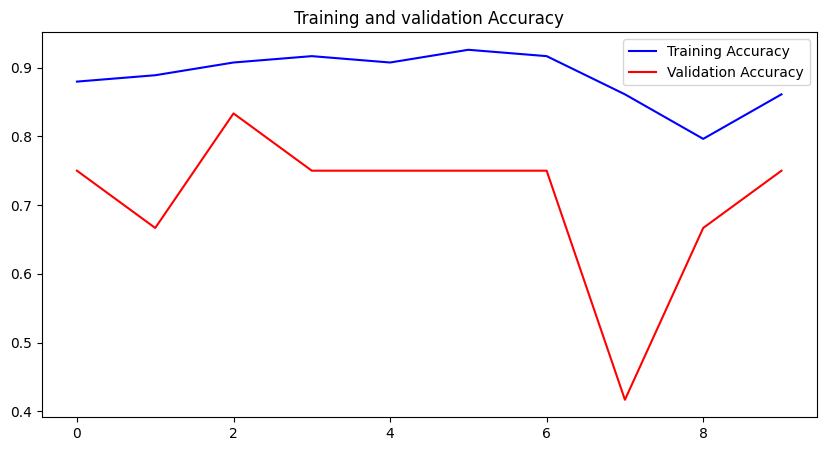

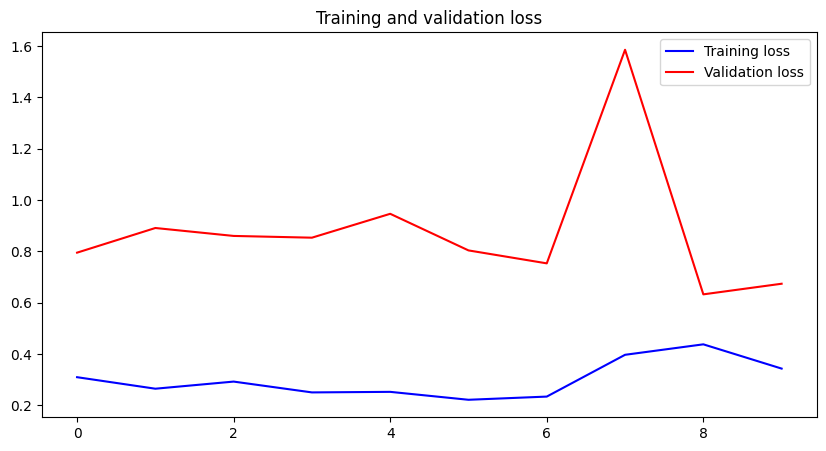

1/1 [==============================] - 0s 137ms/step - loss: 0.6737 - accuracy: 0.7500
Epoch 1/10
11/11 [==============================] - 6s 513ms/step - loss: 0.2982 - accuracy: 0.8796 - val_loss: 0.0786 - val_accuracy: 1.0000
Epoch 2/10
11/11 [==============================] - 6s 516ms/step - loss: 0.2972 - accuracy: 0.8519 - val_loss: 0.3941 - val_accuracy: 0.8333
Epoch 3/10
11/11 [==============================] - 6s 521ms/step - loss: 0.3023 - accuracy: 0.8704 - val_loss: 0.0828 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 6s 526ms/step - loss: 0.3261 - accuracy: 0.8333 - val_loss: 0.3314 - val_accuracy: 0.8333
Epoch 5/10
11/11 [==============================] - 6s 532ms/step - loss: 0.3429 - accuracy: 0.8704 - val_loss: 0.1115 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 6s 531ms/step - loss: 0.2407 - accuracy: 0.9259 - val_loss: 0.1607 - val_accuracy: 0.9167
Epoch 7/10
11/11 [==============================] - 6s 521ms/

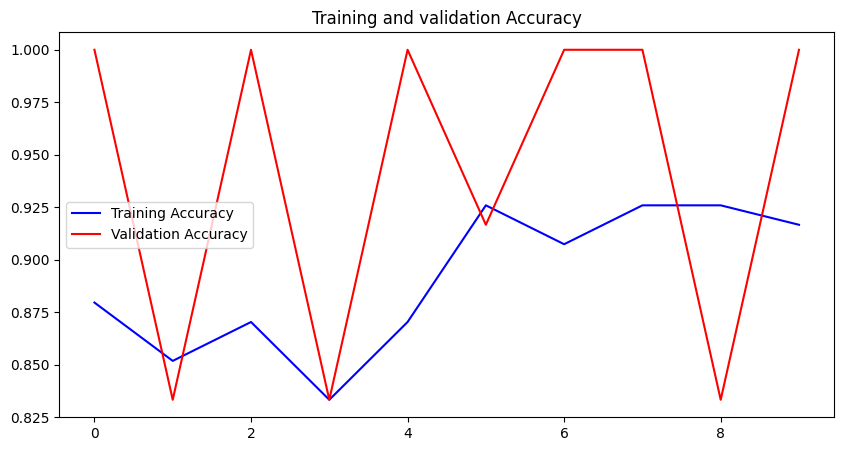

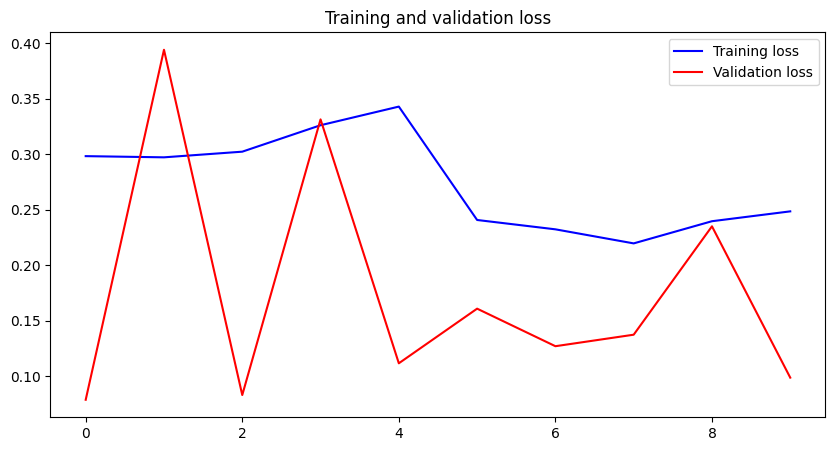

1/1 [==============================] - 0s 135ms/step - loss: 0.0985 - accuracy: 1.0000
Epoch 1/10
11/11 [==============================] - 6s 506ms/step - loss: 0.1843 - accuracy: 0.9630 - val_loss: 0.2979 - val_accuracy: 0.9167
Epoch 2/10
11/11 [==============================] - 6s 507ms/step - loss: 0.1876 - accuracy: 0.9352 - val_loss: 0.3073 - val_accuracy: 0.8333
Epoch 3/10
11/11 [==============================] - 6s 512ms/step - loss: 0.2094 - accuracy: 0.9167 - val_loss: 0.3743 - val_accuracy: 0.8333
Epoch 4/10
11/11 [==============================] - 6s 519ms/step - loss: 0.2803 - accuracy: 0.9074 - val_loss: 0.3066 - val_accuracy: 0.8333
Epoch 5/10
11/11 [==============================] - 6s 523ms/step - loss: 0.2251 - accuracy: 0.9074 - val_loss: 0.3225 - val_accuracy: 0.8333
Epoch 6/10
11/11 [==============================] - 6s 531ms/step - loss: 0.2075 - accuracy: 0.9167 - val_loss: 0.3634 - val_accuracy: 0.8333
Epoch 7/10
11/11 [==============================] - 6s 531ms/

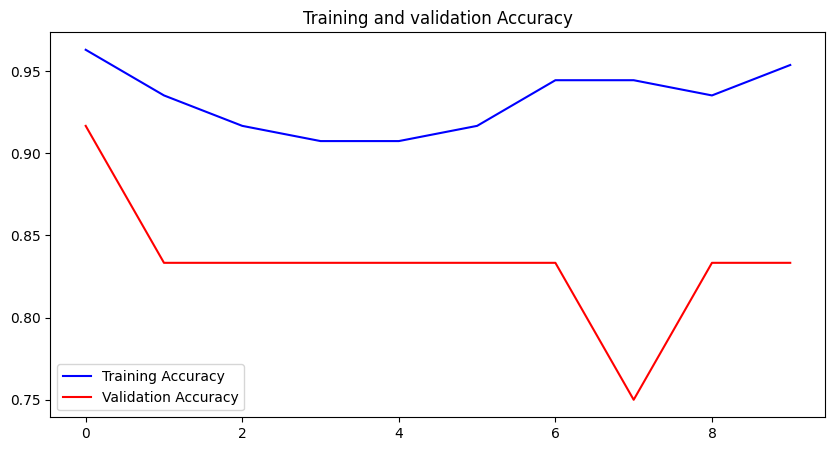

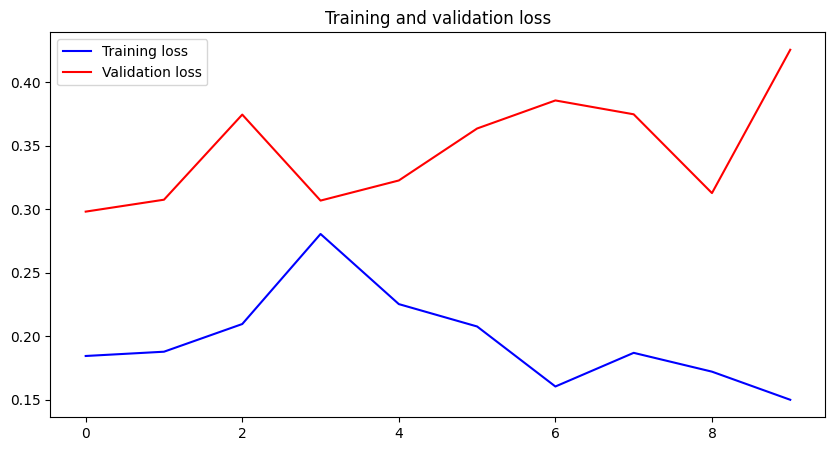

1/1 [==============================] - 0s 135ms/step - loss: 0.4254 - accuracy: 0.8333
Epoch 1/10
11/11 [==============================] - 6s 506ms/step - loss: 0.1857 - accuracy: 0.9259 - val_loss: 0.3475 - val_accuracy: 0.8333
Epoch 2/10
11/11 [==============================] - 6s 508ms/step - loss: 0.1835 - accuracy: 0.9352 - val_loss: 0.5459 - val_accuracy: 0.7500
Epoch 3/10
11/11 [==============================] - 6s 513ms/step - loss: 0.1882 - accuracy: 0.9352 - val_loss: 0.4181 - val_accuracy: 0.9167
Epoch 4/10
11/11 [==============================] - 6s 519ms/step - loss: 0.2505 - accuracy: 0.8889 - val_loss: 0.7196 - val_accuracy: 0.7500
Epoch 5/10
11/11 [==============================] - 6s 523ms/step - loss: 0.2245 - accuracy: 0.9259 - val_loss: 0.3850 - val_accuracy: 0.9167
Epoch 6/10
11/11 [==============================] - 6s 530ms/step - loss: 0.2753 - accuracy: 0.8889 - val_loss: 0.6297 - val_accuracy: 0.9167
Epoch 7/10
11/11 [==============================] - 6s 531ms/

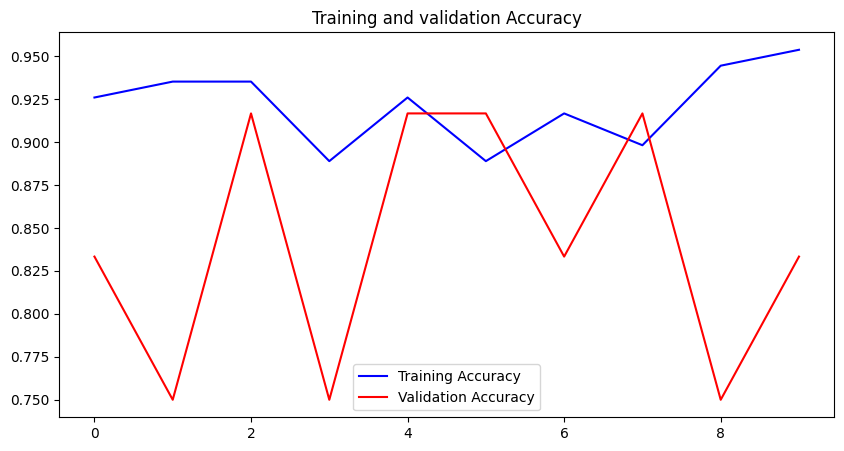

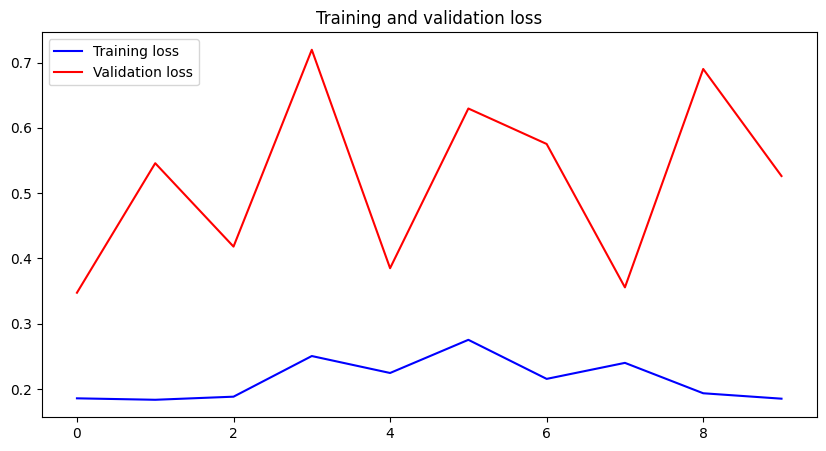

1/1 [==============================] - 0s 140ms/step - loss: 0.5262 - accuracy: 0.8333


In [47]:
weights_list = []

accuracy_train = []
loss_train = []

accuracy_val = []
loss_val = []

# Iterate over the folds
for train_indices, val_indices in kfold.split(cnn_images): # labels
    history_model_cnn_full = model_cnn_full.fit(data_norm(cnn_images[train_indices]), labels[train_indices],
                       validation_data=(data_norm(cnn_images[val_indices]), labels[val_indices]),
                       epochs=10,
                       batch_size=batch_size,
                       verbose=1
                       )

    plot_cnn_history(history_model_cnn_full)

    train_loss, train_accuracy = model_cnn_full.evaluate(data_norm(cnn_images[train_indices]), labels[train_indices])
    accuracy_train.append(train_accuracy)
    loss_train.append(train_loss)

    val_loss, val_accuracy = model_cnn_full.evaluate(data_norm(cnn_images[val_indices]), labels[val_indices])
    accuracy_val.append(val_accuracy)
    loss_val.append(val_loss)

    weights_list.append(model_cnn_full.get_weights())


In [48]:
# previous
# Average Accuracy: 0.9666666686534882
# Average Loss: 0.10274658729540534

print("Average Accuracy:", np.mean(accuracy_val))
print("Maximum Accuracy:", np.max(accuracy_val))
print("Average Loss:", np.mean(loss_val))
print("Minimum Loss:", np.min(loss_val))

Average Accuracy: 0.7999999940395355
Maximum Accuracy: 1.0
Average Loss: 0.5161525815725326
Minimum Loss: 0.09852874279022217


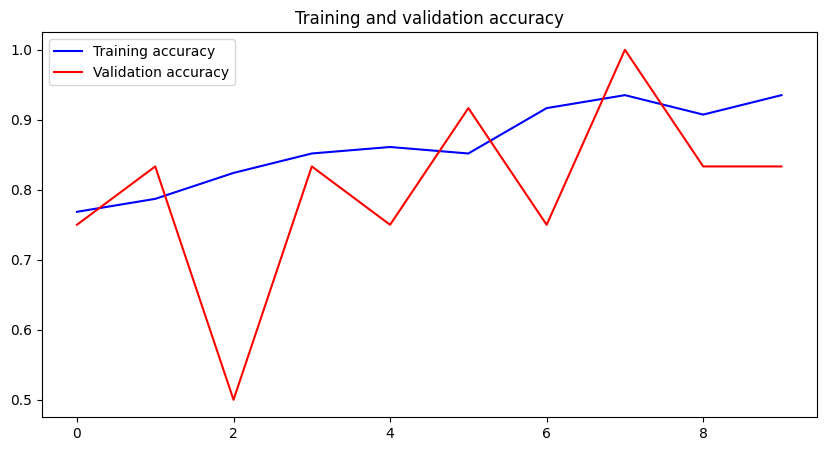

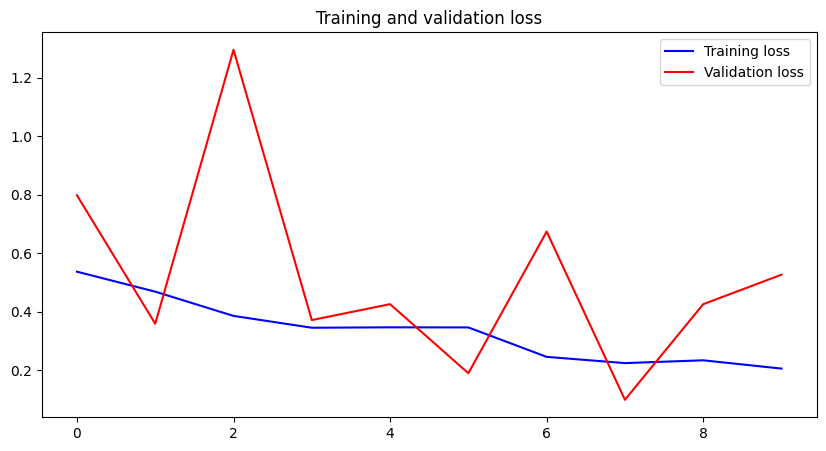

In [49]:
plot_cnn_folds(accuracy_train, accuracy_val, loss_train, loss_val)

In [50]:
cnn_images_test, cnn_images_rest, labels_test_test, labels_test_rest  = train_test_split(cnn_test_images, labels_test, train_size=0.5)

# Average the weights
average_weights = np.mean(weights_list, axis=0)

model_cnn_full.set_weights(average_weights)

test_loss, test_accuracy = model_cnn_full.evaluate(data_norm(cnn_images_test), labels_test_test)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

# previous
# Average Accuracy: 0.9666666686534882
# Average Loss: 0.10274658729540534
# Test Accuracy: 0.8500000238418579
# Test Loss: 0.4985653758049011

2/2 [==============================] - 1s 665ms/step - loss: 0.8203 - accuracy: 0.7500
Test Accuracy: 0.75
Test Loss: 0.8202797174453735


In [89]:
# Compile the model
model_cnn_full.compile(optimizer=Adam(0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

weights_list = []

accuracy_train = []
loss_train = []

accuracy_val = []
loss_val = []

# Iterate over the folds
for train_indices, val_indices in kfold.split(cnn_images): # labels
    model_cnn_full.fit(data_norm(cnn_images[train_indices]), labels[train_indices],
                       validation_data=(data_norm(cnn_images[val_indices]), labels[val_indices]),
                       epochs=10,
                       batch_size=batch_size,
                       verbose=1
                       )

    train_loss, train_accuracy = model_cnn_full.evaluate(data_norm(cnn_images[train_indices]), labels[train_indices])
    accuracy_train.append(train_accuracy)
    loss_train.append(train_loss)

    val_loss, val_accuracy = model_cnn_full.evaluate(data_norm(cnn_images[val_indices]), labels[val_indices])
    accuracy_val.append(val_accuracy)
    loss_val.append(val_loss)

    weights_list.append(model_cnn_full.get_weights())


Epoch 1/10
11/11 [==============================] - 9s 663ms/step - loss: 3.3970 - accuracy: 0.5185 - val_loss: 1.1249 - val_accuracy: 0.5833
Epoch 2/10
11/11 [==============================] - 7s 649ms/step - loss: 1.5583 - accuracy: 0.5463 - val_loss: 1.1651 - val_accuracy: 0.5833
Epoch 3/10
11/11 [==============================] - 7s 651ms/step - loss: 0.8671 - accuracy: 0.6481 - val_loss: 0.9049 - val_accuracy: 0.6667
Epoch 4/10
11/11 [==============================] - 7s 650ms/step - loss: 1.2293 - accuracy: 0.5185 - val_loss: 0.5378 - val_accuracy: 0.8333
Epoch 5/10
11/11 [==============================] - 7s 648ms/step - loss: 1.0196 - accuracy: 0.6019 - val_loss: 0.5573 - val_accuracy: 0.8333
Epoch 6/10
11/11 [==============================] - 7s 648ms/step - loss: 0.7943 - accuracy: 0.6574 - val_loss: 1.0636 - val_accuracy: 0.7500
Epoch 7/10
11/11 [==============================] - 7s 647ms/step - loss: 0.7512 - accuracy: 0.7500 - val_loss: 0.5466 - val_accuracy: 0.8333
Epoch 

Average Accuracy: 0.7750000059604645
Maximum Accuracy: 0.9166666865348816
Average Loss: 0.6970232620835304
Minimum Loss: 0.2443213015794754


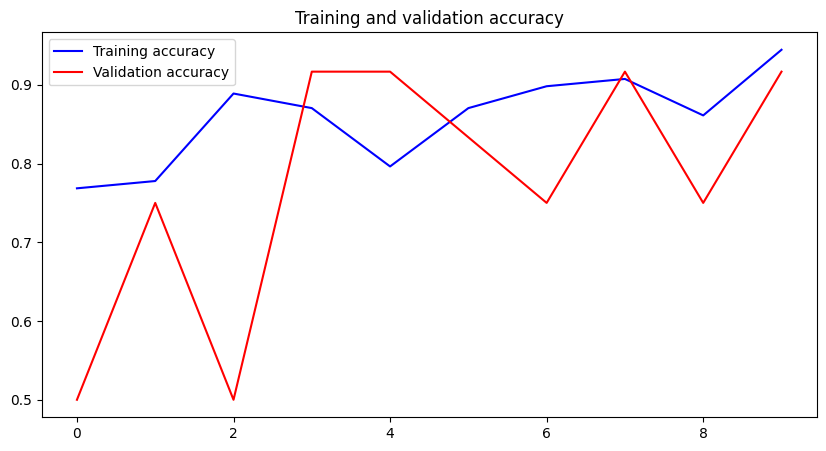

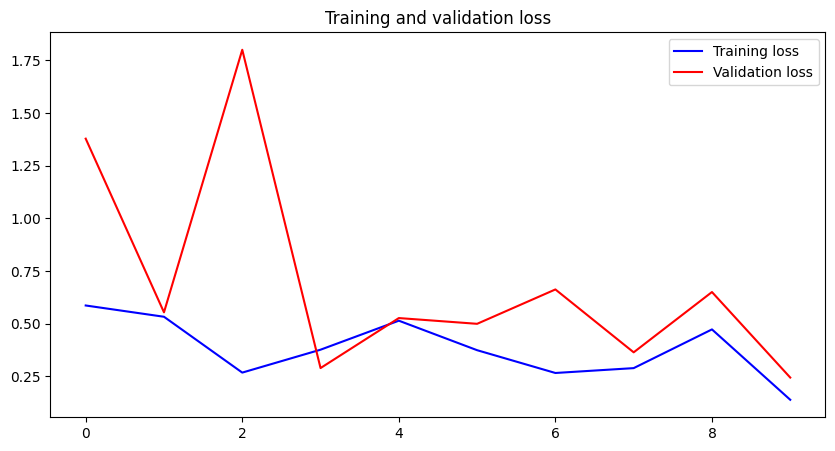

In [90]:
# Average Accuracy: 0.7833333313465118
# Maximum Accuracy: 0.9166666865348816
# Average Loss: 0.5872154384851456
# Minimum Loss: 0.221305251121521

print("Average Accuracy:", np.mean(accuracy_val))
print("Maximum Accuracy:", np.max(accuracy_val))
print("Average Loss:", np.mean(loss_val))
print("Minimum Loss:", np.min(loss_val))

plot_cnn_folds(accuracy_train, accuracy_val, loss_train, loss_val)

In [91]:
cnn_images_test, cnn_images_rest, labels_test_test, labels_test_rest  = train_test_split(cnn_test_images, labels_test, train_size=0.5)

# Average the weights
average_weights = np.mean(weights_list, axis=0)

model_cnn_full.set_weights(average_weights)

test_loss, test_accuracy = model_cnn_full.evaluate(data_norm(cnn_images_test), labels_test_test)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

# Test Accuracy: 0.7166666388511658
# Test Loss: 0.7592307925224304

2/2 [==============================] - 1s 589ms/step - loss: 0.4913 - accuracy: 0.7833
Test Accuracy: 0.7833333611488342
Test Loss: 0.49132683873176575


## Fully Conv idea upon original model

In [53]:
K.clear_session()

In [54]:
# Load the trained CAE model
best_model_cae = load_model('/content/drive/MyDrive/art_recognition_tech/best_model_cae.hdf5') # h5

# Remove the decoder layers of the CAE
encoder_model = Sequential(best_model_cae.layers[:-5]) # decoder_layers_to_remove

encoder_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 100)     7600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 100)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 200)     500200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 200)      0         
 2D)                                                             
                                                                 
Total params: 507,800
Trainable params: 507,800
Non-trainable params: 0
_________________________________________________________________


In [55]:
# CNN model
inputs = Input(input_shape)

# Encoder part
c1 = Conv2D(100, (5, 5), activation='relu', padding='same') (inputs)
p1 = MaxPooling2D(pool_size=(2,2)) (c1)

c2 = Conv2D(200, (5, 5), activation='relu', padding='same') (p1)
p2 = MaxPooling2D(pool_size=(2, 2)) (c2)

# CNN part
c3 = Conv2D(400, (1, 1), activation='relu') (p2)
c4 = Conv2D(200, (1, 1), activation='relu') (c3)
p3 = GlobalAveragePooling2D()(c4)  # Add this layer to convert spatial dimensions to a single dimension

outputs = Dense(CLASS_NUM, activation='softmax') (p3)
# outputs = Conv2D(CLASS_NUM, (1, 1), activation='softmax') (c4) # without GlobalAveragePooling2D

model_cnn_full_cae = Model(inputs=[inputs], outputs=[outputs])

model_cnn_full_cae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 100)     7600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 100)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 200)     500200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 200)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 400)       80400 

In [56]:
for i, layer in enumerate(encoder_model.layers):
  print(i, '->', layer.name)

0 -> conv2d
1 -> max_pooling2d
2 -> conv2d_1
3 -> max_pooling2d_1


In [57]:
for i, layer in enumerate(model_cnn_full_cae.layers):
  print(i, '->', layer.name)

0 -> input_1
1 -> conv2d
2 -> max_pooling2d
3 -> conv2d_1
4 -> max_pooling2d_1
5 -> conv2d_2
6 -> conv2d_3
7 -> global_average_pooling2d
8 -> dense


In [59]:
# Initialize the CNN with CAE weights
for i, layer in enumerate(encoder_model.layers):
  model_cnn_full_cae.layers[i+1].set_weights(layer.get_weights())

In [60]:
# Compile the model
model_cnn_full_cae.compile(optimizer=Adam(0.0001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

Epoch 1/10
11/11 [==============================] - 7s 319ms/step - loss: 1.0953 - accuracy: 0.3519 - val_loss: 1.1343 - val_accuracy: 0.0833
Epoch 2/10
11/11 [==============================] - 1s 127ms/step - loss: 1.0602 - accuracy: 0.4537 - val_loss: 1.1142 - val_accuracy: 0.2500
Epoch 3/10
11/11 [==============================] - 1s 126ms/step - loss: 1.0310 - accuracy: 0.5463 - val_loss: 1.0982 - val_accuracy: 0.3333
Epoch 4/10
11/11 [==============================] - 1s 126ms/step - loss: 0.9867 - accuracy: 0.5556 - val_loss: 1.0564 - val_accuracy: 0.4167
Epoch 5/10
11/11 [==============================] - 1s 127ms/step - loss: 0.9389 - accuracy: 0.6481 - val_loss: 0.9791 - val_accuracy: 0.5833
Epoch 6/10
11/11 [==============================] - 1s 126ms/step - loss: 0.8809 - accuracy: 0.6852 - val_loss: 0.9570 - val_accuracy: 0.5000
Epoch 7/10
11/11 [==============================] - 1s 127ms/step - loss: 0.8379 - accuracy: 0.6759 - val_loss: 0.8474 - val_accuracy: 0.5833
Epoch 

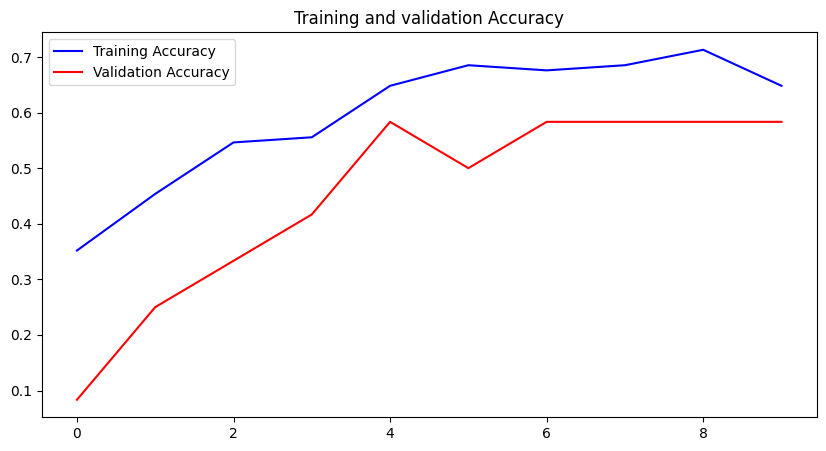

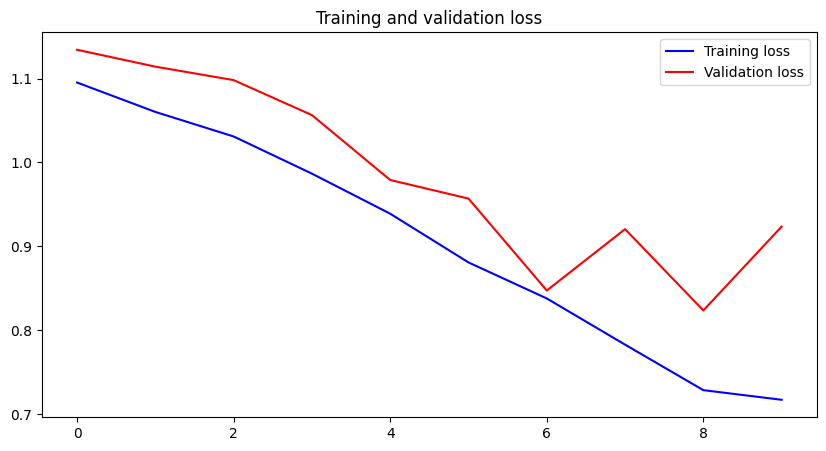

1/1 [==============================] - 0s 50ms/step - loss: 0.9235 - accuracy: 0.5833
Epoch 1/10
11/11 [==============================] - 1s 129ms/step - loss: 0.7310 - accuracy: 0.6759 - val_loss: 0.5762 - val_accuracy: 0.6667
Epoch 2/10
11/11 [==============================] - 1s 125ms/step - loss: 0.6874 - accuracy: 0.6759 - val_loss: 0.5454 - val_accuracy: 0.8333
Epoch 3/10
11/11 [==============================] - 1s 124ms/step - loss: 0.6879 - accuracy: 0.6944 - val_loss: 0.6007 - val_accuracy: 0.5833
Epoch 4/10
11/11 [==============================] - 1s 123ms/step - loss: 0.6821 - accuracy: 0.7315 - val_loss: 0.5235 - val_accuracy: 0.8333
Epoch 5/10
11/11 [==============================] - 1s 125ms/step - loss: 0.6495 - accuracy: 0.7222 - val_loss: 0.5210 - val_accuracy: 0.9167
Epoch 6/10
11/11 [==============================] - 1s 124ms/step - loss: 0.6680 - accuracy: 0.7500 - val_loss: 0.4940 - val_accuracy: 0.9167
Epoch 7/10
11/11 [==============================] - 1s 122ms/s

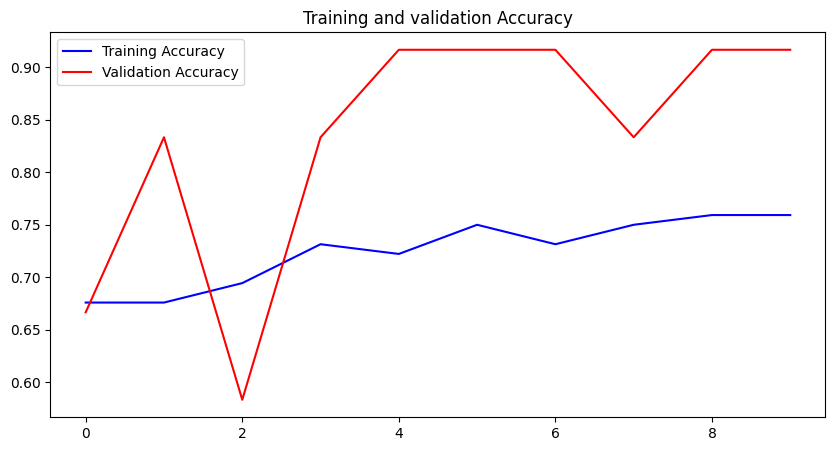

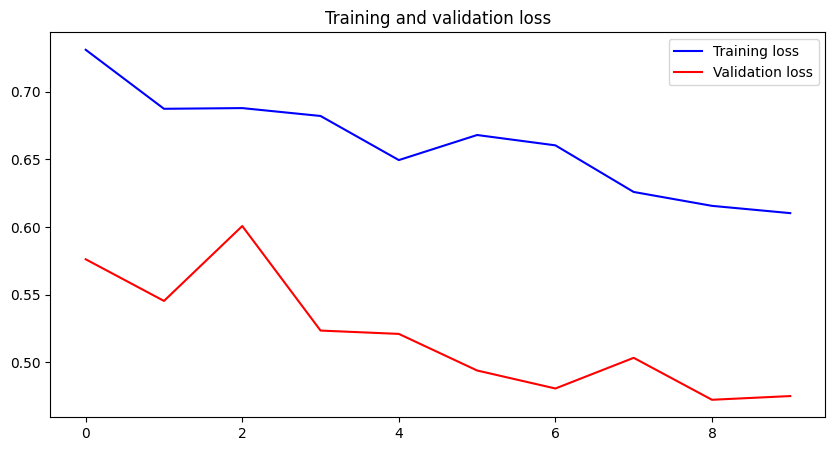

1/1 [==============================] - 0s 51ms/step - loss: 0.4751 - accuracy: 0.9167
Epoch 1/10
11/11 [==============================] - 1s 126ms/step - loss: 0.5533 - accuracy: 0.7778 - val_loss: 1.0332 - val_accuracy: 0.5833
Epoch 2/10
11/11 [==============================] - 1s 121ms/step - loss: 0.5265 - accuracy: 0.7963 - val_loss: 1.0746 - val_accuracy: 0.5000
Epoch 3/10
11/11 [==============================] - 1s 121ms/step - loss: 0.5267 - accuracy: 0.7963 - val_loss: 1.0890 - val_accuracy: 0.5000
Epoch 4/10
11/11 [==============================] - 1s 121ms/step - loss: 0.5532 - accuracy: 0.7593 - val_loss: 1.1464 - val_accuracy: 0.5000
Epoch 5/10
11/11 [==============================] - 1s 121ms/step - loss: 0.5419 - accuracy: 0.7963 - val_loss: 1.1527 - val_accuracy: 0.5000
Epoch 6/10
11/11 [==============================] - 1s 121ms/step - loss: 0.5296 - accuracy: 0.7685 - val_loss: 1.2311 - val_accuracy: 0.5833
Epoch 7/10
11/11 [==============================] - 1s 121ms/s

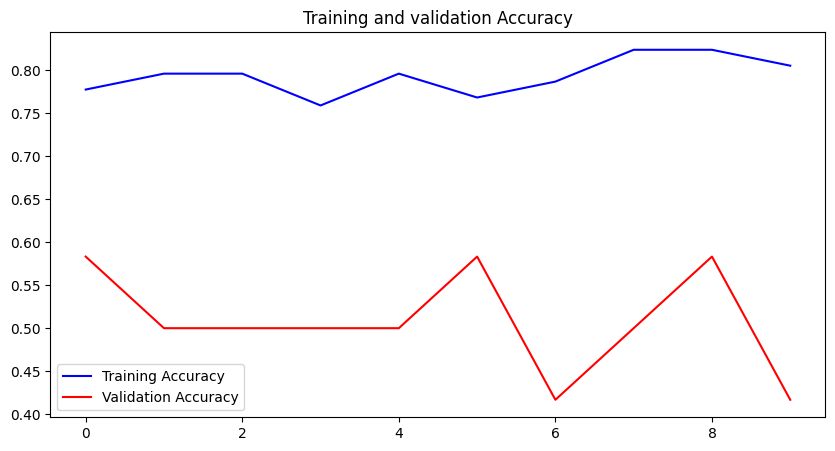

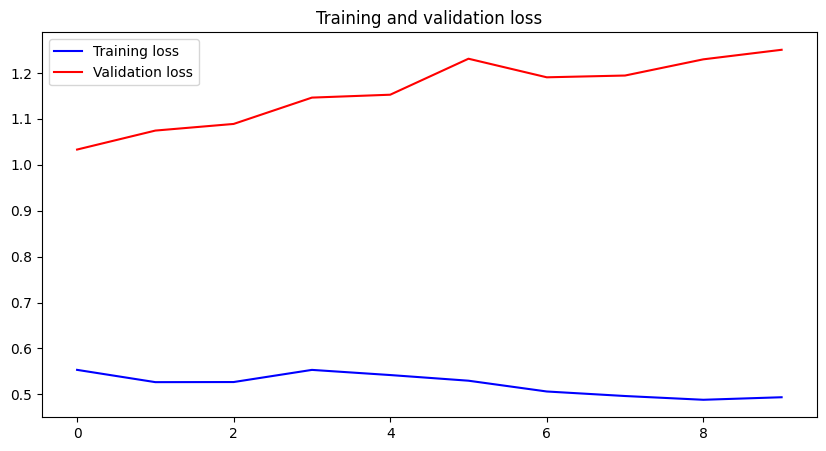

1/1 [==============================] - 0s 51ms/step - loss: 1.2506 - accuracy: 0.4167
Epoch 1/10
11/11 [==============================] - 1s 125ms/step - loss: 0.6009 - accuracy: 0.7500 - val_loss: 0.2345 - val_accuracy: 1.0000
Epoch 2/10
11/11 [==============================] - 1s 121ms/step - loss: 0.5937 - accuracy: 0.7593 - val_loss: 0.2497 - val_accuracy: 1.0000
Epoch 3/10
11/11 [==============================] - 1s 121ms/step - loss: 0.5809 - accuracy: 0.7685 - val_loss: 0.2505 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 1s 121ms/step - loss: 0.5743 - accuracy: 0.7778 - val_loss: 0.3021 - val_accuracy: 0.9167
Epoch 5/10
11/11 [==============================] - 1s 120ms/step - loss: 0.5494 - accuracy: 0.7685 - val_loss: 0.2768 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 1s 121ms/step - loss: 0.5557 - accuracy: 0.7593 - val_loss: 0.2983 - val_accuracy: 1.0000
Epoch 7/10
11/11 [==============================] - 1s 121ms/s

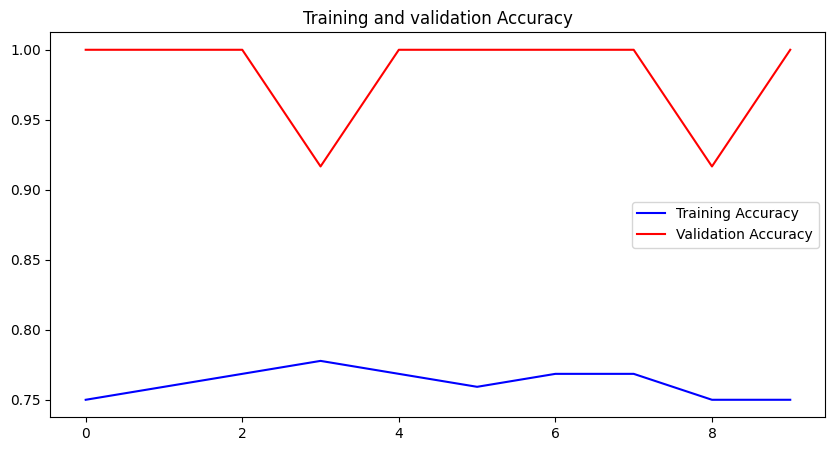

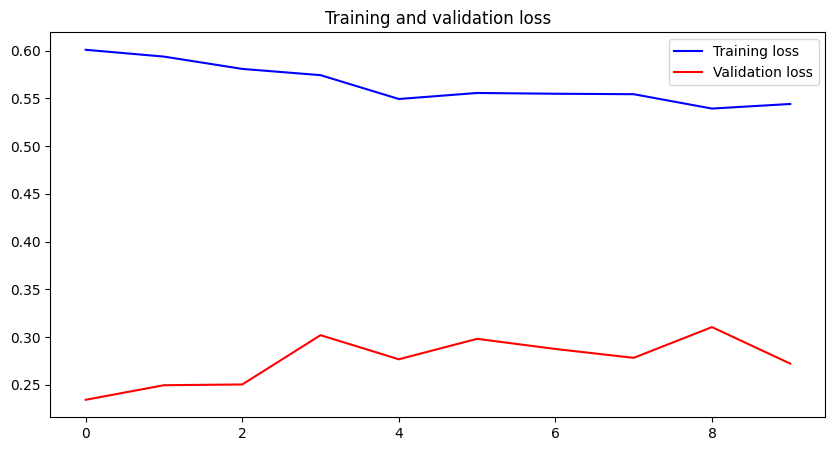

1/1 [==============================] - 0s 50ms/step - loss: 0.2723 - accuracy: 1.0000
Epoch 1/10
11/11 [==============================] - 1s 125ms/step - loss: 0.5183 - accuracy: 0.7778 - val_loss: 0.4518 - val_accuracy: 0.9167
Epoch 2/10
11/11 [==============================] - 1s 121ms/step - loss: 0.5139 - accuracy: 0.7593 - val_loss: 0.4564 - val_accuracy: 0.9167
Epoch 3/10
11/11 [==============================] - 1s 121ms/step - loss: 0.5247 - accuracy: 0.7778 - val_loss: 0.4395 - val_accuracy: 0.9167
Epoch 4/10
11/11 [==============================] - 1s 122ms/step - loss: 0.5208 - accuracy: 0.7963 - val_loss: 0.5263 - val_accuracy: 0.9167
Epoch 5/10
11/11 [==============================] - 1s 124ms/step - loss: 0.5171 - accuracy: 0.7500 - val_loss: 0.4693 - val_accuracy: 0.9167
Epoch 6/10
11/11 [==============================] - 1s 122ms/step - loss: 0.4962 - accuracy: 0.7685 - val_loss: 0.4525 - val_accuracy: 0.9167
Epoch 7/10
11/11 [==============================] - 1s 123ms/s

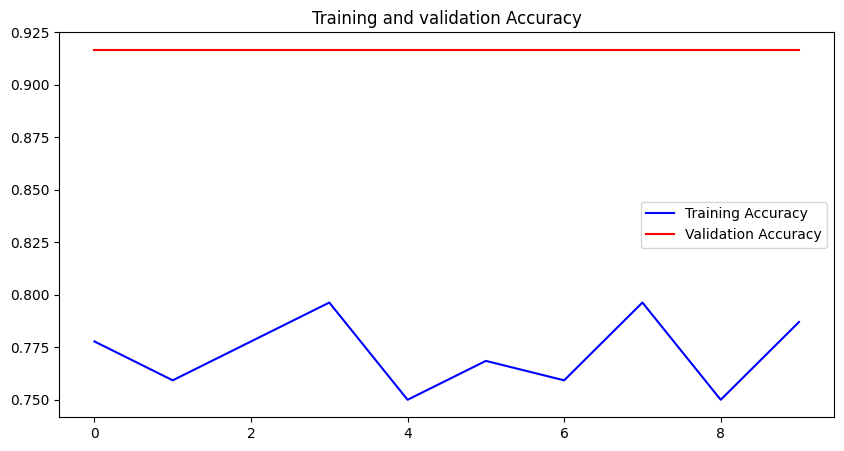

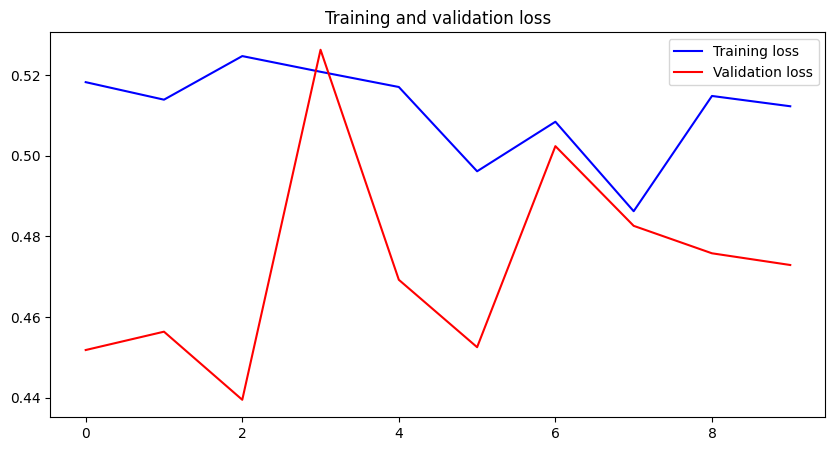

1/1 [==============================] - 0s 51ms/step - loss: 0.4729 - accuracy: 0.9167
Epoch 1/10
11/11 [==============================] - 1s 129ms/step - loss: 0.5003 - accuracy: 0.8056 - val_loss: 0.5585 - val_accuracy: 0.6667
Epoch 2/10
11/11 [==============================] - 1s 124ms/step - loss: 0.5058 - accuracy: 0.7870 - val_loss: 0.5343 - val_accuracy: 0.8333
Epoch 3/10
11/11 [==============================] - 1s 125ms/step - loss: 0.4784 - accuracy: 0.8148 - val_loss: 0.6835 - val_accuracy: 0.5833
Epoch 4/10
11/11 [==============================] - 1s 125ms/step - loss: 0.4712 - accuracy: 0.8241 - val_loss: 0.5048 - val_accuracy: 0.7500
Epoch 5/10
11/11 [==============================] - 1s 126ms/step - loss: 0.4706 - accuracy: 0.7870 - val_loss: 0.5336 - val_accuracy: 0.7500
Epoch 6/10
11/11 [==============================] - 1s 126ms/step - loss: 0.4654 - accuracy: 0.8148 - val_loss: 0.5798 - val_accuracy: 0.6667
Epoch 7/10
11/11 [==============================] - 1s 125ms/s

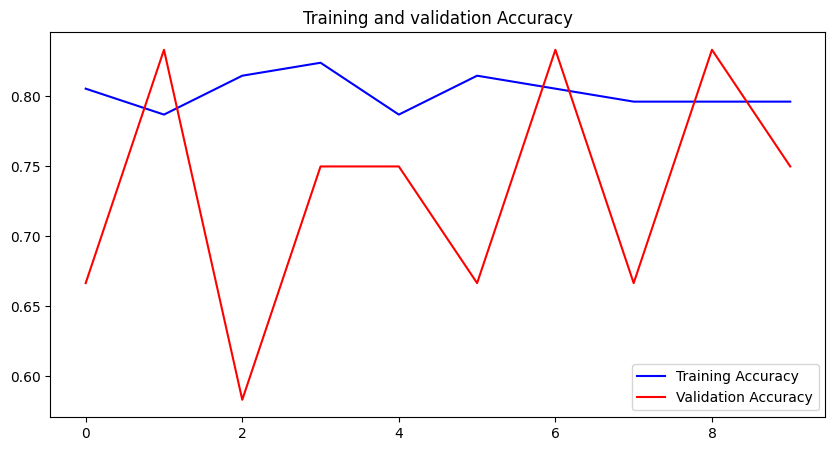

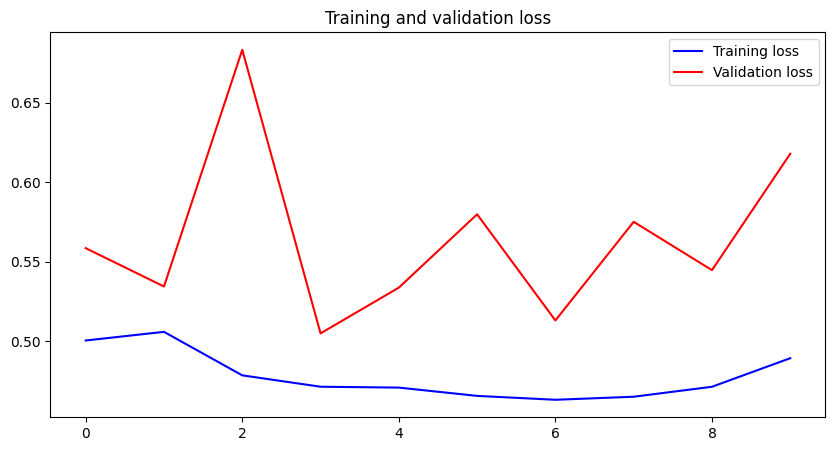

1/1 [==============================] - 0s 50ms/step - loss: 0.6179 - accuracy: 0.7500
Epoch 1/10
11/11 [==============================] - 1s 129ms/step - loss: 0.4656 - accuracy: 0.8056 - val_loss: 0.6852 - val_accuracy: 0.6667
Epoch 2/10
11/11 [==============================] - 1s 126ms/step - loss: 0.4482 - accuracy: 0.7963 - val_loss: 0.6029 - val_accuracy: 0.6667
Epoch 3/10
11/11 [==============================] - 1s 126ms/step - loss: 0.4543 - accuracy: 0.8241 - val_loss: 0.6489 - val_accuracy: 0.6667
Epoch 4/10
11/11 [==============================] - 1s 126ms/step - loss: 0.4475 - accuracy: 0.7778 - val_loss: 0.6642 - val_accuracy: 0.6667
Epoch 5/10
11/11 [==============================] - 1s 125ms/step - loss: 0.4718 - accuracy: 0.8148 - val_loss: 0.7263 - val_accuracy: 0.6667
Epoch 6/10
11/11 [==============================] - 1s 125ms/step - loss: 0.4592 - accuracy: 0.7963 - val_loss: 0.6372 - val_accuracy: 0.6667
Epoch 7/10
11/11 [==============================] - 1s 126ms/s

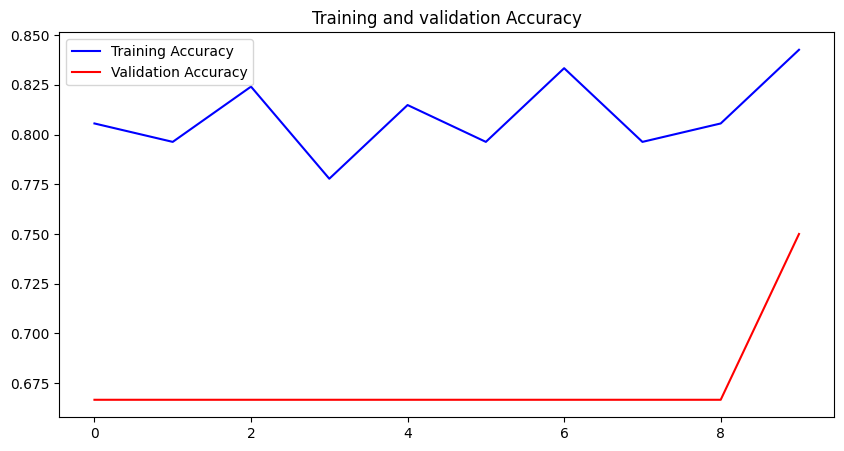

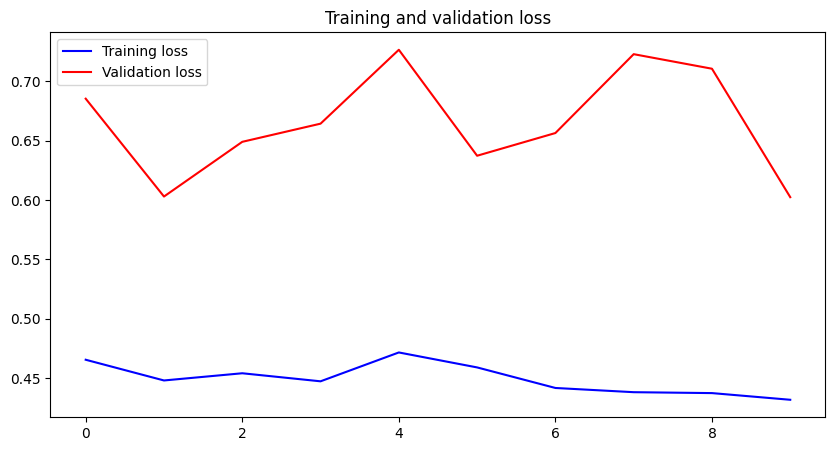

1/1 [==============================] - 0s 54ms/step - loss: 0.6024 - accuracy: 0.7500
Epoch 1/10
11/11 [==============================] - 1s 124ms/step - loss: 0.4735 - accuracy: 0.7963 - val_loss: 0.2289 - val_accuracy: 0.9167
Epoch 2/10
11/11 [==============================] - 1s 121ms/step - loss: 0.4821 - accuracy: 0.7778 - val_loss: 0.2105 - val_accuracy: 0.9167
Epoch 3/10
11/11 [==============================] - 1s 121ms/step - loss: 0.4873 - accuracy: 0.8056 - val_loss: 0.2244 - val_accuracy: 0.9167
Epoch 4/10
11/11 [==============================] - 1s 121ms/step - loss: 0.4886 - accuracy: 0.8056 - val_loss: 0.2438 - val_accuracy: 0.9167
Epoch 5/10
11/11 [==============================] - 1s 122ms/step - loss: 0.4817 - accuracy: 0.8148 - val_loss: 0.2373 - val_accuracy: 0.9167
Epoch 6/10
11/11 [==============================] - 1s 121ms/step - loss: 0.4838 - accuracy: 0.8148 - val_loss: 0.2425 - val_accuracy: 0.9167
Epoch 7/10
11/11 [==============================] - 1s 122ms/s

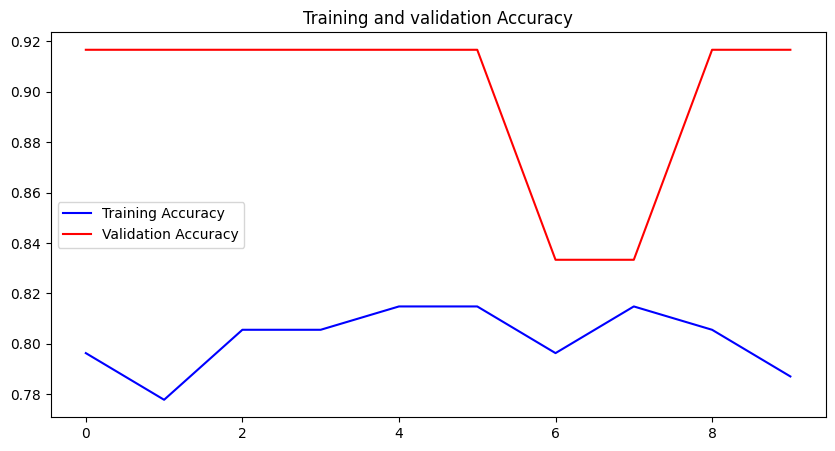

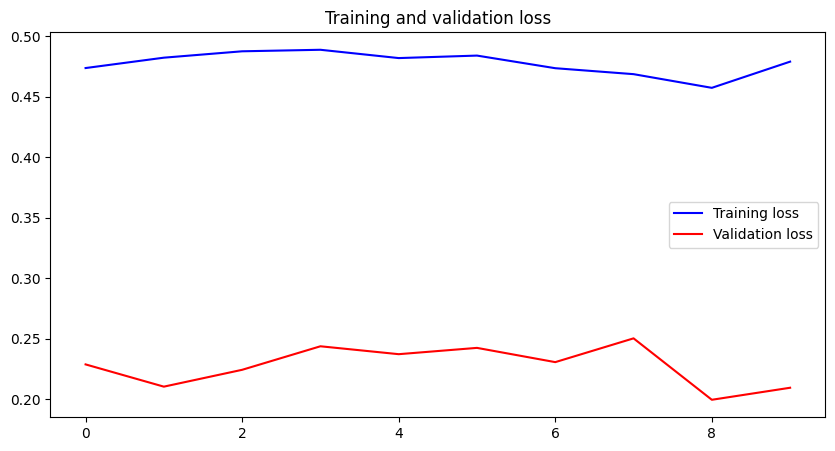

1/1 [==============================] - 0s 52ms/step - loss: 0.2096 - accuracy: 0.9167
Epoch 1/10
11/11 [==============================] - 1s 124ms/step - loss: 0.4084 - accuracy: 0.8426 - val_loss: 0.5921 - val_accuracy: 0.6667
Epoch 2/10
11/11 [==============================] - 1s 120ms/step - loss: 0.4167 - accuracy: 0.8333 - val_loss: 0.5652 - val_accuracy: 0.7500
Epoch 3/10
11/11 [==============================] - 1s 122ms/step - loss: 0.4014 - accuracy: 0.8519 - val_loss: 0.6345 - val_accuracy: 0.6667
Epoch 4/10
11/11 [==============================] - 1s 121ms/step - loss: 0.4281 - accuracy: 0.8056 - val_loss: 0.5914 - val_accuracy: 0.7500
Epoch 5/10
11/11 [==============================] - 1s 122ms/step - loss: 0.4132 - accuracy: 0.8796 - val_loss: 0.6153 - val_accuracy: 0.6667
Epoch 6/10
11/11 [==============================] - 1s 122ms/step - loss: 0.3995 - accuracy: 0.8426 - val_loss: 0.6116 - val_accuracy: 0.6667
Epoch 7/10
11/11 [==============================] - 1s 122ms/s

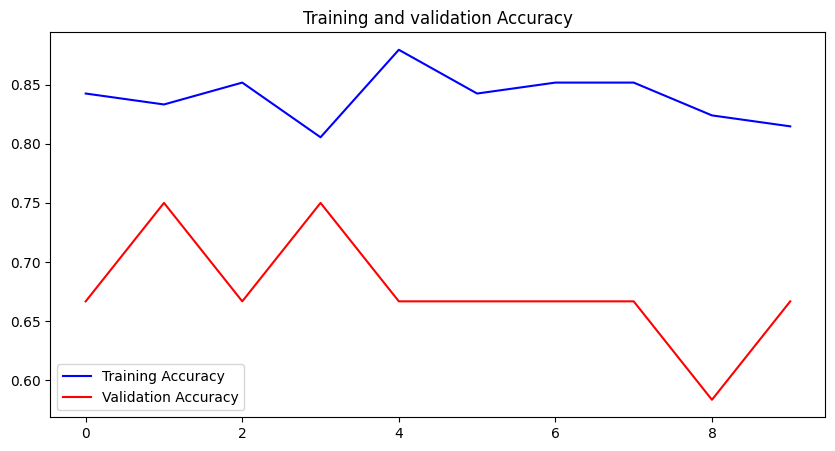

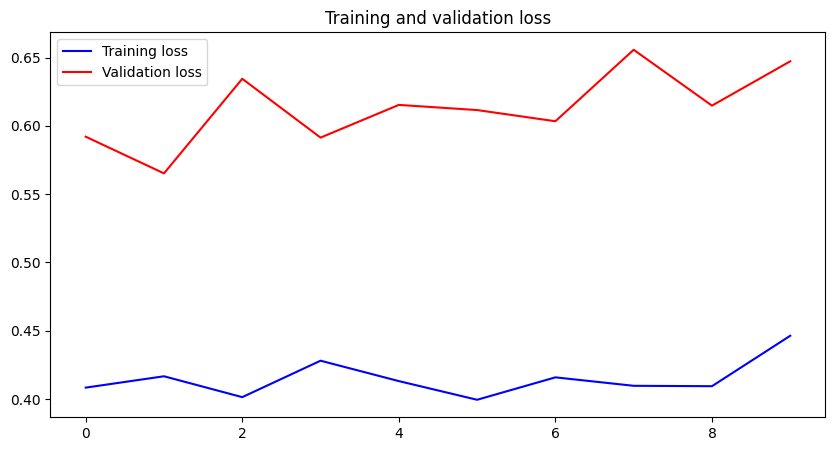

1/1 [==============================] - 0s 52ms/step - loss: 0.6473 - accuracy: 0.6667
Epoch 1/10
11/11 [==============================] - 1s 127ms/step - loss: 0.4854 - accuracy: 0.7963 - val_loss: 0.4131 - val_accuracy: 0.8333
Epoch 2/10
11/11 [==============================] - 1s 124ms/step - loss: 0.4681 - accuracy: 0.8148 - val_loss: 0.4307 - val_accuracy: 0.8333
Epoch 3/10
11/11 [==============================] - 1s 124ms/step - loss: 0.4328 - accuracy: 0.8241 - val_loss: 0.3335 - val_accuracy: 0.8333
Epoch 4/10
11/11 [==============================] - 1s 124ms/step - loss: 0.4347 - accuracy: 0.8333 - val_loss: 0.4530 - val_accuracy: 0.8333
Epoch 5/10
11/11 [==============================] - 1s 125ms/step - loss: 0.4175 - accuracy: 0.8333 - val_loss: 0.4078 - val_accuracy: 0.8333
Epoch 6/10
11/11 [==============================] - 1s 126ms/step - loss: 0.4065 - accuracy: 0.8426 - val_loss: 0.4315 - val_accuracy: 0.8333
Epoch 7/10
11/11 [==============================] - 1s 126ms/s

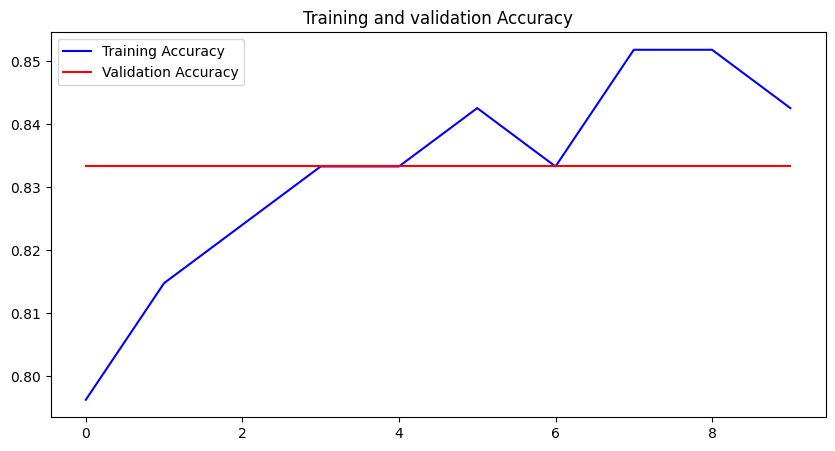

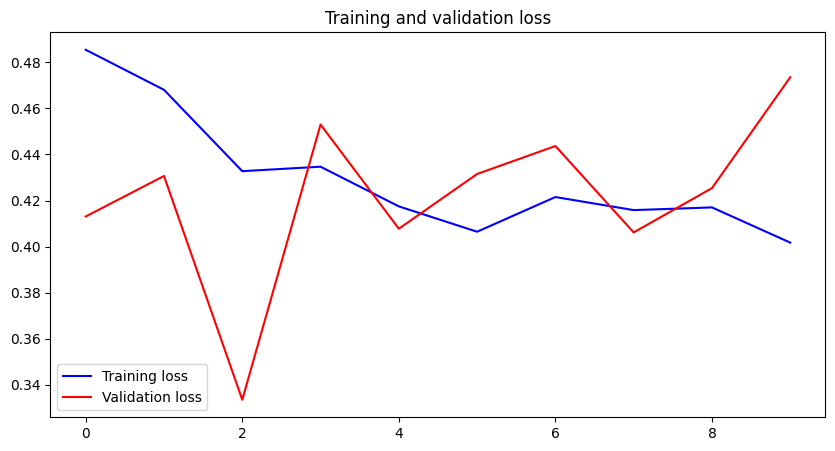

1/1 [==============================] - 0s 52ms/step - loss: 0.4735 - accuracy: 0.8333


In [61]:
weights_list = []

accuracy_train = []
loss_train = []

accuracy_val = []
loss_val = []

# Iterate over the folds
for train_indices, val_indices in kfold.split(cnn_images): # labels
    history_model_cnn_full_cae = model_cnn_full_cae.fit(data_norm(cnn_images[train_indices]), labels[train_indices],
                       validation_data=(data_norm(cnn_images[val_indices]), labels[val_indices]),
                       epochs=10,
                       batch_size=batch_size,
                       verbose=1
                       )

    plot_cnn_history(history_model_cnn_full_cae)

    train_loss, train_accuracy = model_cnn_full_cae.evaluate(data_norm(cnn_images[train_indices]), labels[train_indices])
    accuracy_train.append(train_accuracy)
    loss_train.append(train_loss)

    val_loss, val_accuracy = model_cnn_full_cae.evaluate(data_norm(cnn_images[val_indices]), labels[val_indices])
    accuracy_val.append(val_accuracy)
    loss_val.append(val_loss)

    weights_list.append(model_cnn_full_cae.get_weights())


In [62]:
# previous
# Average Accuracy: 0.9666666686534882
# Average Loss: 0.10274658729540534

print("Average Accuracy:", np.mean(accuracy_val))
print("Maximum Accuracy:", np.max(accuracy_val))
print("Average Loss:", np.mean(loss_val))
print("Minimum Loss:", np.min(loss_val))

Average Accuracy: 0.7750000029802322
Maximum Accuracy: 1.0
Average Loss: 0.594516521692276
Minimum Loss: 0.20958280563354492


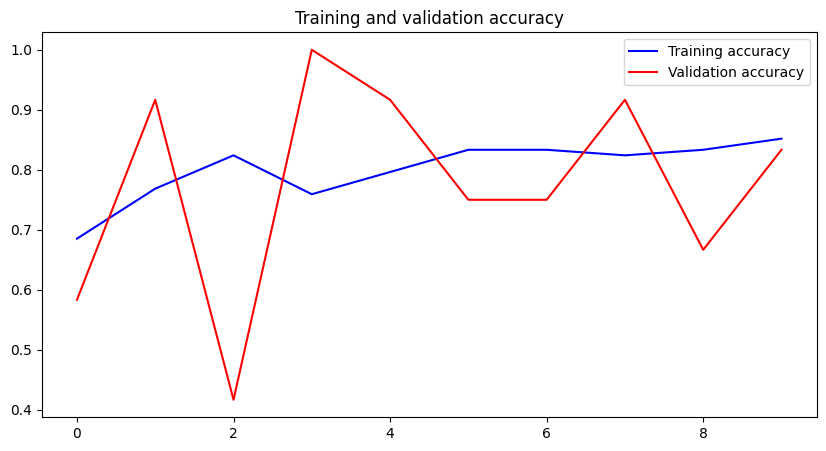

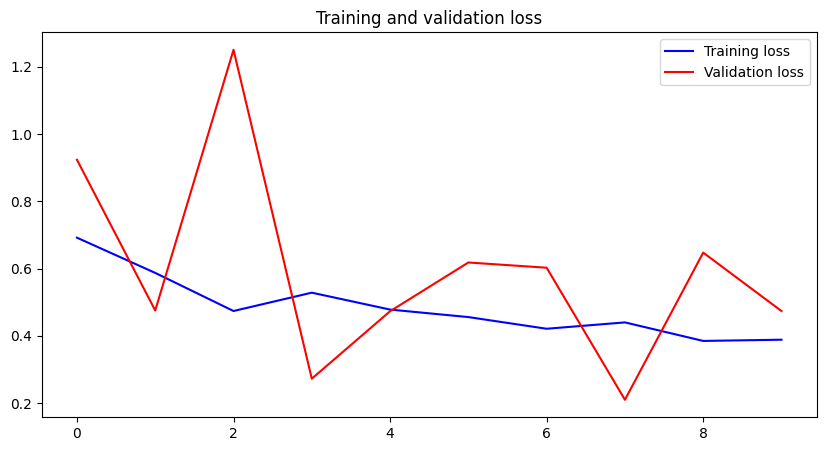

In [63]:
plot_cnn_folds(accuracy_train, accuracy_val, loss_train, loss_val)

In [64]:
# without stratificaion by labels and random_seed
cnn_images_test, cnn_images_rest, labels_test_test, labels_test_rest  = train_test_split(cnn_test_images, labels_test, train_size=0.5)

# Average the weights
average_weights = np.mean(weights_list, axis=0)

model_cnn_full_cae.set_weights(average_weights)

test_loss, test_accuracy = model_cnn_full_cae.evaluate(data_norm(cnn_images_test), labels_test_test)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

# previous
# Average Accuracy: 0.9666666686534882
# Average Loss: 0.10274658729540534
# Test Accuracy: 0.8500000238418579
# Test Loss: 0.4985653758049011

2/2 [==============================] - 3s 3s/step - loss: 0.6836 - accuracy: 0.7167
Test Accuracy: 0.7166666388511658
Test Loss: 0.6836172938346863


Without overfitting:
- Average Accuracy: 0.775 vs Test Accuracy: 0.717
- Average Loss: 0.59 vs Test Loss: 0.68

But the result is worse than original.

## CNN with Dropout

In [65]:
K.clear_session()

In [66]:
# Load the trained CAE model
best_model_cae = load_model('/content/drive/MyDrive/art_recognition_tech/best_model_cae.hdf5') # h5

# Remove the decoder layers of the CAE
encoder_model = Sequential(best_model_cae.layers[:-5]) # decoder_layers_to_remove

encoder_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 100)     7600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 100)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 200)     500200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 200)      0         
 2D)                                                             
                                                                 
Total params: 507,800
Trainable params: 507,800
Non-trainable params: 0
_________________________________________________________________


In [67]:
# CNN model
def CNN_model_drop():
    model = Sequential()
    # Initialize the CNN with CAE encoder layers
    for layer in encoder_model.layers:
        model.add(layer)

    # Additional layers for classification
    model.add(Flatten())
    model.add(Dense(400, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(200, activation='relu'))

    model.add(Dense(CLASS_NUM, activation='softmax'))

    # Initialize the CNN with CAE weights
    for i, layer in enumerate(encoder_model.layers):
        model.layers[i].set_weights(layer.get_weights())

    return model


# Create the CNN model
model_cnn_drop = CNN_model_drop()
model_cnn_drop.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 100)     7600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 100)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 200)     500200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 200)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 819200)            0         
                                                                 
 dense (Dense)               (None, 400)              

In [68]:
# Compile the model
model_cnn_drop.compile(optimizer=Adam(0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

Epoch 1/10
11/11 [==============================] - 4s 183ms/step - loss: 2.9310 - accuracy: 0.4444 - val_loss: 1.4418 - val_accuracy: 0.4167
Epoch 2/10
11/11 [==============================] - 2s 167ms/step - loss: 0.9948 - accuracy: 0.5556 - val_loss: 0.9389 - val_accuracy: 0.6667
Epoch 3/10
11/11 [==============================] - 2s 167ms/step - loss: 0.7271 - accuracy: 0.6667 - val_loss: 0.8461 - val_accuracy: 0.5833
Epoch 4/10
11/11 [==============================] - 2s 167ms/step - loss: 0.5530 - accuracy: 0.7685 - val_loss: 0.6787 - val_accuracy: 0.7500
Epoch 5/10
11/11 [==============================] - 2s 168ms/step - loss: 0.4398 - accuracy: 0.8333 - val_loss: 0.9380 - val_accuracy: 0.6667
Epoch 6/10
11/11 [==============================] - 2s 169ms/step - loss: 0.2668 - accuracy: 0.8981 - val_loss: 1.0554 - val_accuracy: 0.5833
Epoch 7/10
11/11 [==============================] - 2s 170ms/step - loss: 0.2577 - accuracy: 0.8889 - val_loss: 1.4945 - val_accuracy: 0.6667
Epoch 

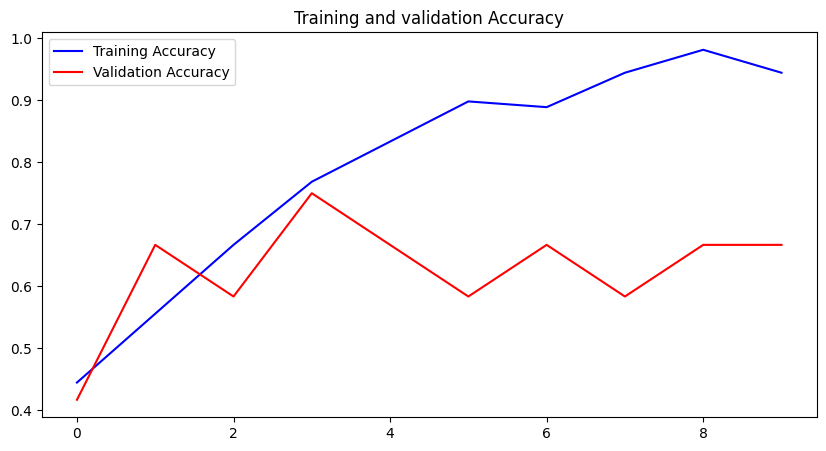

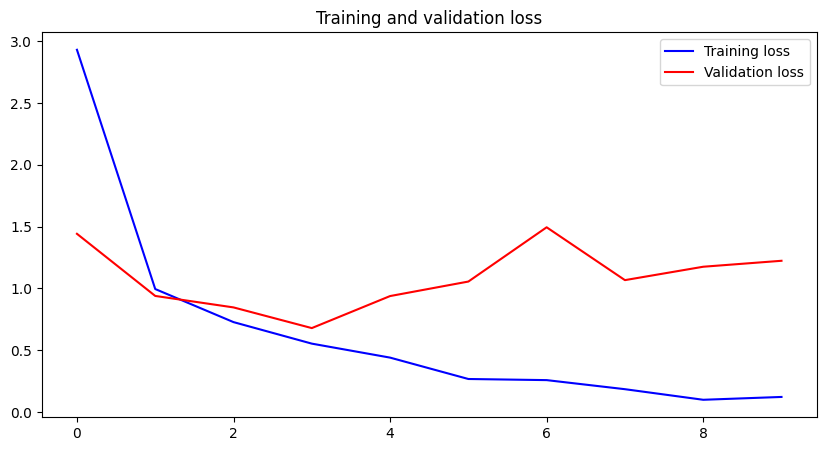

1/1 [==============================] - 0s 54ms/step - loss: 1.2235 - accuracy: 0.6667
Epoch 1/10
11/11 [==============================] - 2s 173ms/step - loss: 0.2080 - accuracy: 0.9259 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 2/10
11/11 [==============================] - 2s 168ms/step - loss: 0.1635 - accuracy: 0.9630 - val_loss: 0.0269 - val_accuracy: 1.0000
Epoch 3/10
11/11 [==============================] - 2s 171ms/step - loss: 0.0589 - accuracy: 0.9907 - val_loss: 0.0361 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 2s 169ms/step - loss: 0.0357 - accuracy: 0.9907 - val_loss: 0.0400 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 2s 170ms/step - loss: 0.0288 - accuracy: 0.9907 - val_loss: 0.0825 - val_accuracy: 0.9167
Epoch 6/10
11/11 [==============================] - 2s 167ms/step - loss: 0.0214 - accuracy: 1.0000 - val_loss: 0.0248 - val_accuracy: 1.0000
Epoch 7/10
11/11 [==============================] - 2s 170ms/s

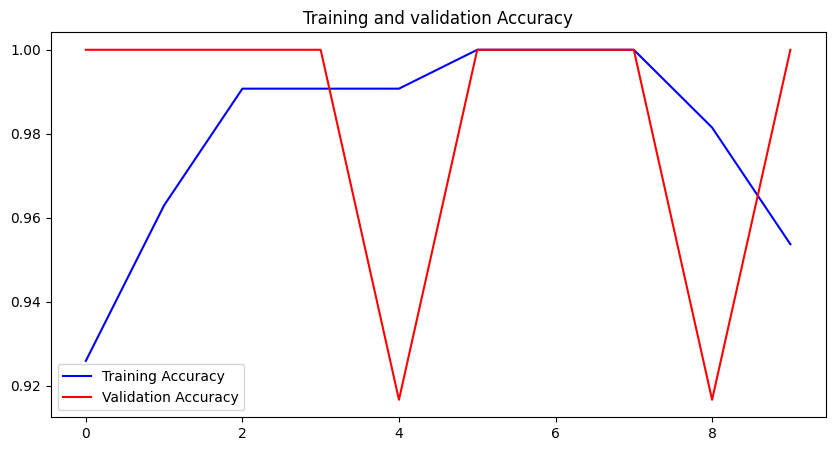

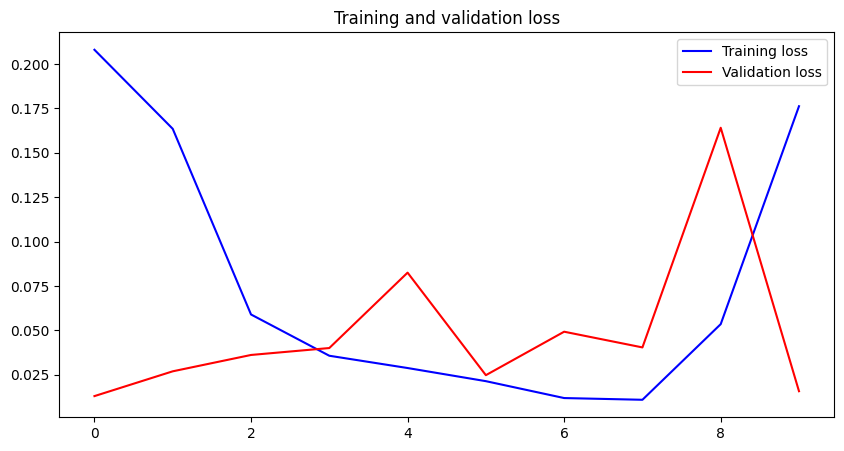

1/1 [==============================] - 0s 73ms/step - loss: 0.0157 - accuracy: 1.0000
Epoch 1/10
11/11 [==============================] - 2s 168ms/step - loss: 0.0867 - accuracy: 0.9537 - val_loss: 0.0832 - val_accuracy: 1.0000
Epoch 2/10
11/11 [==============================] - 2s 165ms/step - loss: 0.0843 - accuracy: 0.9722 - val_loss: 0.1789 - val_accuracy: 0.9167
Epoch 3/10
11/11 [==============================] - 2s 165ms/step - loss: 0.0432 - accuracy: 0.9907 - val_loss: 0.1151 - val_accuracy: 0.9167
Epoch 4/10
11/11 [==============================] - 2s 165ms/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.0491 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 2s 165ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.0464 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 2s 165ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0494 - val_accuracy: 1.0000
Epoch 7/10
11/11 [==============================] - 2s 166ms/s

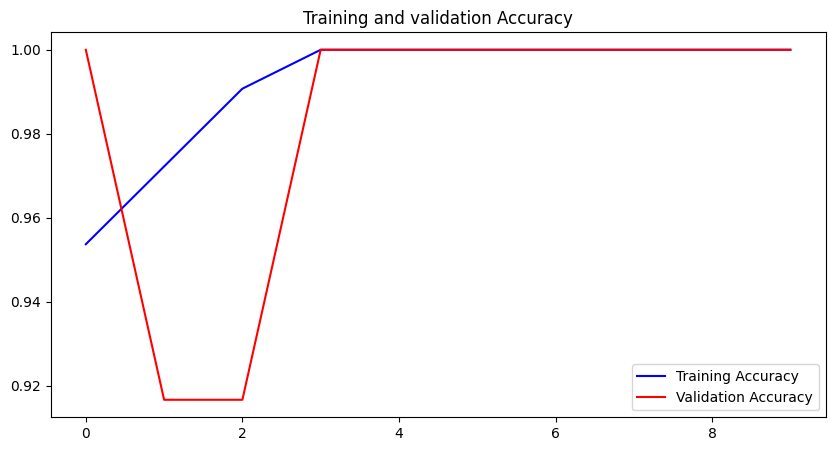

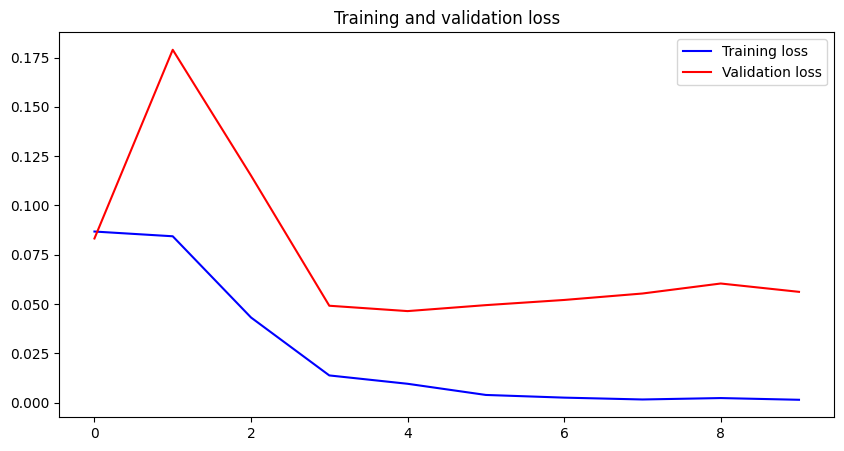

1/1 [==============================] - 0s 50ms/step - loss: 0.0562 - accuracy: 1.0000
Epoch 1/10
11/11 [==============================] - 2s 168ms/step - loss: 0.0552 - accuracy: 0.9815 - val_loss: 8.1672e-04 - val_accuracy: 1.0000
Epoch 2/10
11/11 [==============================] - 2s 165ms/step - loss: 0.0247 - accuracy: 1.0000 - val_loss: 8.5776e-04 - val_accuracy: 1.0000
Epoch 3/10
11/11 [==============================] - 2s 166ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 2s 165ms/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 9.4165e-04 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 2s 165ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 6.8166e-04 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 2s 166ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 7.6207e-04 - val_accuracy: 1.0000
Epoch 7/10
11/11 [========================

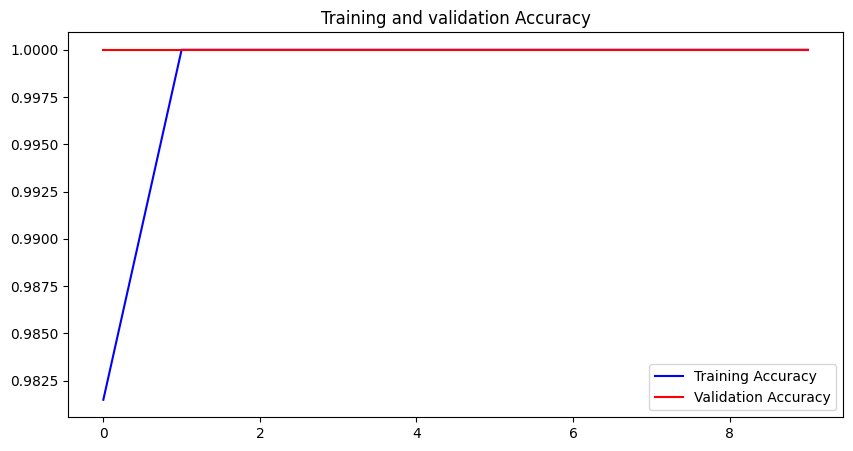

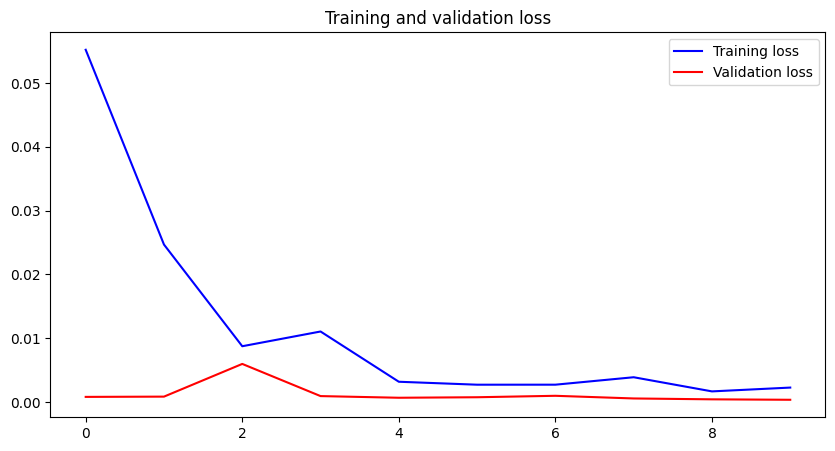

1/1 [==============================] - 0s 54ms/step - loss: 3.6437e-04 - accuracy: 1.0000
Epoch 1/10
11/11 [==============================] - 2s 170ms/step - loss: 9.7013e-04 - accuracy: 1.0000 - val_loss: 2.4927e-04 - val_accuracy: 1.0000
Epoch 2/10
11/11 [==============================] - 2s 166ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 2.7143e-04 - val_accuracy: 1.0000
Epoch 3/10
11/11 [==============================] - 2s 168ms/step - loss: 6.6647e-04 - accuracy: 1.0000 - val_loss: 3.4276e-04 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 2s 167ms/step - loss: 6.8356e-04 - accuracy: 1.0000 - val_loss: 1.8519e-04 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 2s 167ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 3.8040e-04 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 2s 166ms/step - loss: 9.1361e-04 - accuracy: 1.0000 - val_loss: 3.7075e-04 - val_accuracy: 1.0000
Epoch 7/10
11/11 [

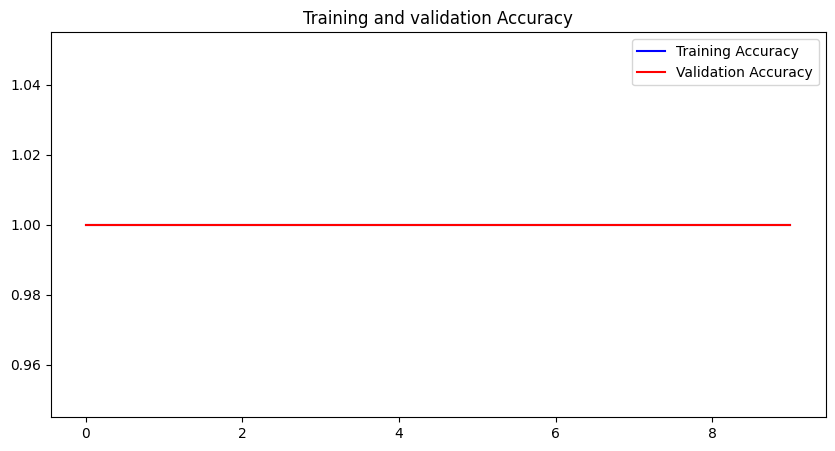

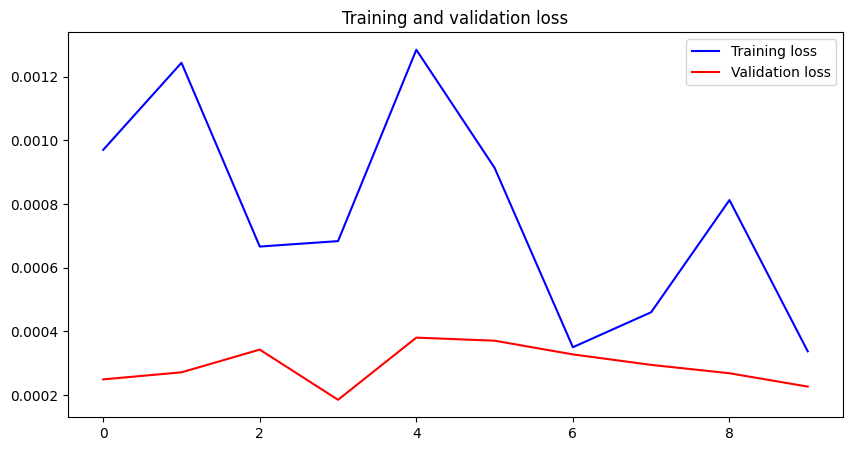

1/1 [==============================] - 0s 51ms/step - loss: 2.2662e-04 - accuracy: 1.0000
Epoch 1/10
11/11 [==============================] - 2s 171ms/step - loss: 5.1133e-04 - accuracy: 1.0000 - val_loss: 2.1715e-05 - val_accuracy: 1.0000
Epoch 2/10
11/11 [==============================] - 2s 166ms/step - loss: 5.8684e-04 - accuracy: 1.0000 - val_loss: 1.8676e-05 - val_accuracy: 1.0000
Epoch 3/10
11/11 [==============================] - 2s 167ms/step - loss: 3.0299e-04 - accuracy: 1.0000 - val_loss: 1.6043e-05 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 2s 166ms/step - loss: 3.5781e-04 - accuracy: 1.0000 - val_loss: 1.3162e-05 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 2s 171ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 6.9440e-04 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 2s 168ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 4.1633e-04 - val_accuracy: 1.0000
Epoch 7/10
11/11 [

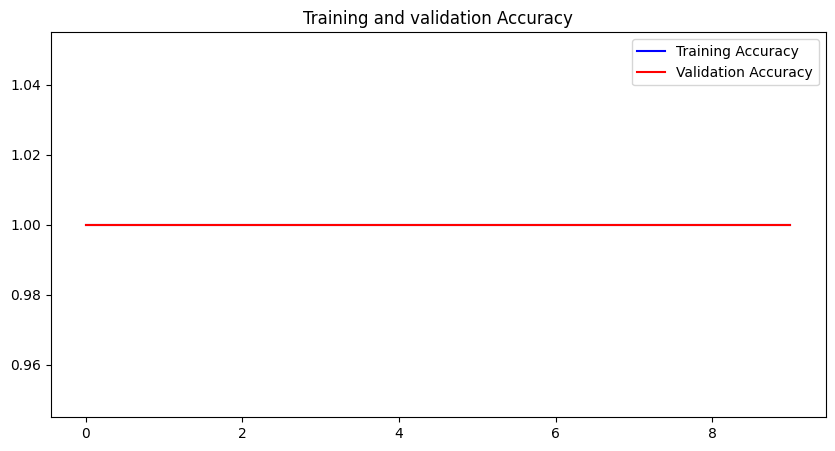

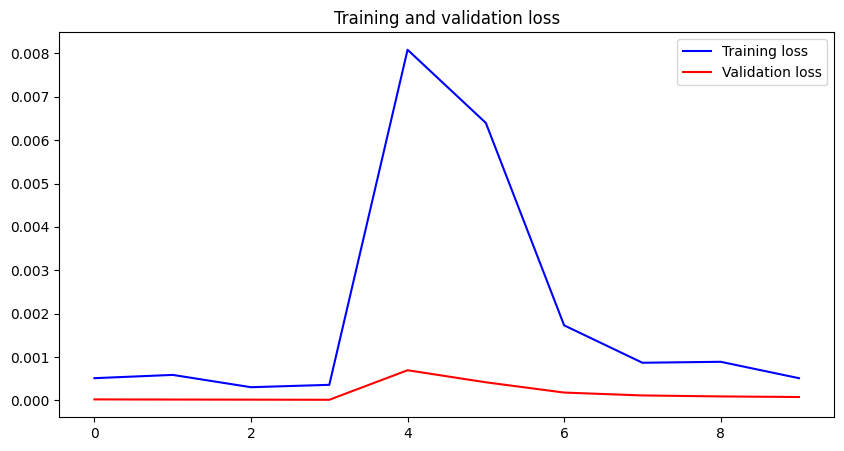

1/1 [==============================] - 0s 51ms/step - loss: 7.6899e-05 - accuracy: 1.0000
Epoch 1/10
11/11 [==============================] - 2s 170ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 9.2338e-05 - val_accuracy: 1.0000
Epoch 2/10
11/11 [==============================] - 2s 166ms/step - loss: 5.6769e-04 - accuracy: 1.0000 - val_loss: 9.9982e-05 - val_accuracy: 1.0000
Epoch 3/10
11/11 [==============================] - 2s 165ms/step - loss: 4.0299e-04 - accuracy: 1.0000 - val_loss: 9.7638e-05 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 2s 166ms/step - loss: 5.9031e-04 - accuracy: 1.0000 - val_loss: 8.2208e-05 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 2s 166ms/step - loss: 3.0748e-04 - accuracy: 1.0000 - val_loss: 7.2496e-05 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 2s 166ms/step - loss: 2.2688e-04 - accuracy: 1.0000 - val_loss: 7.0083e-05 - val_accuracy: 1.0000
Epoch 7/10
11/

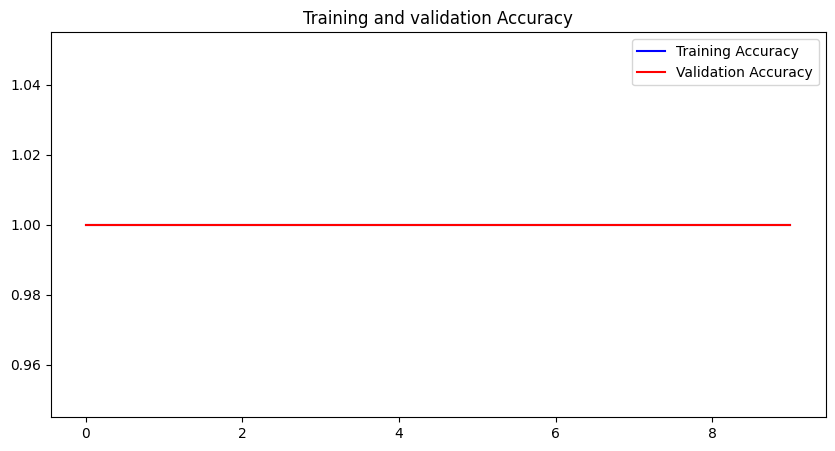

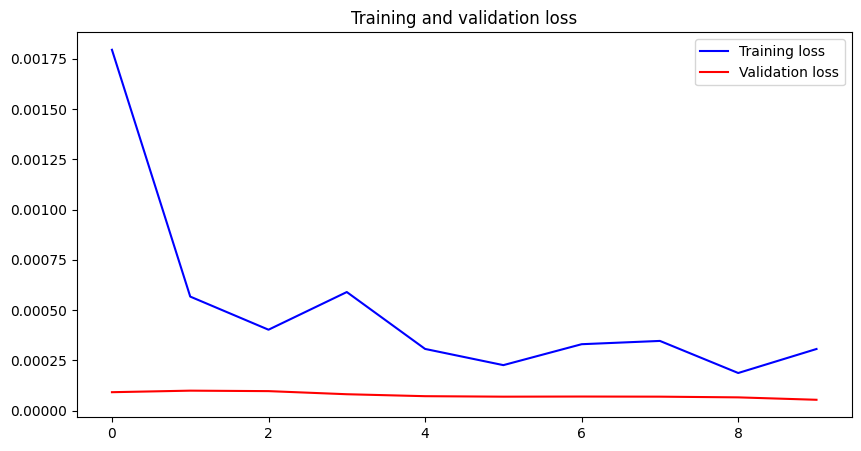

1/1 [==============================] - 0s 51ms/step - loss: 5.4620e-05 - accuracy: 1.0000
Epoch 1/10
11/11 [==============================] - 2s 170ms/step - loss: 2.0362e-04 - accuracy: 1.0000 - val_loss: 8.4141e-06 - val_accuracy: 1.0000
Epoch 2/10
11/11 [==============================] - 2s 166ms/step - loss: 2.3171e-04 - accuracy: 1.0000 - val_loss: 7.1723e-06 - val_accuracy: 1.0000
Epoch 3/10
11/11 [==============================] - 2s 166ms/step - loss: 1.8952e-04 - accuracy: 1.0000 - val_loss: 5.8710e-06 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 2s 166ms/step - loss: 2.7579e-04 - accuracy: 1.0000 - val_loss: 4.7385e-06 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 2s 166ms/step - loss: 2.4171e-04 - accuracy: 1.0000 - val_loss: 4.5895e-06 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 2s 165ms/step - loss: 2.3022e-04 - accuracy: 1.0000 - val_loss: 4.2617e-06 - val_accuracy: 1.0000
Epoch 7/10

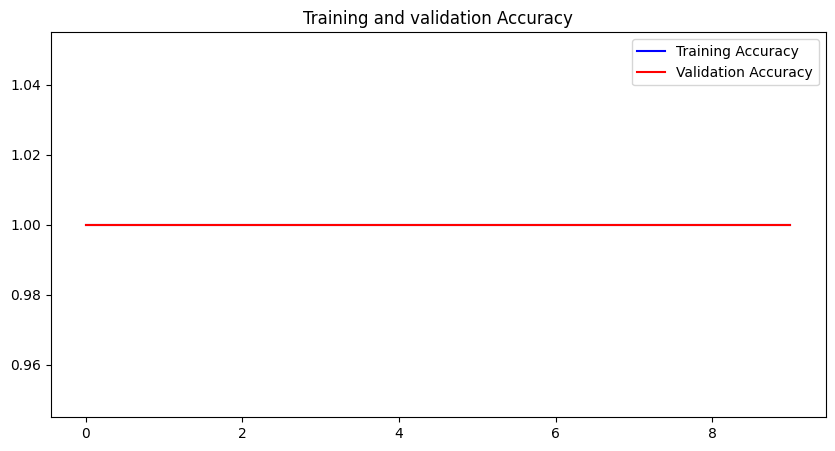

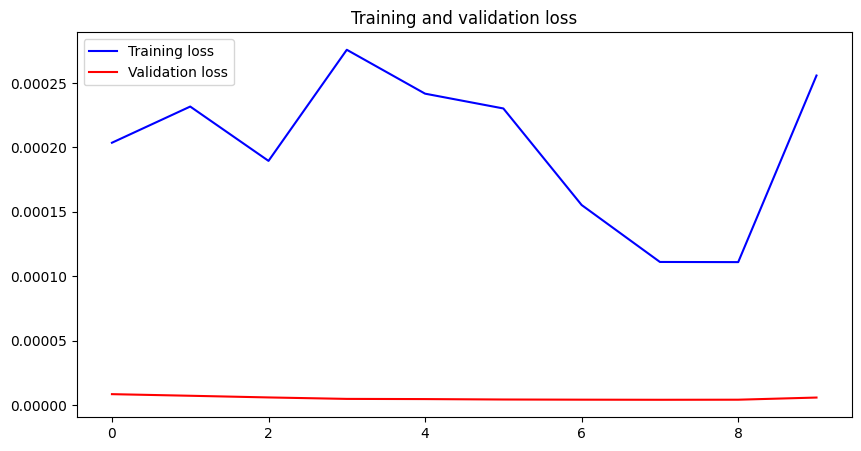

1/1 [==============================] - 0s 51ms/step - loss: 5.7816e-06 - accuracy: 1.0000
Epoch 1/10
11/11 [==============================] - 2s 168ms/step - loss: 1.4441e-04 - accuracy: 1.0000 - val_loss: 1.2119e-05 - val_accuracy: 1.0000
Epoch 2/10
11/11 [==============================] - 2s 165ms/step - loss: 1.1469e-04 - accuracy: 1.0000 - val_loss: 1.1484e-05 - val_accuracy: 1.0000
Epoch 3/10
11/11 [==============================] - 2s 166ms/step - loss: 1.2341e-04 - accuracy: 1.0000 - val_loss: 1.1027e-05 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 2s 166ms/step - loss: 1.3531e-04 - accuracy: 1.0000 - val_loss: 1.0858e-05 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 2s 166ms/step - loss: 1.9153e-04 - accuracy: 1.0000 - val_loss: 1.0421e-05 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 2s 165ms/step - loss: 5.1116e-05 - accuracy: 1.0000 - val_loss: 9.8644e-06 - val_accuracy: 1.0000
Epoch 7/10

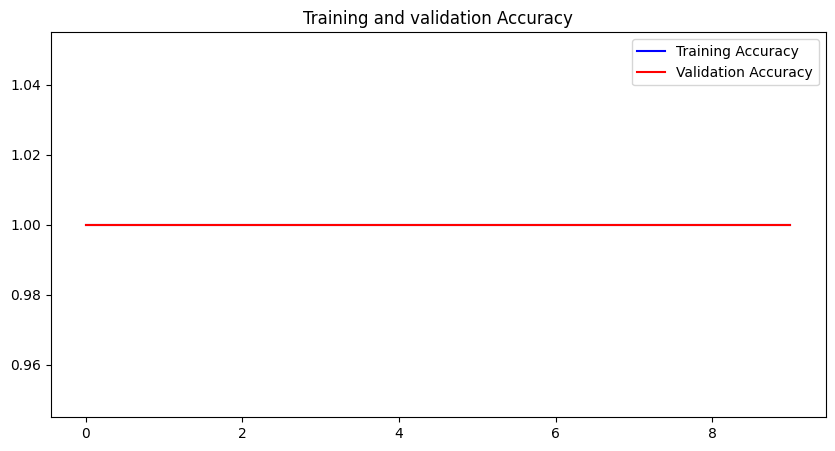

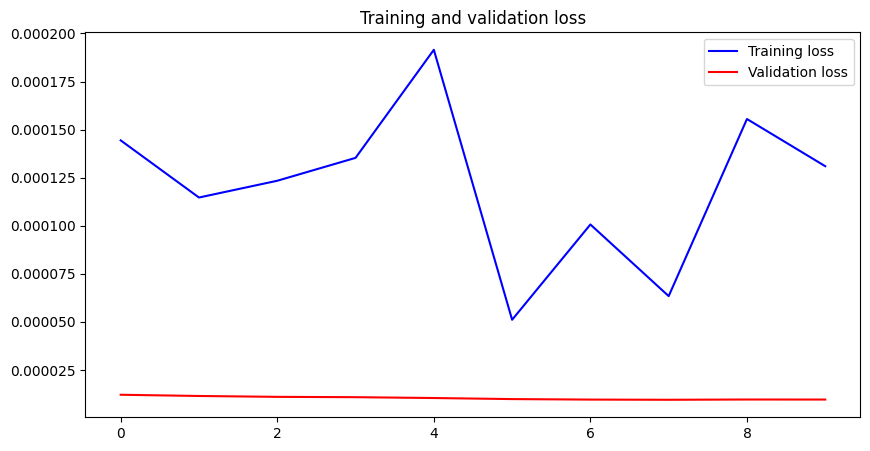

1/1 [==============================] - 0s 52ms/step - loss: 9.6260e-06 - accuracy: 1.0000
Epoch 1/10
11/11 [==============================] - 2s 169ms/step - loss: 1.9014e-04 - accuracy: 1.0000 - val_loss: 2.6623e-06 - val_accuracy: 1.0000
Epoch 2/10
11/11 [==============================] - 2s 166ms/step - loss: 3.3970e-04 - accuracy: 1.0000 - val_loss: 4.2815e-06 - val_accuracy: 1.0000
Epoch 3/10
11/11 [==============================] - 2s 166ms/step - loss: 4.5645e-05 - accuracy: 1.0000 - val_loss: 7.4304e-06 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 2s 166ms/step - loss: 1.2034e-04 - accuracy: 1.0000 - val_loss: 7.9172e-06 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 2s 166ms/step - loss: 1.6871e-04 - accuracy: 1.0000 - val_loss: 6.1590e-06 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 2s 167ms/step - loss: 1.1290e-04 - accuracy: 1.0000 - val_loss: 5.2848e-06 - val_accuracy: 1.0000
Epoch 7/10

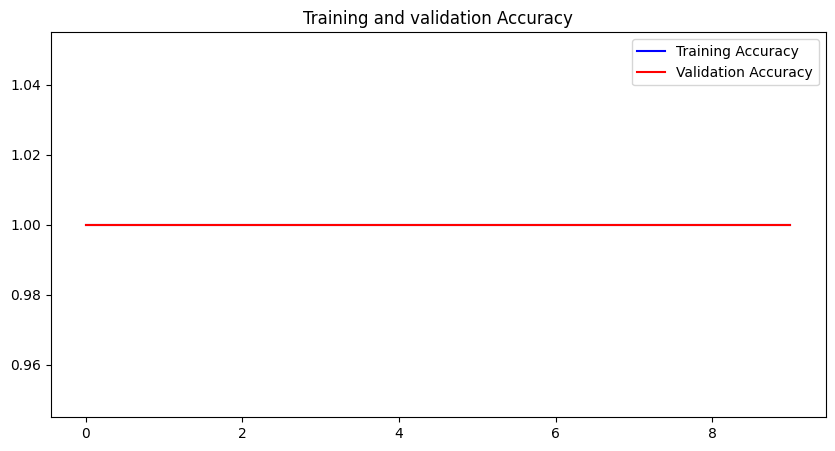

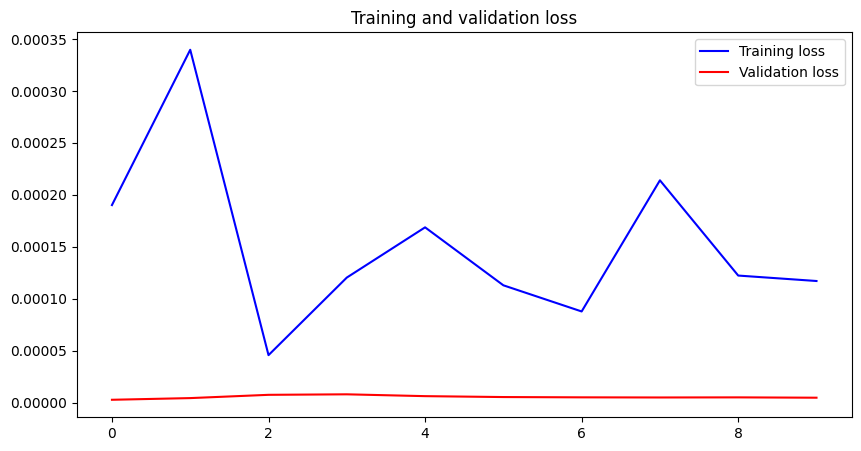

1/1 [==============================] - 0s 51ms/step - loss: 4.6590e-06 - accuracy: 1.0000


In [69]:
weights_list = []

accuracy_train = []
loss_train = []

accuracy_val = []
loss_val = []

# Iterate over the folds
for train_indices, val_indices in kfold.split(cnn_images): # labels
    history_model_cnn_drop = model_cnn_drop.fit(data_norm(cnn_images[train_indices]), labels[train_indices],
                  validation_data=(data_norm(cnn_images[val_indices]), labels[val_indices]),
                  epochs=10,
                  batch_size=batch_size,
                  verbose=1
                  )

    plot_cnn_history(history_model_cnn_drop)

    train_loss, train_accuracy = model_cnn_drop.evaluate(data_norm(cnn_images[train_indices]), labels[train_indices])
    accuracy_train.append(train_accuracy)
    loss_train.append(train_loss)

    val_loss, val_accuracy = model_cnn_drop.evaluate(data_norm(cnn_images[val_indices]), labels[val_indices])
    accuracy_val.append(val_accuracy)
    loss_val.append(val_loss)

    weights_list.append(model_cnn_drop.get_weights())


We still overview fast overfitting. But validation loss now is under train one most of the time that is actually good.

In [70]:
print("Average Accuracy:", np.mean(accuracy_val))
print("Maximum Accuracy:", np.max(accuracy_val))
print("Average Loss:", np.mean(loss_val))
print("Minimum Loss:", np.min(loss_val))

Average Accuracy: 0.9666666686534882
Maximum Accuracy: 1.0
Average Loss: 0.12960979614008467
Minimum Loss: 4.659001660911599e-06


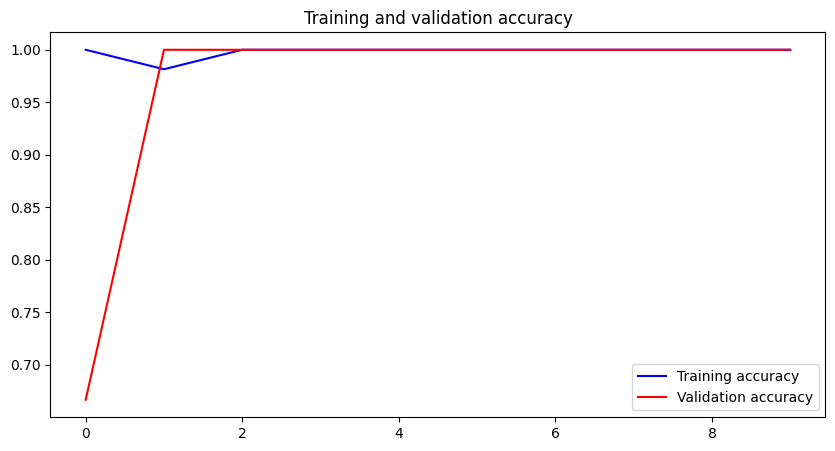

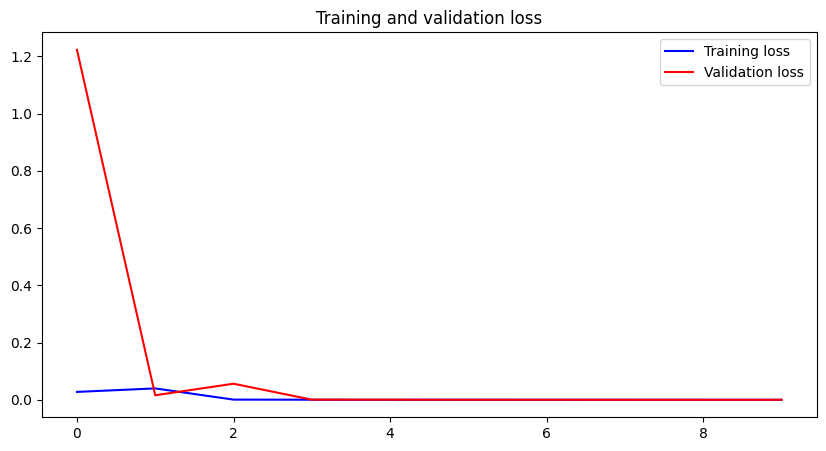

In [71]:
plot_cnn_folds(accuracy_train, accuracy_val, loss_train, loss_val)

In [72]:
# Average the weights
average_weights = np.mean(weights_list, axis=0)

model_cnn_drop.set_weights(average_weights)

# train_test_split without stratificaion by labels and random_seed
test_loss, test_accuracy = model_cnn_drop.evaluate(data_norm(cnn_images_test), labels_test_test)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

# Average Accuracy: 0.9666666686534882
# Average Loss: 0.12960979614008467

2/2 [==============================] - 0s 98ms/step - loss: 0.8093 - accuracy: 0.8167
Test Accuracy: 0.8166666626930237
Test Loss: 0.8093189597129822


In [73]:
# without stratificaion by labels and random_seed
cnn_images_test, cnn_images_rest, labels_test_test, labels_test_rest  = train_test_split(cnn_test_images, labels_test, train_size=0.5)

test_loss, test_accuracy = model_cnn_drop.evaluate(data_norm(cnn_images_test), labels_test_test)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

2/2 [==============================] - 0s 96ms/step - loss: 1.1558 - accuracy: 0.7333
Test Accuracy: 0.7333333492279053
Test Loss: 1.1558380126953125


In [74]:
# without stratificaion by labels and random_seed
cnn_images_test, cnn_images_rest, labels_test_test, labels_test_rest  = train_test_split(cnn_test_images, labels_test, train_size=0.5)

test_loss, test_accuracy = model_cnn_drop.evaluate(data_norm(cnn_images_test), labels_test_test)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

2/2 [==============================] - 0s 98ms/step - loss: 0.8050 - accuracy: 0.8000
Test Accuracy: 0.800000011920929
Test Loss: 0.8049522042274475


# Gray scaled images

1. Advantages:
- Simplicity: Grayscale images have only one channel, making them computationally efficient and simpler to process.
- Reduced memory requirements: With a single channel, grayscale images require less memory compared to 3-channel RGB images or 2-channel representations.
- Useful for certain tasks: Grayscale images can still be effective for tasks that do not heavily rely on color information, such as edge detection or texture analysis.

2. Considerations:
- Loss of color information: By converting images to grayscale, you lose color information that might be relevant for the task at hand, such as object recognition based on color cues.
- Task-specific requirements: Some computer vision tasks may inherently require color information, such as object classification based on distinctive color patterns or fine-grained color-based distinctions.

## Data

In [17]:
def cvt_two_channels(images):
  two_channel_images = []

  # Convert each image to grayscale and create 2-channel images
  for image in images:
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Create a new 2-channel image by replicating the grayscale channel
    #two_channel_image = np.repeat(gray_image[:, :, np.newaxis], 2, axis=2)
    gray_image = np.reshape(gray_image, (256, 256, 1))
    two_channel_images.append(gray_image)

  two_channel_images = np.array(two_channel_images)

  return two_channel_images

In [78]:
print(type(cnn_images), end='\n\n')
print(cnn_images.shape)
print(cnn_images[0].shape)
cnn_images[0]

<class 'numpy.ndarray'>

(120, 256, 256, 3)
(256, 256, 3)


array([[[ 89.,  80., 107.],
        [ 86.,  77., 104.],
        [ 82.,  73., 100.],
        ...,
        [ 85.,  82.,  98.],
        [ 78.,  73.,  88.],
        [121., 116., 131.]],

       [[ 81.,  72.,  99.],
        [ 76.,  67.,  94.],
        [ 71.,  62.,  89.],
        ...,
        [ 69.,  66.,  82.],
        [ 62.,  57.,  72.],
        [105., 100., 115.]],

       [[ 73.,  64.,  90.],
        [ 68.,  59.,  85.],
        [ 61.,  52.,  78.],
        ...,
        [ 62.,  59.,  75.],
        [ 56.,  51.,  66.],
        [101.,  96., 111.]],

       ...,

       [[112., 134., 152.],
        [118., 140., 158.],
        [119., 140., 161.],
        ...,
        [ 53.,  52.,  62.],
        [ 51.,  47.,  58.],
        [132., 127., 136.]],

       [[116., 136., 153.],
        [118., 138., 155.],
        [116., 136., 154.],
        ...,
        [ 52.,  51.,  61.],
        [ 46.,  42.,  53.],
        [125., 120., 129.]],

       [[117., 138., 153.],
        [115., 136., 151.],
        [110., 1

In [18]:
cnn_images_gray = cvt_two_channels(cnn_images)

print(type(cnn_images_gray), end='\n\n')
print(cnn_images_gray.shape)
print(cnn_images_gray[0].shape)
cnn_images_gray[0]

<class 'numpy.ndarray'>

(120, 256, 256, 1)
(256, 256, 1)


array([[[ 85.769   ],
        [ 82.769005],
        [ 78.769005],
        ...,
        [ 84.721   ],
        [ 76.205   ],
        [119.205   ]],

       [[ 77.769005],
        [ 72.769005],
        [ 67.769005],
        ...,
        [ 68.721   ],
        [ 60.204998],
        [103.205   ]],

       [[ 69.655   ],
        [ 64.655   ],
        [ 57.655   ],
        ...,
        [ 61.720997],
        [ 54.204998],
        [ 99.205   ]],

       ...,

       [[129.474   ],
        [135.474   ],
        [136.115   ],
        ...,
        [ 53.439   ],
        [ 49.45    ],
        [129.52101 ]],

       [[131.958   ],
        [133.95801 ],
        [132.072   ],
        ...,
        [ 52.439   ],
        [ 44.45    ],
        [122.521   ]],

       [[133.431   ],
        [131.431   ],
        [125.95801 ],
        ...,
        [ 55.439003],
        [ 42.449997],
        [117.521   ]]], dtype=float32)

In [86]:
print(type(cnn_test_images), end='\n\n')
print(cnn_test_images.shape)
print(cnn_test_images[0].shape)
#cnn_test_images[0]

<class 'numpy.ndarray'>

(120, 256, 256, 3)
(256, 256, 3)


In [19]:
cnn_test_images_gray = cvt_two_channels(cnn_test_images)

print(type(cnn_test_images_gray), end='\n\n')
print(cnn_test_images_gray.shape)
print(cnn_test_images_gray[0].shape)
cnn_test_images_gray[0]

<class 'numpy.ndarray'>

(120, 256, 256, 1)
(256, 256, 1)


array([[[130.416  ],
        [155.41599],
        [150.416  ],
        ...,
        [152.416  ],
        [157.416  ],
        [131.416  ]],

       [[162.416  ],
        [187.416  ],
        [182.416  ],
        ...,
        [184.416  ],
        [189.416  ],
        [163.416  ]],

       [[160.416  ],
        [185.41599],
        [180.416  ],
        ...,
        [182.416  ],
        [187.416  ],
        [161.416  ]],

       ...,

       [[167.274  ],
        [194.274  ],
        [191.274  ],
        ...,
        [186.87201],
        [190.872  ],
        [164.87201]],

       [[173.23099],
        [200.231  ],
        [196.274  ],
        ...,
        [188.801  ],
        [192.801  ],
        [167.801  ]],

       [[138.231  ],
        [165.231  ],
        [160.274  ],
        ...,
        [152.80101],
        [156.801  ],
        [131.801  ]]], dtype=float32)

In [16]:
print(type(cae_images), end='\n\n')
print(cae_images.shape)
print(cae_images[0].shape)
#cae_images[0]

<class 'numpy.ndarray'>

(5000, 256, 256, 3)
(256, 256, 3)


In [19]:
cae_images_gray = cvt_two_channels(cae_images)

print(type(cae_images_gray), end='\n\n')
print(cae_images_gray.shape)
print(cae_images_gray[0].shape)
cae_images_gray[0]

<class 'numpy.ndarray'>

(5000, 256, 256, 1)
(256, 256, 1)


array([[[1.6928700e+02],
        [1.6828700e+02],
        [1.6628700e+02],
        ...,
        [1.9948801e+02],
        [1.9996101e+02],
        [2.0196100e+02]],

       [[1.7428700e+02],
        [1.7228700e+02],
        [1.7028700e+02],
        ...,
        [2.0048801e+02],
        [1.9996101e+02],
        [1.9896100e+02]],

       [[1.7891699e+02],
        [1.7791699e+02],
        [1.7591701e+02],
        ...,
        [2.0089000e+02],
        [1.9789000e+02],
        [1.9488998e+02]],

       ...,

       [[2.9180000e+00],
        [4.9179997e+00],
        [5.5590000e+00],
        ...,
        [3.5160000e+00],
        [1.5160000e+00],
        [1.1400000e-01]],

       [[3.9180000e+00],
        [6.9180002e+00],
        [7.5590000e+00],
        ...,
        [9.5159998e+00],
        [6.5160003e+00],
        [8.1500000e-01]],

       [[4.9179997e+00],
        [7.9179997e+00],
        [9.5590000e+00],
        ...,
        [1.5516000e+01],
        [1.2516000e+01],
        [5.5159998e+00]]

## Models

In [20]:
CLASS_NUM            = 3
IMG_SIZE             = 256
IMG_CHANNELS         = 1
batch_size           = 10
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

### CAE model

In [25]:
K.clear_session()

In [26]:
# CAE model
def create_cae_model_gray():
    model = Sequential()

    # Encoder part
    model.add(Conv2D(100, (5, 5), input_shape=input_shape, activation='relu', padding='same',))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(200, (5, 5), activation='relu', padding='same',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Decoder part
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(200, (5, 5), activation='relu', padding='same',))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(100, (5, 5), activation='relu', padding='same',))

    # Output layer
    # The final output layer has 1 channels corresponding to the reconstructed gray scaled image.
    model.add(Conv2DTranspose(1, (5, 5), activation='sigmoid', padding='same'))

    return model


# Create the CAE model
model_cae_gray = create_cae_model_gray()

model_cae_gray.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 100)     2600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 100)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 200)     500200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 200)      0         
 2D)                                                             
                                                                 
 up_sampling2d (UpSampling2D  (None, 128, 128, 200)    0         
 )                                                               
                                                        

In [27]:
# Compile the model
model_cae_gray.compile(loss='mean_squared_error',
                       optimizer=SGD(learning_rate=0.01),
                       metrics=['mae'])

In [28]:
# Learning rate decay function
def lr_decay(epoch, learning_rate):
    if epoch == 0:
        return 0.01
    else:
        return learning_rate * 0.98


# Define the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_decay)

In [29]:
# Custom data generator with random pixel removal
def data_generator(images, batch_size=batch_size):
    num_samples = len(images)
    while True:
        indices = np.random.choice(num_samples, batch_size, replace=False)
        batch_images = []
        for index in indices:
            img = images[index]
            img = img.astype('float32') / 255 - 0.5 # normalizing image data
            # Randomly remove 20% of pixels
            mask = np.random.choice([0, 1], size=img.shape[:2], p=[0.2, 0.8])
            masked_img = img.copy()
            masked_img[mask == 0] = 0
            batch_images.append(masked_img)
        yield np.array(batch_images), np.array(batch_images)


In [31]:
cae_images_train, cae_images_val = train_test_split(cae_images_gray, test_size = 0.2, random_state=42)
print('Train shape:', cae_images_train.shape)
print('Test shape:', cae_images_val.shape)

Train shape: (4000, 256, 256, 1)
Test shape: (1000, 256, 256, 1)


In [33]:
# Train the model with learning rate scheduler and data generator
checkpoint_cae_gray = ModelCheckpoint('/content/drive/MyDrive/art_recognition_tech/best_model_cae_gray.hdf5',
                                      monitor=['mae'],
                                      verbose=1,
                                      mode='min')

history_model_cae_gray = model_cae_gray.fit(data_generator(cae_images_train),
                                            steps_per_epoch=len(cae_images_train)//batch_size,
                                            epochs=10,
                                            validation_data=(data_generator(cae_images_val)),
                                            validation_steps=len(cae_images_val)//batch_size,
                                            callbacks=[lr_scheduler, checkpoint_cae_gray],
                                            verbose=1
                                            )

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.0689 - mae: 0.2031
Epoch 1: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_gray.hdf5
400/400 [==============================] - 256s 566ms/step - loss: 0.0689 - mae: 0.2031 - val_loss: 0.0481 - val_mae: 0.1669 - lr: 0.0100
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.0481 - mae: 0.1657
Epoch 2: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_gray.hdf5
400/400 [==============================] - 227s 567ms/step - loss: 0.0481 - mae: 0.1657 - val_loss: 0.0482 - val_mae: 0.1654 - lr: 0.0098
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.0470 - mae: 0.1619
Epoch 3: saving model to /content/drive/MyDrive/art_recognition_tech/best_model_cae_gray.hdf5
400/400 [==============================] - 227s 567ms/step - loss: 0.0470 - mae: 0.1619 - val_loss: 0.0479 - val_mae: 0.1635 - lr: 0.0096
Epoch 4/10
400/400 [===========

In [34]:
model_cae_gray.get_metrics_result()

# 3-channel
# {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.051500384>,
# 'mae': <tf.Tensor: shape=(), dtype=float32, numpy=0.17399763>}

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.04850436>,
 'mae': <tf.Tensor: shape=(), dtype=float32, numpy=0.16505122>}

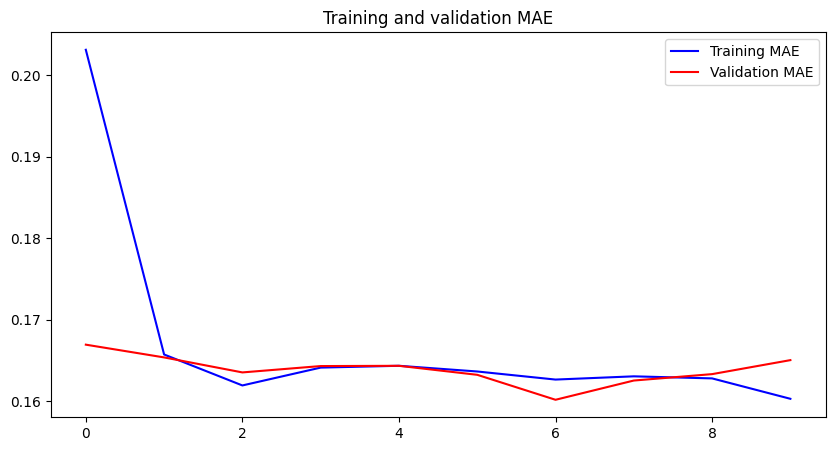

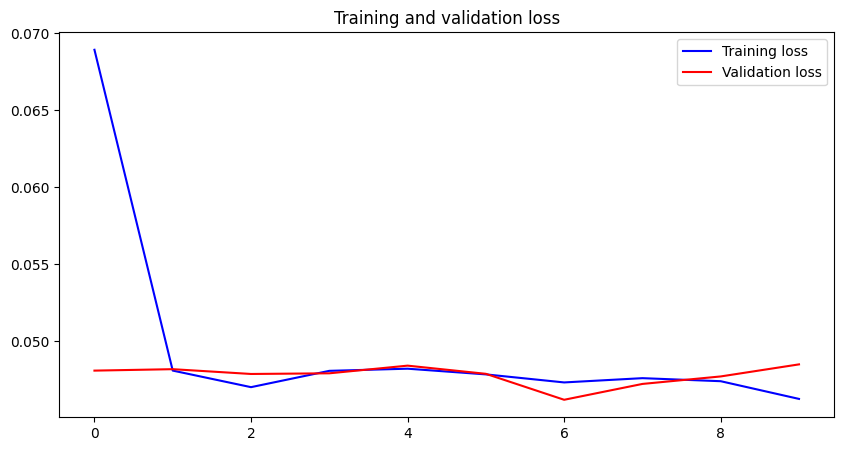

In [35]:
plot_cae_history(history_model_cae_gray)

### CNN with Dropout

In [21]:
K.clear_session()

In [22]:
# Load the trained CAE model
best_model_cae_gray = load_model('/content/drive/MyDrive/art_recognition_tech/best_model_cae_gray.hdf5') # h5

# Remove the decoder layers of the CAE
encoder_model = Sequential(best_model_cae_gray.layers[:-5]) # decoder_layers_to_remove

encoder_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 100)     2600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 100)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 200)     500200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 200)      0         
 2D)                                                             
                                                                 
Total params: 502,800
Trainable params: 502,800
Non-trainable params: 0
_________________________________________________________________


In [23]:
# CNN model
def CNN_model_drop_gray():
    model = Sequential()
    # Initialize the CNN with CAE encoder layers
    for layer in encoder_model.layers:
        model.add(layer)

    # Additional layers for classification
    model.add(Flatten())
    model.add(Dense(400, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(200, activation='relu'))

    model.add(Dense(CLASS_NUM, activation='softmax'))

    # Initialize the CNN with CAE weights
    for i, layer in enumerate(encoder_model.layers):
        model.layers[i].set_weights(layer.get_weights())

    return model


# Create the CNN model
model_cnn_drop_gray = CNN_model_drop_gray()
model_cnn_drop_gray.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 100)     2600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 100)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 200)     500200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 200)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 819200)            0         
                                                                 
 dense (Dense)               (None, 400)              

In [24]:
# Compile the model
model_cnn_drop_gray.compile(optimizer=Adam(0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

In [25]:
def data_norm(images):
  norm_images = []
  for img in images:
    img = img.astype('float32') / 255 - 0.5 # normalizing image data
    norm_images.append(img)

  return np.array(norm_images)

In [26]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_indices, val_indices) in enumerate(kfold.split(cnn_images_gray)):
  print(f'Test size in a fold {fold} is {len(val_indices)/(len(train_indices)+len(val_indices))*100}%')

Test size in a fold 0 is 10.0%
Test size in a fold 1 is 10.0%
Test size in a fold 2 is 10.0%
Test size in a fold 3 is 10.0%
Test size in a fold 4 is 10.0%
Test size in a fold 5 is 10.0%
Test size in a fold 6 is 10.0%
Test size in a fold 7 is 10.0%
Test size in a fold 8 is 10.0%
Test size in a fold 9 is 10.0%


Epoch 1/10
11/11 [==============================] - 17s 385ms/step - loss: 2.5354 - accuracy: 0.3704 - val_loss: 1.1838 - val_accuracy: 0.2500
Epoch 2/10
11/11 [==============================] - 2s 168ms/step - loss: 1.2641 - accuracy: 0.4352 - val_loss: 1.2033 - val_accuracy: 0.1667
Epoch 3/10
11/11 [==============================] - 2s 167ms/step - loss: 0.9885 - accuracy: 0.5370 - val_loss: 1.0386 - val_accuracy: 0.5000
Epoch 4/10
11/11 [==============================] - 2s 167ms/step - loss: 0.8918 - accuracy: 0.5648 - val_loss: 0.9444 - val_accuracy: 0.5000
Epoch 5/10
11/11 [==============================] - 2s 168ms/step - loss: 0.7485 - accuracy: 0.6204 - val_loss: 0.8756 - val_accuracy: 0.5833
Epoch 6/10
11/11 [==============================] - 2s 168ms/step - loss: 0.6578 - accuracy: 0.7500 - val_loss: 1.2262 - val_accuracy: 0.6667
Epoch 7/10
11/11 [==============================] - 2s 168ms/step - loss: 0.5182 - accuracy: 0.8148 - val_loss: 1.1877 - val_accuracy: 0.5833
Epoch

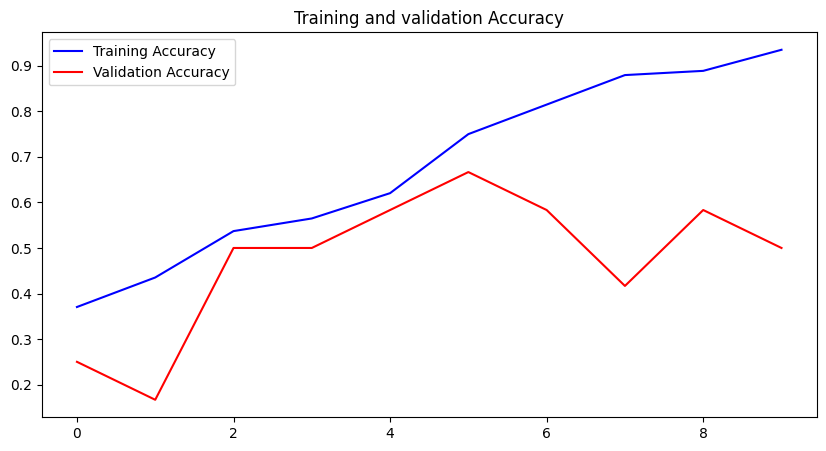

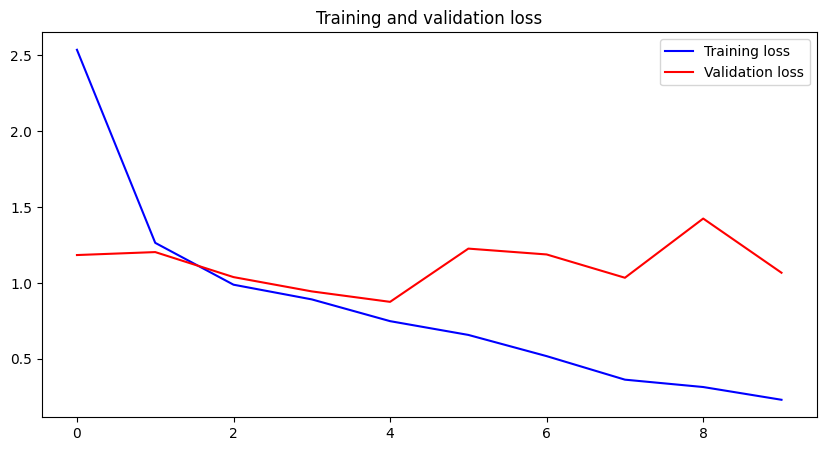

1/1 [==============================] - 0s 50ms/step - loss: 1.0673 - accuracy: 0.5000
Epoch 1/10
11/11 [==============================] - 2s 176ms/step - loss: 0.2620 - accuracy: 0.9074 - val_loss: 0.1354 - val_accuracy: 0.9167
Epoch 2/10
11/11 [==============================] - 2s 173ms/step - loss: 0.1984 - accuracy: 0.9537 - val_loss: 0.0822 - val_accuracy: 1.0000
Epoch 3/10
11/11 [==============================] - 2s 174ms/step - loss: 0.1573 - accuracy: 0.9537 - val_loss: 0.0687 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 2s 173ms/step - loss: 0.1120 - accuracy: 0.9722 - val_loss: 0.0743 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 2s 174ms/step - loss: 0.0871 - accuracy: 0.9815 - val_loss: 0.1815 - val_accuracy: 0.8333
Epoch 6/10
11/11 [==============================] - 2s 175ms/step - loss: 0.0376 - accuracy: 1.0000 - val_loss: 0.0669 - val_accuracy: 1.0000
Epoch 7/10
11/11 [==============================] - 2s 175ms/s

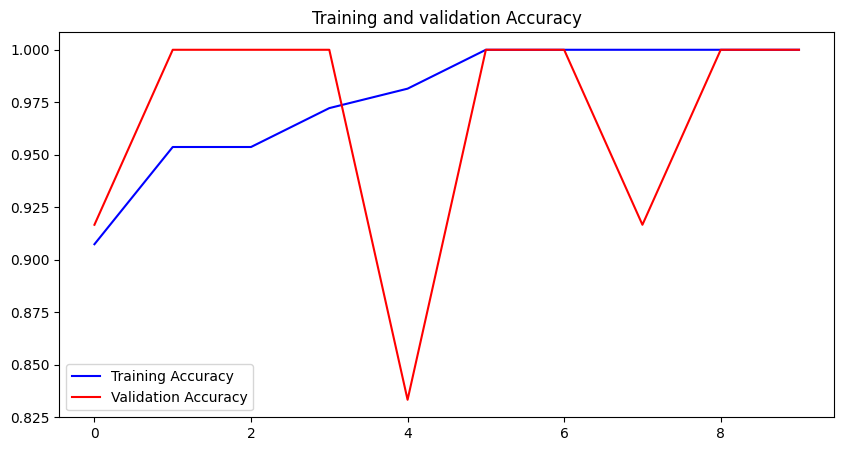

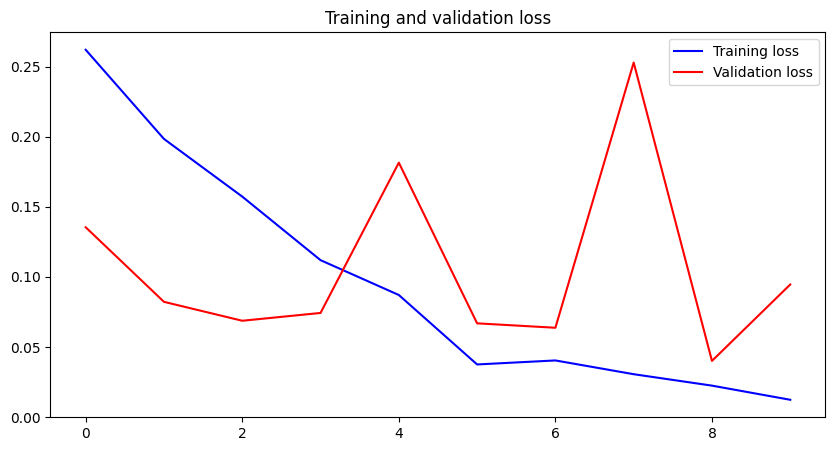

1/1 [==============================] - 0s 47ms/step - loss: 0.0946 - accuracy: 1.0000
Epoch 1/10
11/11 [==============================] - 2s 178ms/step - loss: 0.0294 - accuracy: 0.9907 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 2/10
11/11 [==============================] - 2s 175ms/step - loss: 0.0379 - accuracy: 0.9907 - val_loss: 0.0727 - val_accuracy: 1.0000
Epoch 3/10
11/11 [==============================] - 2s 173ms/step - loss: 0.1173 - accuracy: 0.9444 - val_loss: 0.0605 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 2s 174ms/step - loss: 0.0663 - accuracy: 0.9815 - val_loss: 0.0831 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 2s 173ms/step - loss: 0.0385 - accuracy: 0.9907 - val_loss: 0.0263 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 2s 173ms/step - loss: 0.0415 - accuracy: 0.9907 - val_loss: 0.0102 - val_accuracy: 1.0000
Epoch 7/10
11/11 [==============================] - 2s 172ms/s

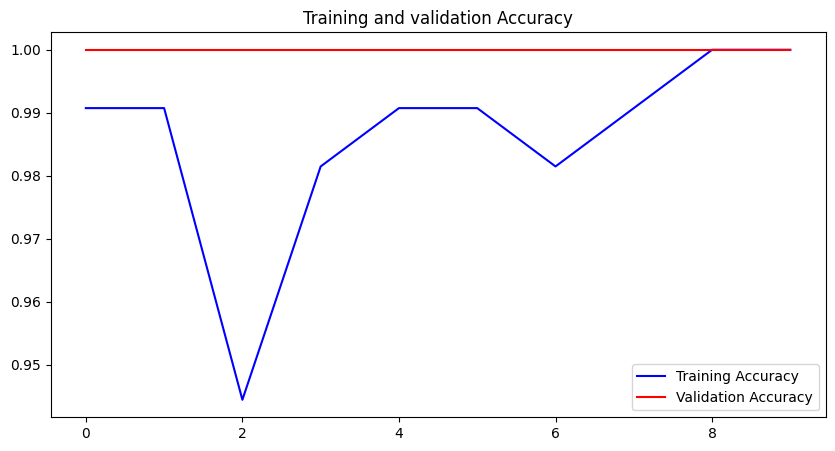

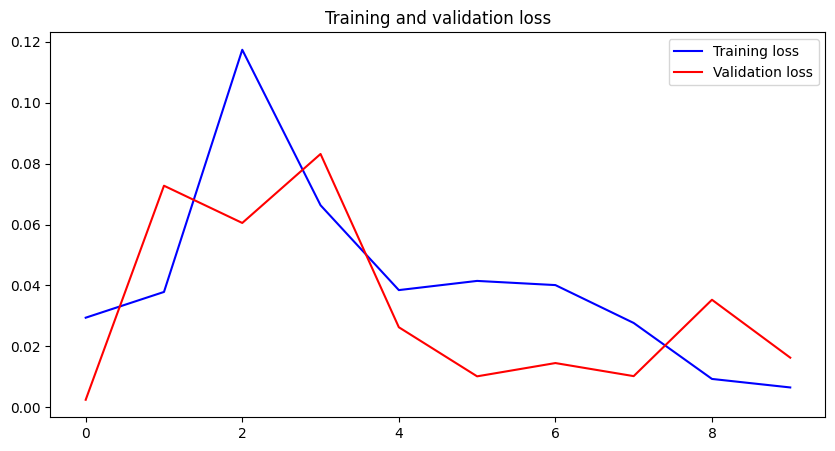

1/1 [==============================] - 0s 51ms/step - loss: 0.0163 - accuracy: 1.0000
Epoch 1/10
11/11 [==============================] - 2s 174ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 6.4591e-04 - val_accuracy: 1.0000
Epoch 2/10
11/11 [==============================] - 2s 170ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 3/10
11/11 [==============================] - 2s 170ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 4.3943e-04 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 2s 170ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 3.6340e-04 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 2s 170ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 7.9160e-04 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 2s 171ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 3.9803e-04 - val_accuracy: 1.0000
Epoch 7/10
11/11 [========================

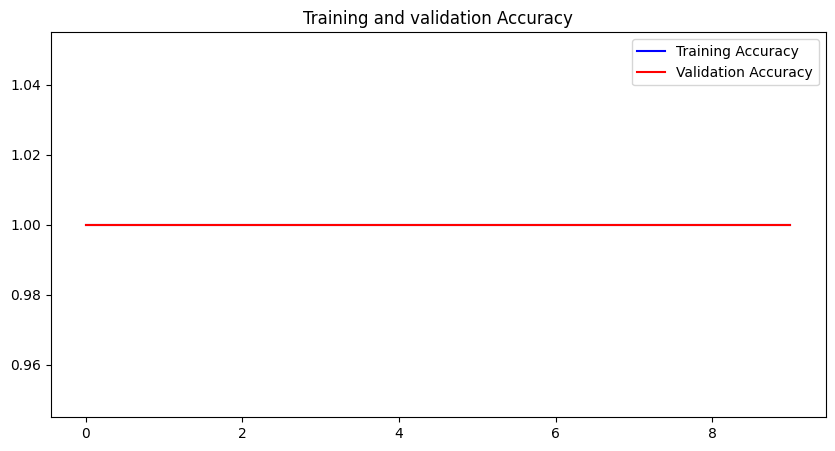

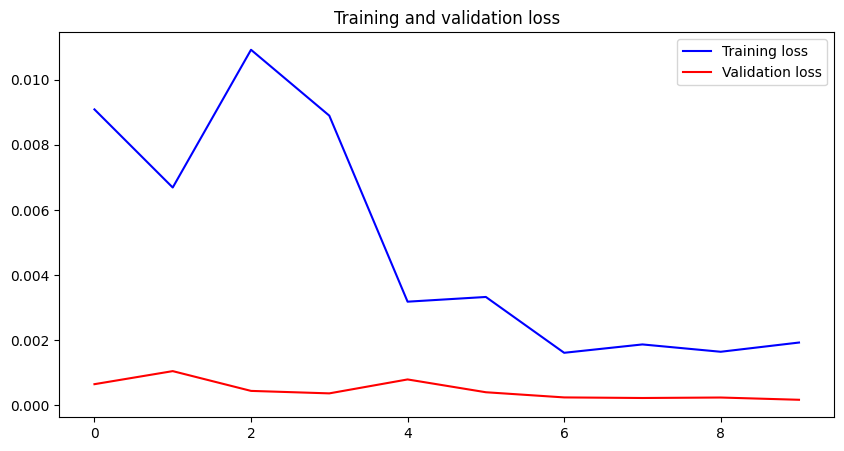

1/1 [==============================] - 0s 49ms/step - loss: 1.6650e-04 - accuracy: 1.0000
Epoch 1/10
11/11 [==============================] - 2s 176ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.3907e-04 - val_accuracy: 1.0000
Epoch 2/10
11/11 [==============================] - 2s 171ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 3.9740e-04 - val_accuracy: 1.0000
Epoch 3/10
11/11 [==============================] - 2s 171ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 4.5480e-04 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 2s 171ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 1.7312e-04 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 2s 171ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.6628e-04 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 2s 171ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 2.1432e-04 - val_accuracy: 1.0000
Epoch 7/10
11/11 [================

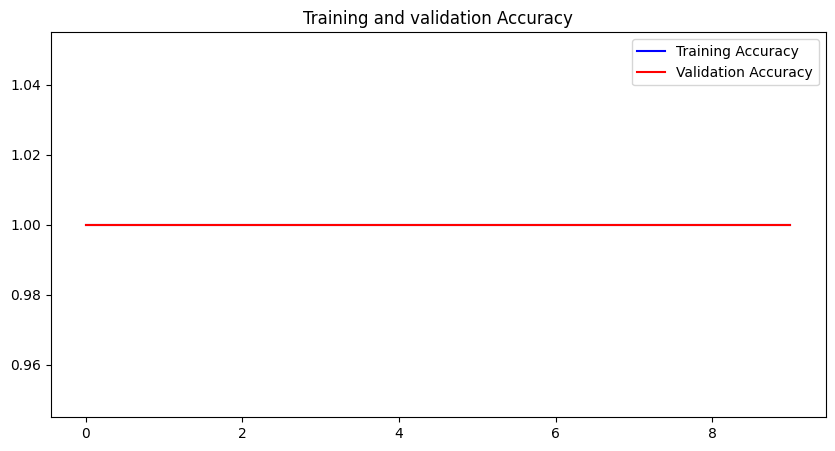

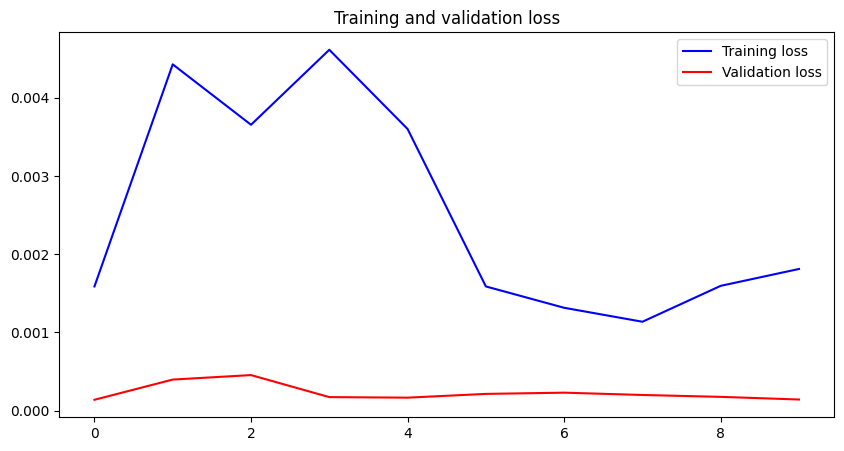

1/1 [==============================] - 0s 48ms/step - loss: 1.4256e-04 - accuracy: 1.0000
Epoch 1/10
11/11 [==============================] - 2s 176ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 4.0925e-05 - val_accuracy: 1.0000
Epoch 2/10
11/11 [==============================] - 2s 173ms/step - loss: 9.8827e-04 - accuracy: 1.0000 - val_loss: 6.0629e-05 - val_accuracy: 1.0000
Epoch 3/10
11/11 [==============================] - 2s 173ms/step - loss: 5.7023e-04 - accuracy: 1.0000 - val_loss: 9.3972e-05 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 2s 172ms/step - loss: 4.2780e-04 - accuracy: 1.0000 - val_loss: 1.1185e-04 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 2s 172ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 1.2007e-04 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 2s 173ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.1702e-04 - val_accuracy: 1.0000
Epoch 7/10
11/11 [====

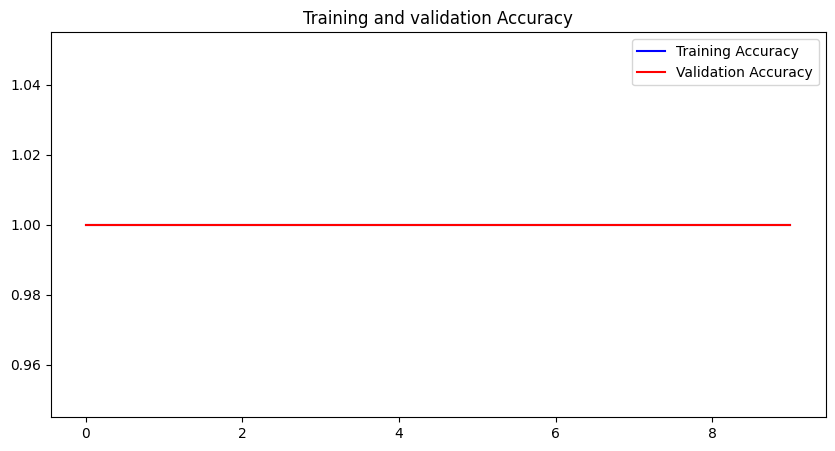

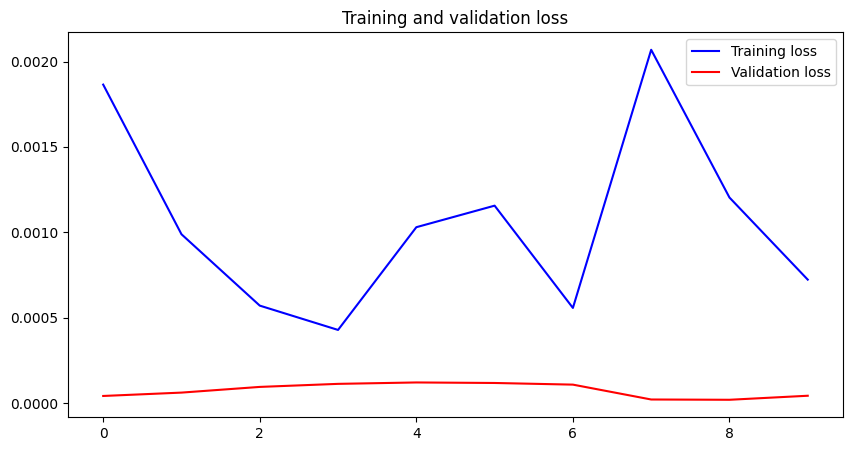

1/1 [==============================] - 0s 55ms/step - loss: 4.2234e-05 - accuracy: 1.0000
Epoch 1/10
11/11 [==============================] - 2s 175ms/step - loss: 3.7548e-04 - accuracy: 1.0000 - val_loss: 7.9426e-05 - val_accuracy: 1.0000
Epoch 2/10
11/11 [==============================] - 2s 172ms/step - loss: 4.0385e-04 - accuracy: 1.0000 - val_loss: 7.4261e-05 - val_accuracy: 1.0000
Epoch 3/10
11/11 [==============================] - 2s 172ms/step - loss: 4.3683e-04 - accuracy: 1.0000 - val_loss: 7.9913e-05 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 2s 172ms/step - loss: 2.8339e-04 - accuracy: 1.0000 - val_loss: 1.0771e-04 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 2s 172ms/step - loss: 3.0581e-04 - accuracy: 1.0000 - val_loss: 1.2027e-04 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 2s 172ms/step - loss: 4.3506e-04 - accuracy: 1.0000 - val_loss: 9.9439e-05 - val_accuracy: 1.0000
Epoch 7/10

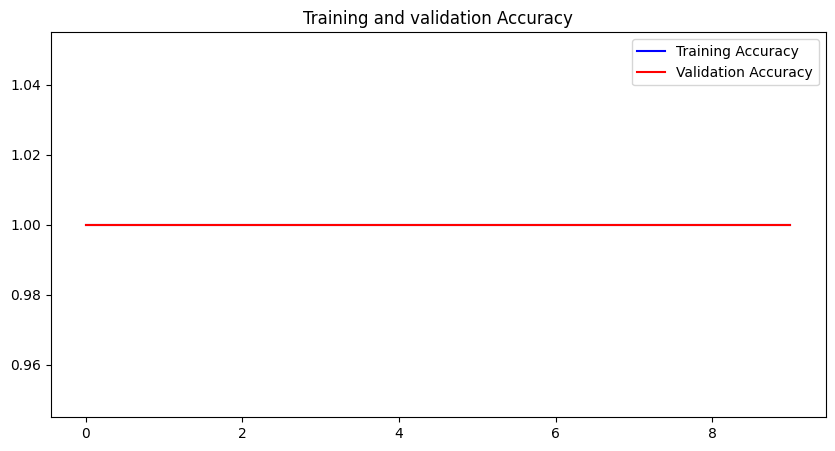

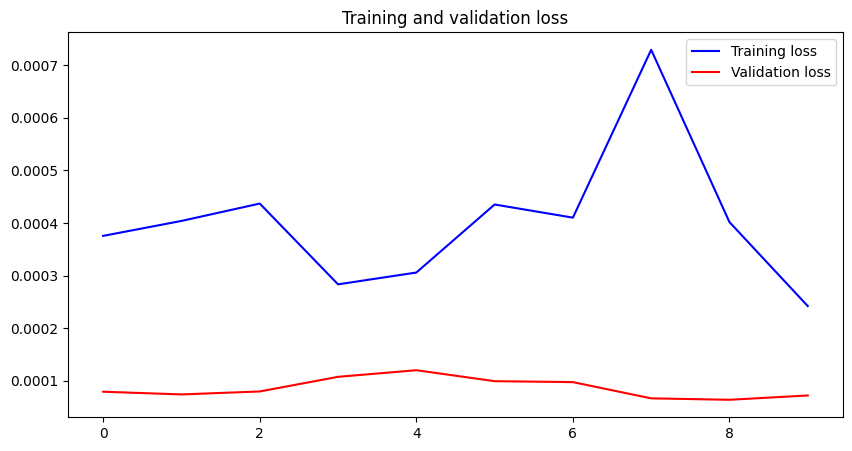

1/1 [==============================] - 0s 49ms/step - loss: 7.2284e-05 - accuracy: 1.0000
Epoch 1/10
11/11 [==============================] - 2s 176ms/step - loss: 1.9989e-04 - accuracy: 1.0000 - val_loss: 3.5174e-05 - val_accuracy: 1.0000
Epoch 2/10
11/11 [==============================] - 2s 172ms/step - loss: 3.2309e-04 - accuracy: 1.0000 - val_loss: 3.8323e-05 - val_accuracy: 1.0000
Epoch 3/10
11/11 [==============================] - 2s 172ms/step - loss: 6.6265e-04 - accuracy: 1.0000 - val_loss: 3.8641e-05 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 2s 172ms/step - loss: 4.4344e-04 - accuracy: 1.0000 - val_loss: 7.1235e-05 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 2s 171ms/step - loss: 3.3607e-04 - accuracy: 1.0000 - val_loss: 8.2625e-05 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 2s 172ms/step - loss: 4.9326e-04 - accuracy: 1.0000 - val_loss: 5.6000e-05 - val_accuracy: 1.0000
Epoch 7/10

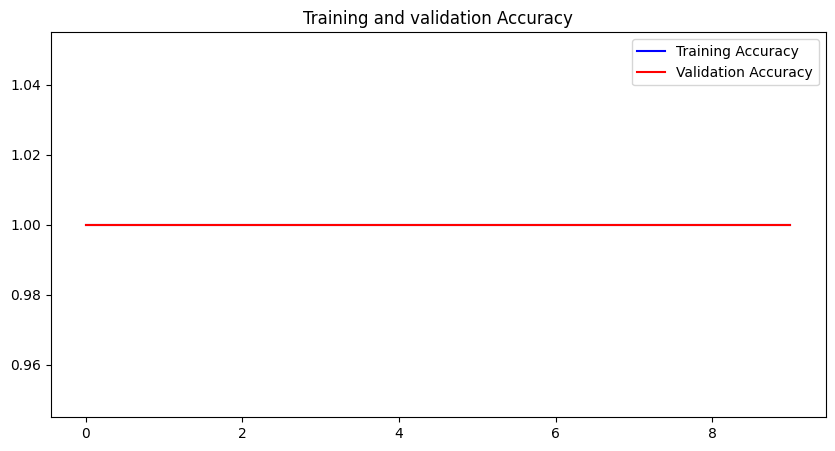

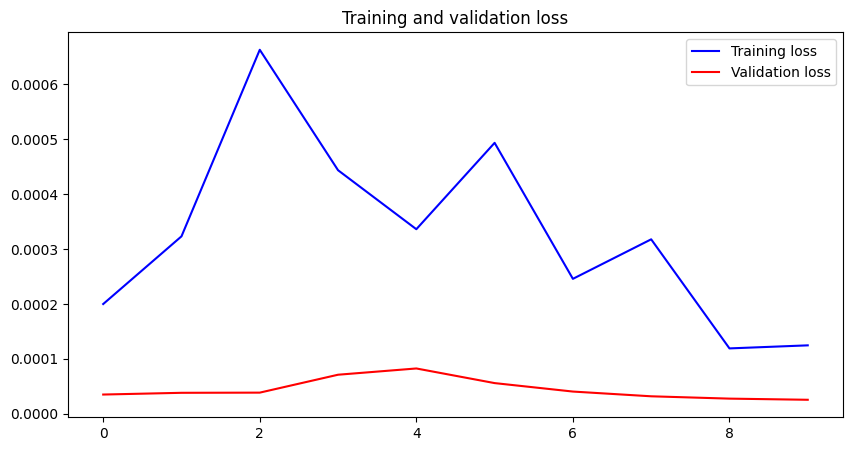

1/1 [==============================] - 0s 48ms/step - loss: 2.5639e-05 - accuracy: 1.0000
Epoch 1/10
11/11 [==============================] - 2s 175ms/step - loss: 5.2428e-04 - accuracy: 1.0000 - val_loss: 1.4046e-05 - val_accuracy: 1.0000
Epoch 2/10
11/11 [==============================] - 2s 172ms/step - loss: 2.0860e-04 - accuracy: 1.0000 - val_loss: 1.4593e-05 - val_accuracy: 1.0000
Epoch 3/10
11/11 [==============================] - 2s 171ms/step - loss: 2.7768e-04 - accuracy: 1.0000 - val_loss: 1.4553e-05 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 2s 171ms/step - loss: 2.1619e-04 - accuracy: 1.0000 - val_loss: 1.5606e-05 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 2s 171ms/step - loss: 3.1675e-04 - accuracy: 1.0000 - val_loss: 1.5725e-05 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 2s 178ms/step - loss: 4.5361e-04 - accuracy: 1.0000 - val_loss: 9.3975e-06 - val_accuracy: 1.0000
Epoch 7/10

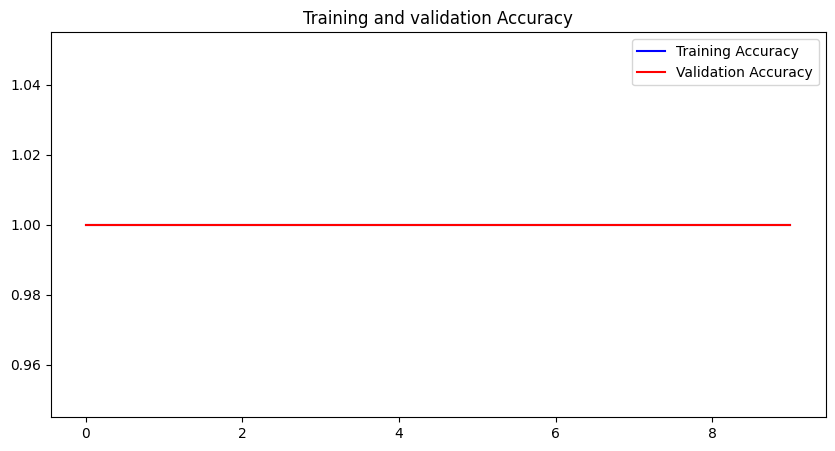

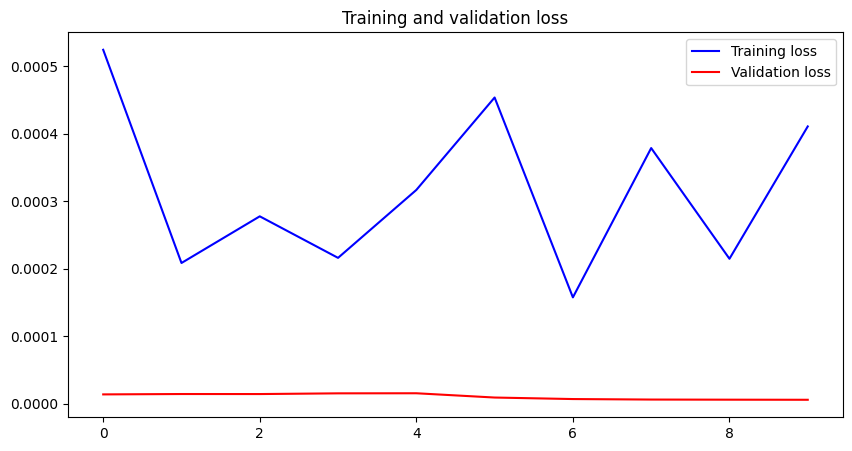

1/1 [==============================] - 0s 47ms/step - loss: 6.0796e-06 - accuracy: 1.0000
Epoch 1/10
11/11 [==============================] - 2s 176ms/step - loss: 1.3386e-04 - accuracy: 1.0000 - val_loss: 7.6490e-06 - val_accuracy: 1.0000
Epoch 2/10
11/11 [==============================] - 2s 170ms/step - loss: 2.1918e-04 - accuracy: 1.0000 - val_loss: 8.6225e-06 - val_accuracy: 1.0000
Epoch 3/10
11/11 [==============================] - 2s 171ms/step - loss: 6.6040e-04 - accuracy: 1.0000 - val_loss: 8.9205e-06 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 2s 171ms/step - loss: 2.9524e-04 - accuracy: 1.0000 - val_loss: 8.3940e-06 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 2s 171ms/step - loss: 7.3166e-05 - accuracy: 1.0000 - val_loss: 8.6126e-06 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 2s 171ms/step - loss: 0.0262 - accuracy: 0.9907 - val_loss: 3.3761e-05 - val_accuracy: 1.0000
Epoch 7/10
11/

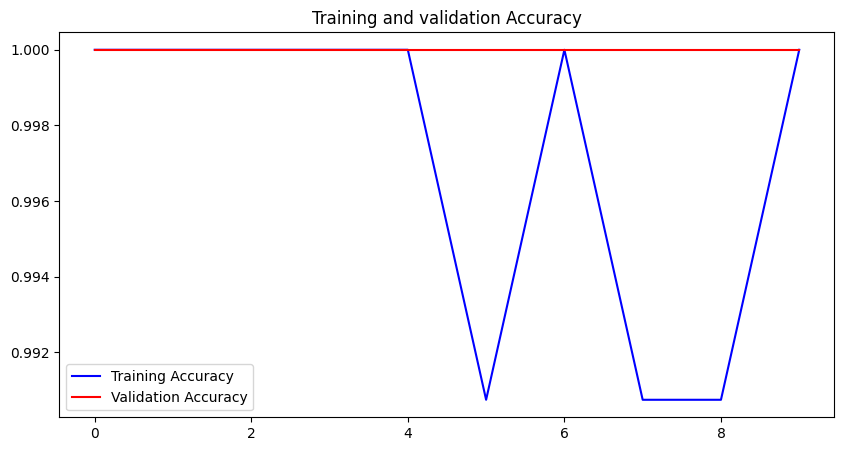

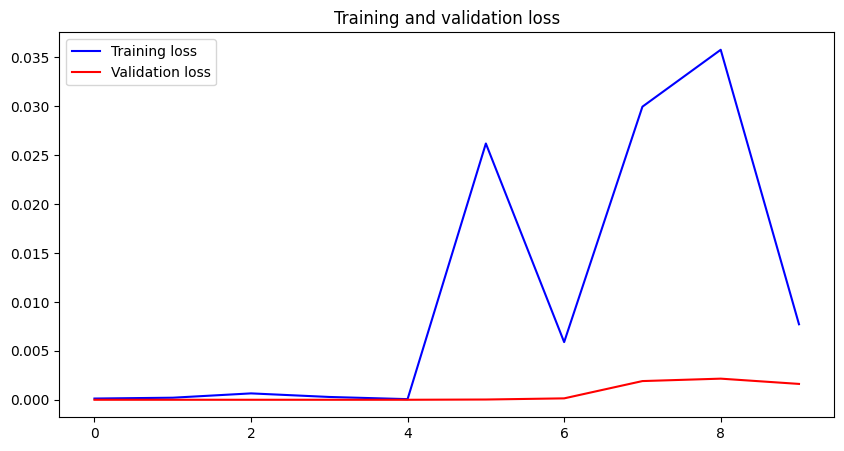

1/1 [==============================] - 0s 50ms/step - loss: 0.0016 - accuracy: 1.0000


In [27]:
weights_list = []

accuracy_train = []
loss_train = []

accuracy_val = []
loss_val = []

# Iterate over the folds
for train_indices, val_indices in kfold.split(cnn_images_gray): # labels
    history_model_cnn_drop_gray = model_cnn_drop_gray.fit(data_norm(cnn_images_gray[train_indices]), labels[train_indices],
                  validation_data=(data_norm(cnn_images_gray[val_indices]), labels[val_indices]),
                  epochs=10,
                  batch_size=batch_size,
                  verbose=1
                  )

    plot_cnn_history(history_model_cnn_drop_gray)

    train_loss, train_accuracy = model_cnn_drop_gray.evaluate(data_norm(cnn_images_gray[train_indices]), labels[train_indices])
    accuracy_train.append(train_accuracy)
    loss_train.append(train_loss)

    val_loss, val_accuracy = model_cnn_drop_gray.evaluate(data_norm(cnn_images_gray[val_indices]), labels[val_indices])
    accuracy_val.append(val_accuracy)
    loss_val.append(val_loss)

    weights_list.append(model_cnn_drop_gray.get_weights())


In [28]:
print("Average Accuracy:", np.mean(accuracy_val))
print("Maximum Accuracy:", np.max(accuracy_val))
print("Average Loss:", np.mean(loss_val))
print("Minimum Loss:", np.min(loss_val))

# 3-channel
# Average Accuracy: 0.9666666686534882
# Maximum Accuracy: 1.0
# Average Loss: 0.12960979614008467
# Minimum Loss: 4.659001660911599e-06

Average Accuracy: 0.95
Maximum Accuracy: 1.0
Average Loss: 0.11802547318707184
Minimum Loss: 6.079615104681579e-06


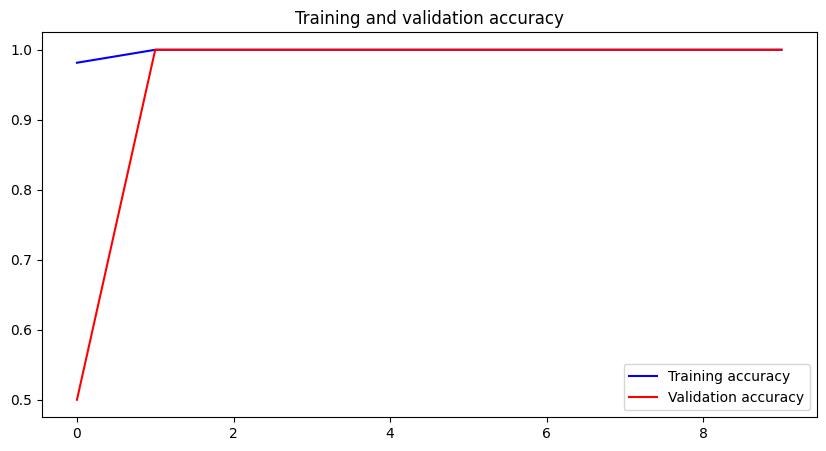

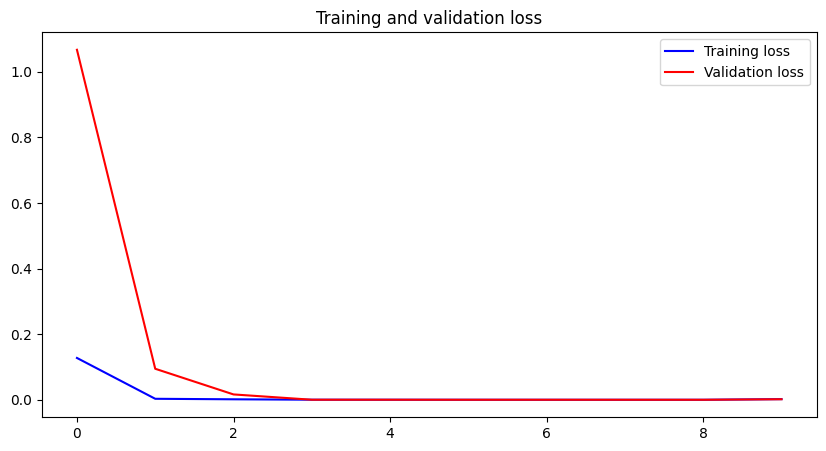

In [29]:
plot_cnn_folds(accuracy_train, accuracy_val, loss_train, loss_val)

In [30]:
# Average the weights
average_weights = np.mean(weights_list, axis=0)

model_cnn_drop_gray.set_weights(average_weights)

# without stratificaion by labels and random_seed
cnn_images_test, cnn_images_rest, labels_test_test, labels_test_rest  = train_test_split(cnn_test_images_gray, labels_test, train_size=0.5)

test_loss, test_accuracy = model_cnn_drop_gray.evaluate(data_norm(cnn_images_test), labels_test_test)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

# Average Accuracy: 0.95
# Average Loss: 0.11802547318707184

# 3-channel
# Test Accuracy: 0.8166666626930237
# Test Loss: 0.8093189597129822

2/2 [==============================] - 3s 3s/step - loss: 1.1045 - accuracy: 0.7333
Test Accuracy: 0.7333333492279053
Test Loss: 1.1044906377792358


In [31]:
# without stratificaion by labels and random_seed
cnn_images_test, cnn_images_rest, labels_test_test, labels_test_rest  = train_test_split(cnn_test_images_gray, labels_test, train_size=0.5)

test_loss, test_accuracy = model_cnn_drop_gray.evaluate(data_norm(cnn_images_test), labels_test_test)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

2/2 [==============================] - 0s 86ms/step - loss: 1.3718 - accuracy: 0.6667
Test Accuracy: 0.6666666865348816
Test Loss: 1.371761441230774


In [32]:
# without stratificaion by labels and random_seed
cnn_images_test, cnn_images_rest, labels_test_test, labels_test_rest  = train_test_split(cnn_test_images_gray, labels_test, train_size=0.5)

test_loss, test_accuracy = model_cnn_drop_gray.evaluate(data_norm(cnn_images_test), labels_test_test)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

2/2 [==============================] - 0s 89ms/step - loss: 1.3642 - accuracy: 0.7167
Test Accuracy: 0.7166666388511658
Test Loss: 1.364153265953064


# Conclusions

**CAE model**

1. Original CAE model: train and validation metrics converged fast and then was decreasing all together.
2. Dropout layers that suppose feature removal couldn't effectively replace the random pixel removal neither on validation nor on training.
3. Adam that is more sufficient method than learning scheduler made learning process abrupt and hasn't reached previous results.
4. Strided Conv layers instead of Pooling hasn't improved the best results neither on validation nor on training.
5. ELU instead of RELU activation function gave learning process a better start, but also made it abruptly and hasn't improved the best results on validation but on training has.
6. Skip connections method finally gave tiny changes for the better.
7. U-net idea implementation: ELU gave us abrupt learning process but now we have visibal changes for the better metrics for CAE model.

**CNN model**

1. Original CNN model upon the original CAE model:
Train and validation accuracy converged extremely fast and validation loss from fold to fold behaves differently. It should tell us about overfitting (we have pretty small dataset with lack of diversity). However the result is close to article's (95-96% accuracy from time to time). Checking the model on a test samples shows worse accuracy and huge loss:
- Average Accuracy: 0.95 vs Test Accuracy: 0.73
- Average Loss: 0.25 vs Test Loss: 0.93
2. Original CNN model upon U-net idea gave overfitting on some folds but on the others underfitting. The average result is worse the original.
3. Fully convolutional network idea upon U-net idea finally relieved us from overfitting but didn't give a better results.
4. Putting fully convolutional network idea upon the original CAE model still relieved us from overfitting but didn't give a better results.
- Average Accuracy: 0.775 vs Test Accuracy: 0.717
- Average Loss: 0.59 vs Test Loss: 0.68
5. Try to kill overfitting in origional CNN with Dropout layer: We still overview fast overfitting, but validation loss now is under train one most of the time that is actually good. The difference beween validaion and test accuracy has reduced:
- Average Accuracy: 0.97 vs Test Accuracy: 0.82
- Average Loss: 0.13 vs Test Loss: 0.81

**Gray scaled images**
- For origional CAE model worked out better:
  - 3-channel: loss = 0.052, mae = 0.174 vs
  - 1-channel: loss = 0.049, mae = 0.165
- For original CNN model with Dropout layer:
  - didn't made any changes in results of training:
    - 3-channel: Average Accuracy = 0.96, Average Loss = 0.13 vs
    - 1-channel: Average Accuracy = 0.95, Average Loss = 0.12
  - but on test worked out worse:
    - 3-channel: Test Accuracy = 0.817, Test Loss = 0.809 vs
    - 1-channel: Test Accuracy: 0.733, Test Loss = 1.104
